In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from scipy import stats
from scipy.stats import zscore
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier



In [128]:
#Reading our dataset 
file_path = "traffic_dataset.csv"
traffic_dataset = pd.read_csv(file_path)
print(traffic_dataset.head())


         DateTime  Junction  Vehicles           ID
0  11/1/2015 0:00         1        15  20151101001
1  11/1/2015 1:00         1        13  20151101011
2  11/1/2015 2:00         1        10  20151101021
3  11/1/2015 3:00         1         7  20151101031
4  11/1/2015 4:00         1         9  20151101041


In [129]:
display(traffic_dataset.describe())
display(traffic_dataset.describe(include = 'object'))

Junction      Vehicles            ID
count  48120.000000  48120.000000  4.812000e+04
mean       2.180549     22.791334  2.016330e+10
std        0.966955     20.750063  5.944854e+06
min        1.000000      1.000000  2.015110e+10
25%        1.000000      9.000000  2.016042e+10
50%        2.000000     15.000000  2.016093e+10
75%        3.000000     29.000000  2.017023e+10
max        4.000000    180.000000  2.017063e+10

DateTime
count             48120
unique            14592
top     6/30/2017 23:00
freq                  4

In [130]:
# Checking if there are any missing values in the dataset
missing_values = traffic_dataset.isna().any()
print(missing_values)


DateTime    False
Junction    False
Vehicles    False
ID          False
dtype: bool


In [131]:
#Converting 'DateTime' to datetime format and set as index if not already done

traffic_dataset['DateTime'] = pd.to_datetime(traffic_dataset['DateTime'])

print(traffic_dataset['DateTime'].dtype)


datetime64[ns]


In [132]:
# Checking for duplicate rows
duplicates = traffic_dataset.duplicated()
print("Number of duplicate entries:", duplicates.sum())
if duplicates.sum() > 0:
    print(traffic_dataset[duplicates])


Number of duplicate entries: 0


In [133]:
traffic_dataset.info()
print(traffic_dataset.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
 3   ID        48120 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 1.5 MB
Index(['DateTime', 'Junction', 'Vehicles', 'ID'], dtype='object')


In [134]:
#Feature Engineering
#Extracting important features from datetime column
# Exploring more features  
traffic_dataset["Year"]= traffic_dataset['DateTime'].dt.year  
traffic_dataset["Month"]= traffic_dataset['DateTime'].dt.month  
traffic_dataset["Date_no"]= traffic_dataset['DateTime'].dt.day  
traffic_dataset["Hour"]= traffic_dataset['DateTime'].dt.hour  
#traffic_dataset["Day"]= traffic_dataset.DateTime.dt.strftime("%A")


In [135]:
traffic_dataset.head()

DateTime  Junction  Vehicles           ID  Year  Month  Date_no  \
0 2015-11-01 00:00:00         1        15  20151101001  2015     11        1   
1 2015-11-01 01:00:00         1        13  20151101011  2015     11        1   
2 2015-11-01 02:00:00         1        10  20151101021  2015     11        1   
3 2015-11-01 03:00:00         1         7  20151101031  2015     11        1   
4 2015-11-01 04:00:00         1         9  20151101041  2015     11        1   

   Hour  
0     0  
1     1  
2     2  
3     3  
4     4

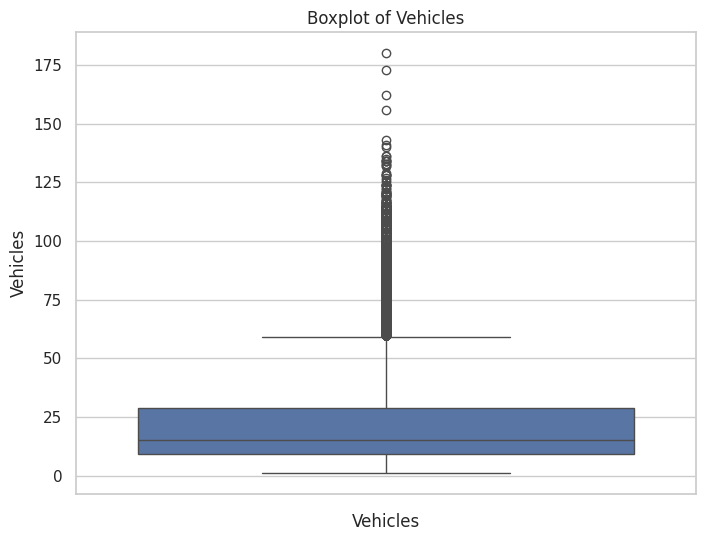

In [136]:
# Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=traffic_dataset['Vehicles'])
plt.title('Boxplot of Vehicles')
plt.xlabel('Vehicles')
plt.show()
from scipy import stats
z_scores = np.abs(stats.zscore(traffic_dataset['Vehicles']))
threshold = 3
outlier_indices = np.where(z_scores > threshold)
plt.savefig('boxplot_of_vehicles.png')



<Figure size 1200x800 with 0 Axes>

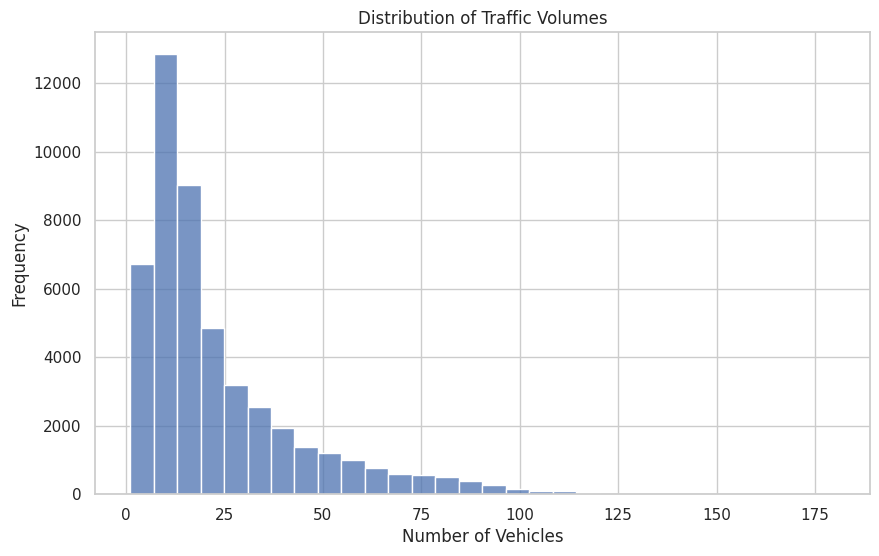

In [137]:
#Data Visualization
#Creating a histogram of the Vehicles column
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(traffic_dataset['Vehicles'], kde=False, bins=30)
plt.title('Distribution of Traffic Volumes')
plt.xlabel('Number of Vehicles')
plt.ylabel('Frequency')
plt.show()
plt.savefig('Distribution of Traffic Volumes.png')

<Figure size 1200x800 with 0 Axes>

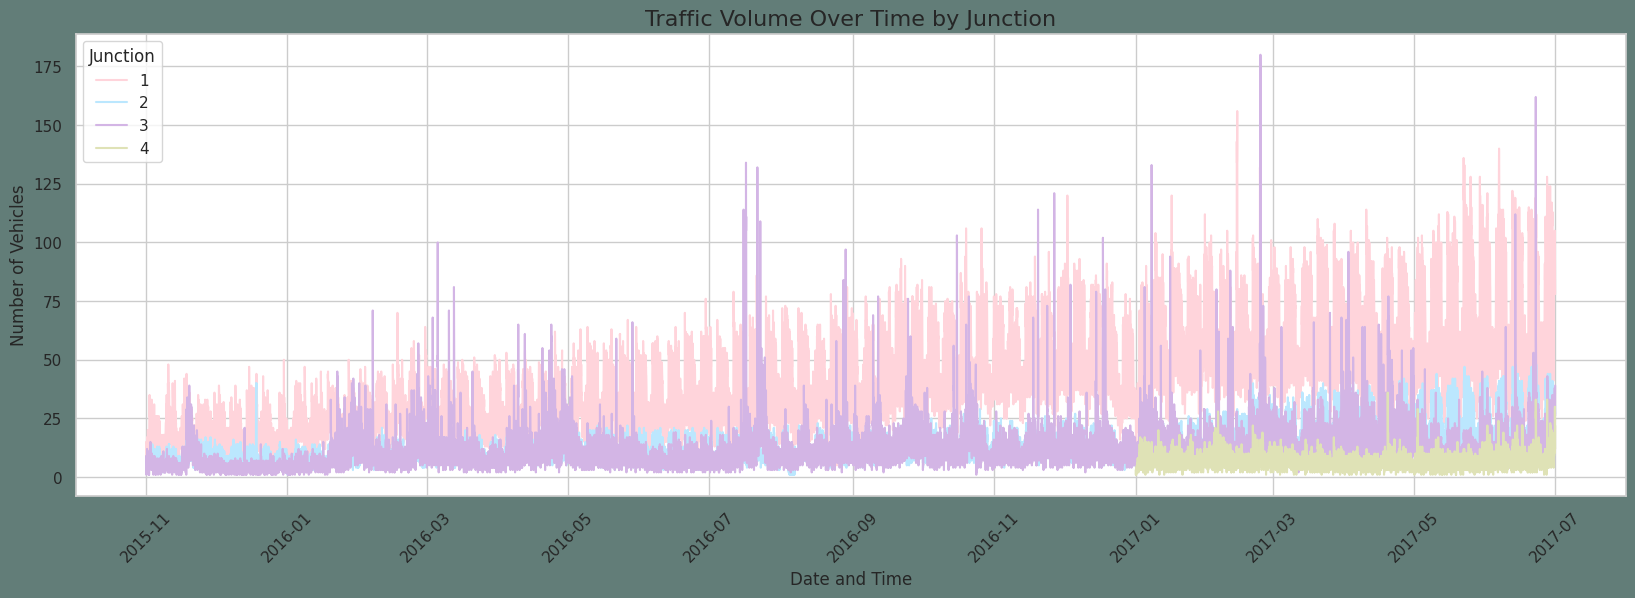

In [89]:
# Time series plot
colors = ["#FFD4DB", "#BBE7FE", "#D3B5E5", "#dfe2b6"]
plt.figure(figsize=(20, 6), facecolor="#627D78")

time_series = sns.lineplot(x=traffic_dataset['DateTime'], y="Vehicles", data=traffic_dataset, hue="Junction", palette=colors)

time_series.set_title("Traffic Volume Over Time by Junction", fontsize=16)

time_series.set_ylabel("Number of Vehicles", fontsize=12)

time_series.set_xlabel("Date and Time", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Junction", loc="upper left")

plt.show()
plt.savefig('Traffic Volume Over Time by Junction.png')



<Figure size 1200x800 with 0 Axes>

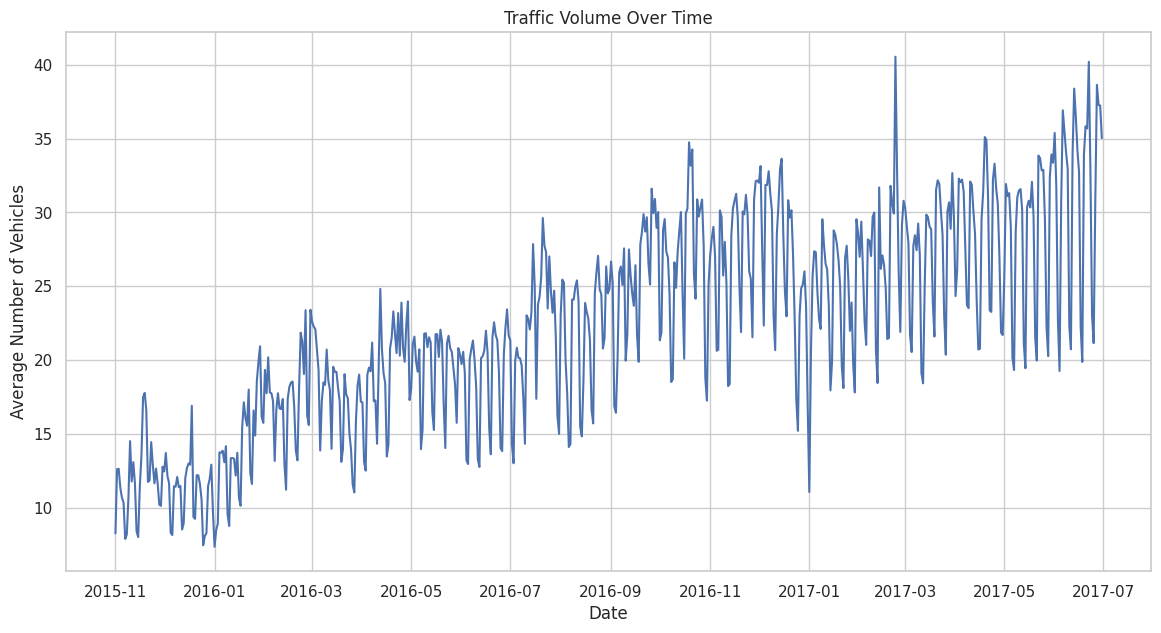

In [90]:
#Creating a line plot of traffic volume over time
#For better readability, resample the data by day and take the mean
plt.figure(figsize=(14, 7))
traffic_data_resampled = traffic_dataset.set_index('DateTime').resample('D').mean()
sns.lineplot(data=traffic_data_resampled, x=traffic_data_resampled.index, y='Vehicles')
plt.title('Traffic Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Average Number of Vehicles')
plt.show()
plt.savefig('Traffic Volume Over Time.png')

<Figure size 640x480 with 0 Axes>

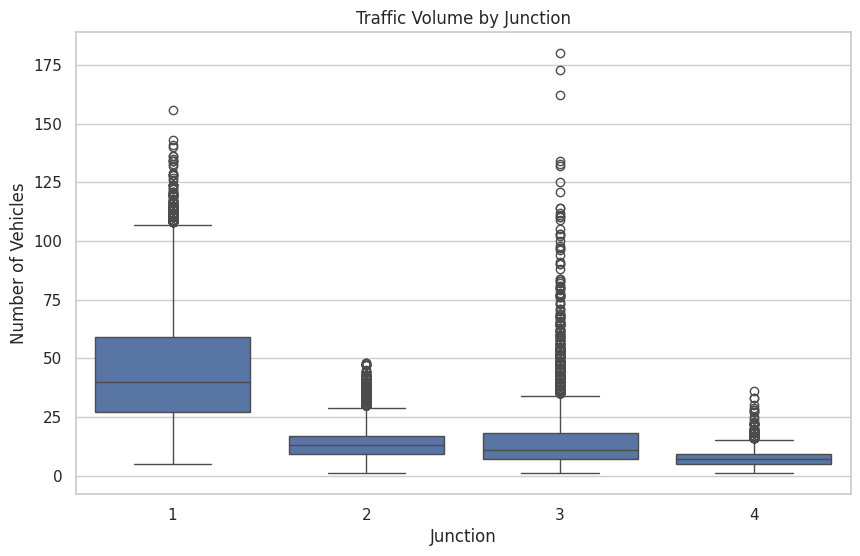

In [14]:
#Creating boxplots to compare traffic volumes across different junctions
plt.figure(figsize=(10, 6))
sns.boxplot(x='Junction', y='Vehicles', data=traffic_dataset)
plt.title('Traffic Volume by Junction')
plt.xlabel('Junction')
plt.ylabel('Number of Vehicles')
plt.show()
plt.savefig('Traffic Volume by Junction.png')

<Figure size 640x480 with 0 Axes>

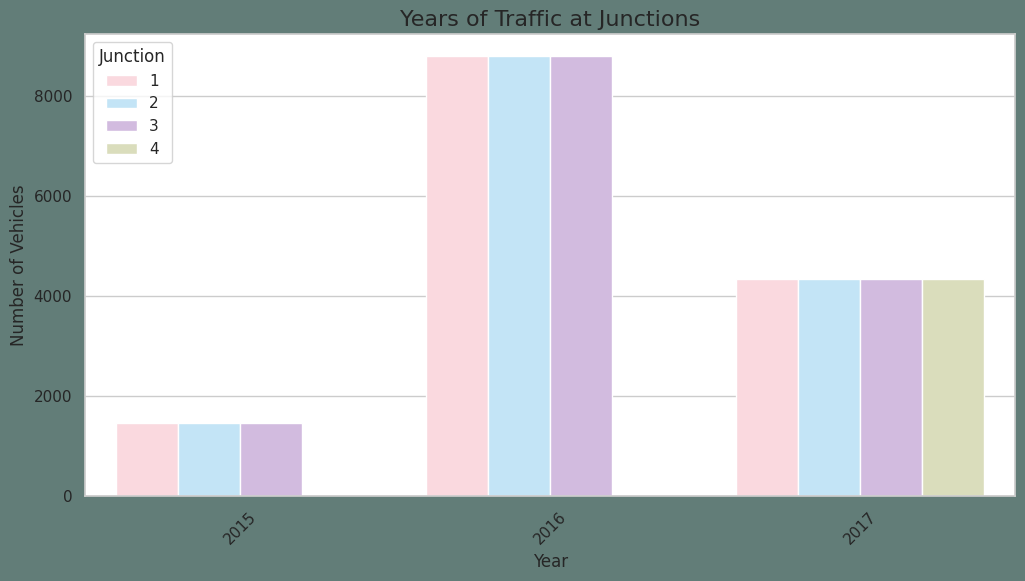

In [15]:
# Years of traffic at junctions
plt.figure(figsize=(12, 6), facecolor="#627D78")
colors = ["#FFD4DB", "#BBE7FE", "#D3B5E5", "#dfe2b6"]
count = sns.countplot(data=traffic_dataset, x=traffic_dataset["Year"], hue="Junction", palette=colors)
count.set_title("Years of Traffic at Junctions", fontsize=16)
count.set_ylabel("Number of Vehicles", fontsize=12)
count.set_xlabel("Year", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Junction", loc="upper left")

plt.show()
plt.savefig('Years of Traffic at Junctions.png')


<Figure size 640x480 with 0 Axes>

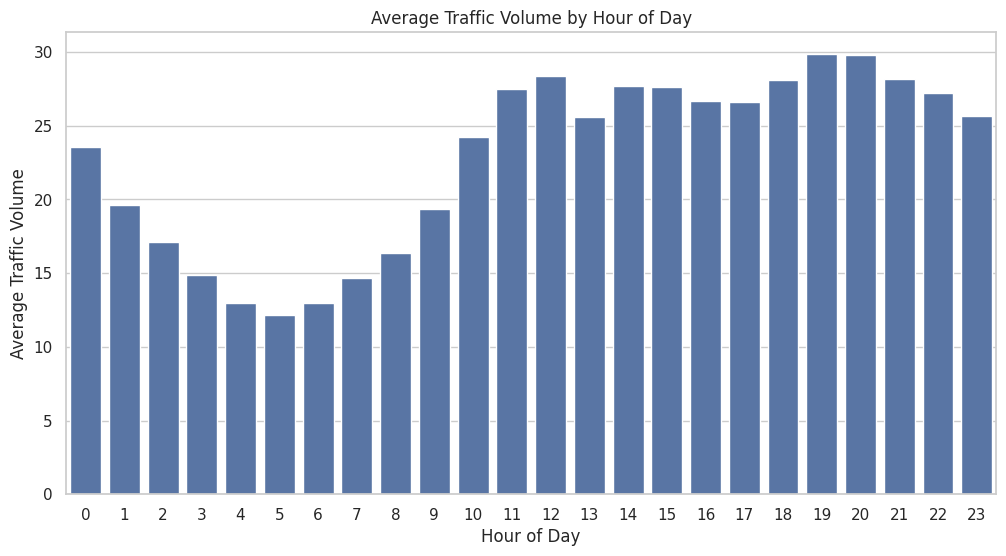

In [16]:
#Identifying peak traffic hours and analyzing traffic patterns by the day of the week
traffic_dataset['HourOfDay'] = traffic_dataset['DateTime'].dt.hour
traffic_dataset['DayOfWeek'] = traffic_dataset['DateTime'].dt.day_name()
hourly_traffic = traffic_dataset.groupby('HourOfDay')['Vehicles'].mean().reset_index()
weekly_traffic = traffic_dataset.groupby('DayOfWeek')['Vehicles'].mean().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
).reset_index()
# Plotting the hourly traffic volume

plt.figure(figsize=(12, 6))
sns.barplot(x='HourOfDay', y='Vehicles', data=hourly_traffic)
plt.title('Average Traffic Volume by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Traffic Volume')
plt.xticks(np.arange(0, 24, 1))
plt.show()
plt.savefig('Average Traffic Volume by Hour of Day.png')

<Figure size 640x480 with 0 Axes>

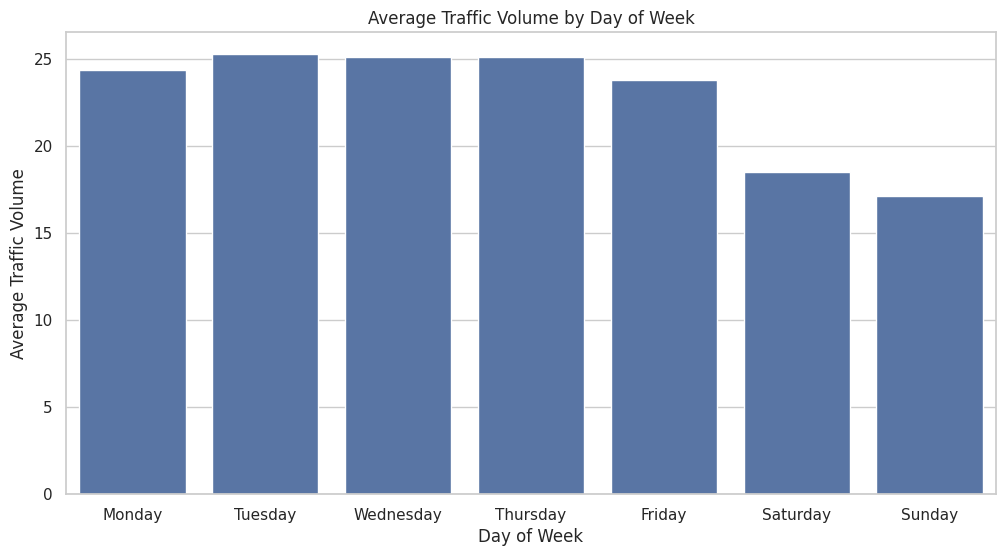

In [17]:
# Plotting the daily traffic volume

plt.figure(figsize=(12, 6))
sns.barplot(x='DayOfWeek', y='Vehicles', data=weekly_traffic)
plt.title('Average Traffic Volume by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Traffic Volume')
plt.show()
plt.savefig('average_traffic_volume_by_day_of_week.png')


<Figure size 640x480 with 0 Axes>

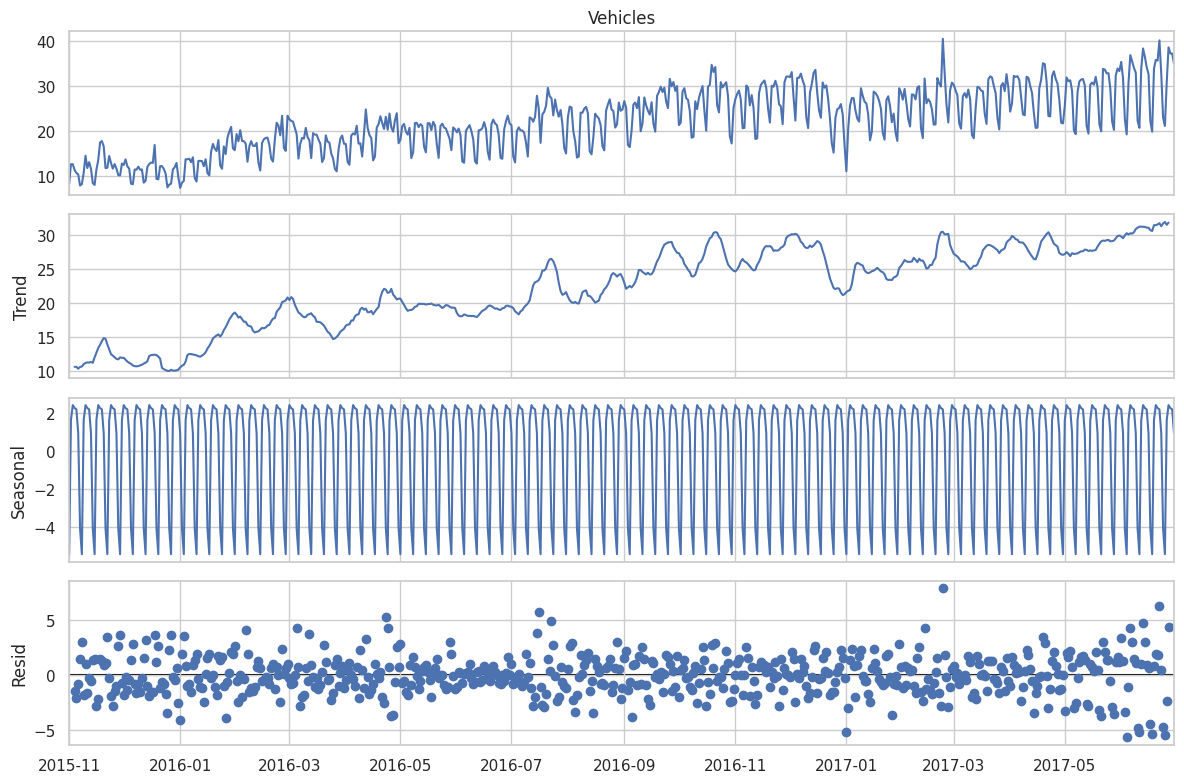

In [18]:
# Time Series Decomposition
#Decomposing the traffic volume time series into trend, seasonal, and residual components to better understand underlying patterns
traffic_dataset['DateTime'] = pd.to_datetime(traffic_dataset['DateTime'])
traffic_dataset.set_index('DateTime', inplace=True)
daily_traffic = traffic_dataset.resample('D').mean()
result = seasonal_decompose(daily_traffic['Vehicles'], model='additive', period=7)

plt.rcParams['figure.figsize'] = [12, 8]

result.plot()
plt.tight_layout()
plt.show()
plt.savefig('seasonal_decompose.png')

The actual traffic volume data reveals fluctuations over time, suggesting a repeating pattern indicative of seasonality.

Trend: This component presents a smoothed version of the observed data, highlighting long-term changes in traffic volume. The trend line shows periods of increase and decrease, but without additional context, definitive conclusions are difficult. Some fluctuations in the trend may correspond to underlying factors affecting traffic volume over an extended period.

Seasonal: The seasonal component captures the regular, repeating pattern in the data, likely on a weekly basis, assuming a decomposition period of 7. The consistent pattern shows regular peaks and troughs, indicating higher traffic volumes on specific days of the week, likely related to typical workweek patterns.

Residual: These are the irregularities or noise remaining after removing the trend and seasonal components. The residuals appear randomly scattered around zero without a discernible pattern, suggesting that the model effectively captures the trend and seasonality. However, a few outliers indicate occasional deviations from the expected traffic volume not explained by the trend or seasonal components.

Overall, the decomposition indicates a strong seasonal pattern in the data, with some long-term trends and random noise. These insights can aid in forecasting traffic volumes, planning city infrastructure, and managing peak traffic times. Understanding the trend is useful for long-term planning, while the seasonal component can inform short-term operational decisions, such as traffic light coordination and congestion management strategies.


In [19]:
#Correlation Analysis
traffic_dataset.index = pd.to_datetime(traffic_dataset.index)
traffic_dataset['HourOfDay'] = traffic_dataset.index.hour
traffic_dataset['DayOfWeek'] = traffic_dataset.index.dayofweek  # Monday=0, Sunday=6
correlation_matrix = traffic_dataset[['HourOfDay', 'DayOfWeek', 'Vehicles']].corr()
print(correlation_matrix)



              HourOfDay     DayOfWeek  Vehicles
HourOfDay  1.000000e+00  6.442124e-18  0.219938
DayOfWeek  6.442124e-18  1.000000e+00 -0.126027
Vehicles   2.199377e-01 -1.260265e-01  1.000000


HourOfDay and DayOfWeek: The correlation is 6.442124e-18, which is essentially zero. This indicates there is no linear relationship between the hour of the day and the day of the week.

HourOfDay and Vehicles: The correlation is 0.219938, suggesting a weak positive correlation. This means that as the hour of the day changes, there is a slight tendency for the number of vehicles to change in the same direction, although the relationship is not strong.

DayOfWeek and Vehicles: The correlation is -0.126027, indicating a weak negative correlation. This suggests that as the day of the week progresses, there is a slight tendency for the number of vehicles to move in the opposite direction, though the relationship is also not strong.

<Figure size 1200x800 with 0 Axes>

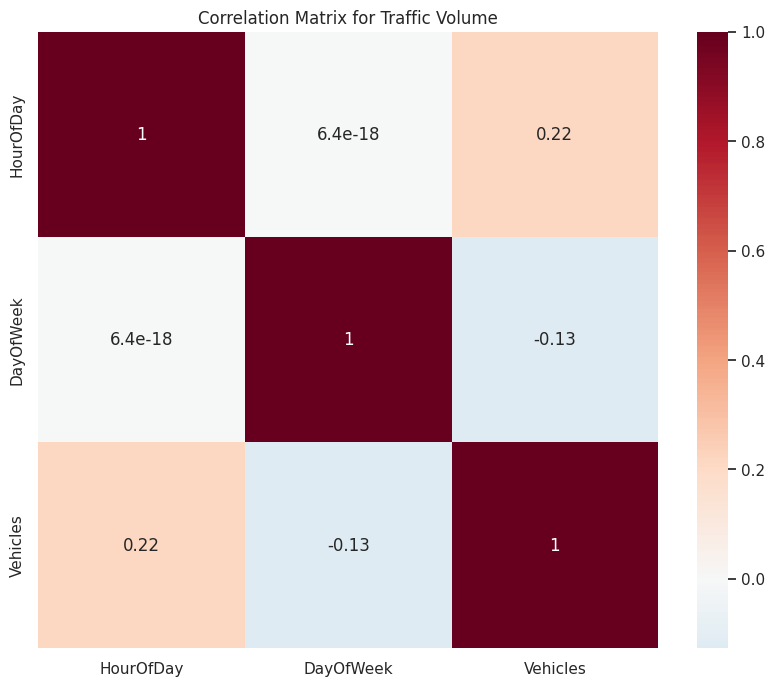

In [20]:
#correlation matrix 
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0)
plt.title('Correlation Matrix for Traffic Volume')
plt.show()
plt.savefig('Correlation Matrix .png')



<Figure size 1200x800 with 0 Axes>

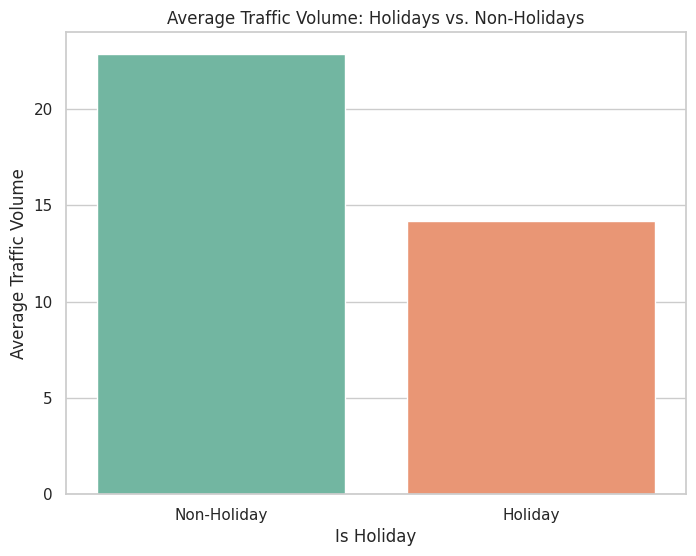

In [21]:
#Holiday Effects
traffic_dataset.reset_index(inplace=True)
traffic_dataset['DateTime'] = pd.to_datetime(traffic_dataset['DateTime'])

# Defining a hypothetical list of public holiday dates
public_holidays = ['2016-01-01', '2016-07-04', '2016-12-25'] 

# Converting holiday dates to datetime
public_holidays = pd.to_datetime(public_holidays)

# Creating a holiday indicator in the traffic data
traffic_dataset['IsHoliday'] = traffic_dataset['DateTime'].dt.date.isin(public_holidays.date)

# Calculating the average traffic volumes for holidays and non-holidays
holiday_traffic = traffic_dataset.groupby('IsHoliday')['Vehicles'].mean().reset_index()
plt.figure(figsize=(8, 6))
bar_plot = sns.barplot(x='IsHoliday', y='Vehicles', data=holiday_traffic, palette='Set2')
bar_plot.set_title('Average Traffic Volume: Holidays vs. Non-Holidays')
bar_plot.set_xlabel('Is Holiday')
bar_plot.set_ylabel('Average Traffic Volume')
bar_plot.set_xticklabels(['Non-Holiday', 'Holiday'])
plt.show()
plt.savefig('Holidays vs. Non-Holidays.png')


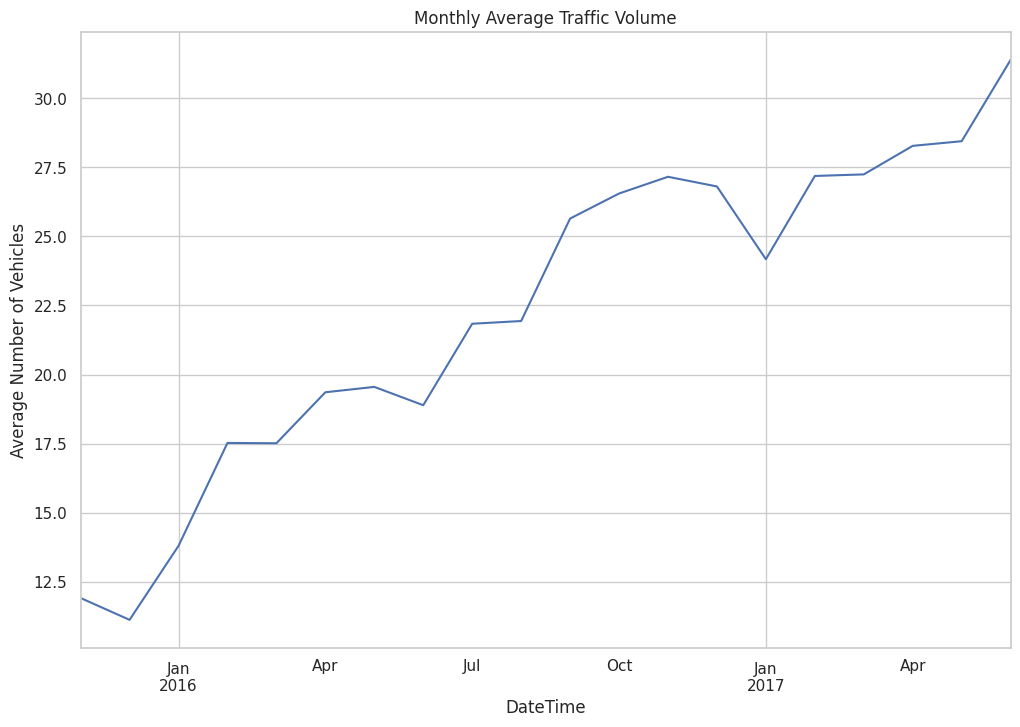

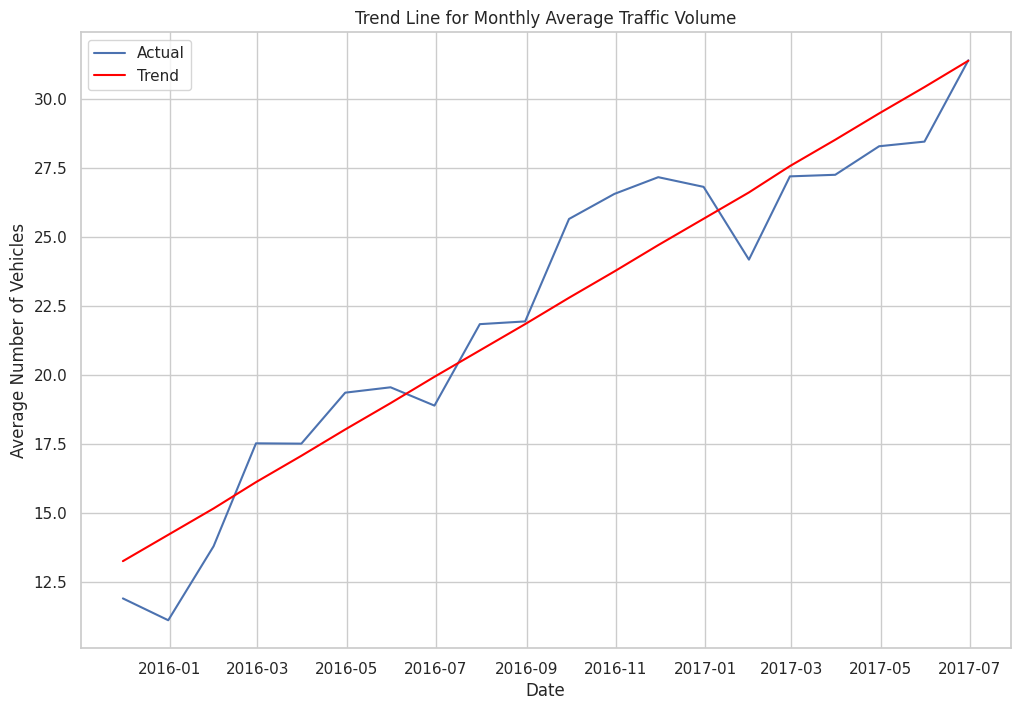

In [22]:
#Long-term Trends
#Analyzing if there is a long-term increase or decrease in traffic volumes, which could be indicative of urban development or changes in population density
traffic_dataset['DateTime'] = pd.to_datetime(traffic_dataset['DateTime'])

# Resampling the data to get monthly averages
traffic_dataset.set_index('DateTime', inplace=True)
monthly_traffic = traffic_dataset.resample('M').mean()
monthly_traffic['Vehicles'].plot(title='Monthly Average Traffic Volume')
plt.ylabel('Average Number of Vehicles')
plt.show()

# Linear Regression for Trend Analysis

X = np.arange(len(monthly_traffic)).reshape(-1, 1)  
y = monthly_traffic['Vehicles'].values  

# Create and fit the model
model = LinearRegression()
model.fit(X, y)

# Predict the trend
trend = model.predict(X)

# Plot the trend
plt.plot(monthly_traffic.index, y, label='Actual')
plt.plot(monthly_traffic.index, trend, label='Trend', color='red')
plt.title('Trend Line for Monthly Average Traffic Volume')
plt.xlabel('Date')
plt.ylabel('Average Number of Vehicles')
plt.legend()
plt.show()
plt.savefig('Trend Line for Monthly Average Traffic Volume.png')


The first chart shows the monthly average traffic volume over time. There is a general upward trend in traffic volumes, suggesting an increase in traffic over the months. Notably, there are fluctuations, with a noticeable dip around October 2016, followed by a subsequent rise.

The second chart overlays a trend line (in red) on the actual monthly average traffic volume (in blue). The linear trend line indicates a clear upward trajectory, confirming a long-term increase in traffic volumes over this period. This trend could be indicative of factors such as urban development, an increase in population density, or changes in traffic patterns.

The upward trend suggests that traffic management strategies may need to adapt to increasing volumes. City planners and policymakers might consider this data when making decisions about infrastructure development and public transportation planning to mitigate congestion.

<Figure size 1200x800 with 0 Axes>

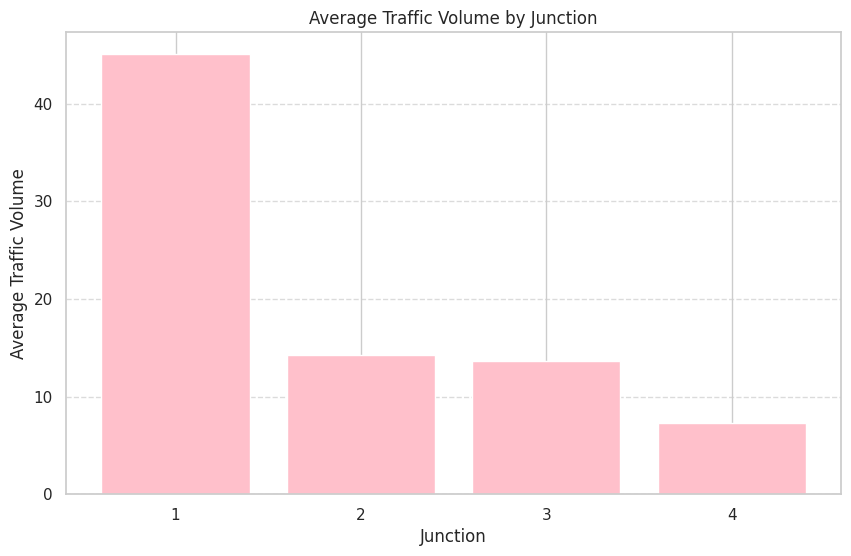

In [34]:
traffic_dataset['DateTime'] = pd.to_datetime(traffic_dataset['DateTime'])
junction_comparison = traffic_dataset.groupby('Junction')['Vehicles'].mean().reset_index()

# Plotting the average traffic volume by junction
plt.figure(figsize=(10, 6))
plt.bar(junction_comparison['Junction'], junction_comparison['Vehicles'], color='pink')
plt.title('Average Traffic Volume by Junction')
plt.xlabel('Junction')
plt.ylabel('Average Traffic Volume')
plt.xticks(junction_comparison['Junction'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
plt.savefig('Average Traffic Volume by Junction.png')



In [35]:
avg_traffic_by_junction = traffic_dataset.groupby('Junction')['Vehicles'].mean()
avg_traffic_by_junction

Junction
1    45.052906
2    14.253221
3    13.694010
4     7.251611
Name: Vehicles, dtype: float64

In [36]:
traffic_dataset['DateTime'] = pd.to_datetime(traffic_dataset['DateTime'])
traffic_dataset.set_index('DateTime', inplace=True)
daily_traffic = traffic_dataset.resample('D').sum()
daily_traffic['Z-Score'] = zscore(daily_traffic['Vehicles'])
threshold = 2
outliers = daily_traffic[(daily_traffic['Z-Score'] > threshold) | (daily_traffic['Z-Score'] < -threshold)]
print(outliers)


            Junction  Vehicles             ID    Year  Month  Date_no  Hour  \
DateTime                                                                      
2017-02-23       240      3892  1936341419280  193632    192     2208  1104   
2017-04-19       240      3370  1936360235280  193632    384     1824  1104   
2017-04-20       240      3352  1936360331280  193632    384     1920  1104   
2017-06-01       240      3397  1936377707280  193632    576       96  1104   
2017-06-06       240      3544  1936378187280  193632    576      576  1104   
2017-06-07       240      3411  1936378283280  193632    576      672  1104   
2017-06-08       240      3273  1936378379280  193632    576      768  1104   
2017-06-13       240      3685  1936378859280  193632    576     1248  1104   
2017-06-14       240      3506  1936378955280  193632    576     1344  1104   
2017-06-15       240      3284  1936379051280  193632    576     1440  1104   
2017-06-20       240      3440  1936379531280  19363

In [37]:
# Reading the weather dataset
file_path = "weather_data.csv"
weather_data = pd.read_csv(file_path)
print(weather_data.head())

          utc_timestamp  AT_temperature  AT_radiation_direct_horizontal  \
0  2015-11-01T00:00:00Z           2.564                             0.0   
1  2015-11-01T01:00:00Z           2.139                             0.0   
2  2015-11-01T02:00:00Z           1.853                             0.0   
3  2015-11-01T03:00:00Z           1.506                             0.0   
4  2015-11-01T04:00:00Z           1.074                             0.0   

   AT_radiation_diffuse_horizontal  BE_temperature  \
0                              0.0           6.724   
1                              0.0           6.812   
2                              0.0           6.896   
3                              0.0           6.894   
4                              0.0           6.896   

   BE_radiation_direct_horizontal  BE_radiation_diffuse_horizontal  \
0                             0.0                              0.0   
1                             0.0                              0.0   
2             

In [38]:
# Renaming the 'utc_timestamp' column to 'DateTime'
weather_data = weather_data.rename(columns={'utc_timestamp': 'DateTime'})
weather_data['DateTime'] = pd.to_datetime(weather_data['DateTime'])
weather_data['DateTime'] = weather_data['DateTime'].dt.tz_localize(None)
print(weather_data.head())


             DateTime  AT_temperature  AT_radiation_direct_horizontal  \
0 2015-11-01 00:00:00           2.564                             0.0   
1 2015-11-01 01:00:00           2.139                             0.0   
2 2015-11-01 02:00:00           1.853                             0.0   
3 2015-11-01 03:00:00           1.506                             0.0   
4 2015-11-01 04:00:00           1.074                             0.0   

   AT_radiation_diffuse_horizontal  BE_temperature  \
0                              0.0           6.724   
1                              0.0           6.812   
2                              0.0           6.896   
3                              0.0           6.894   
4                              0.0           6.896   

   BE_radiation_direct_horizontal  BE_radiation_diffuse_horizontal  \
0                             0.0                              0.0   
1                             0.0                              0.0   
2                         

<Figure size 1200x800 with 0 Axes>

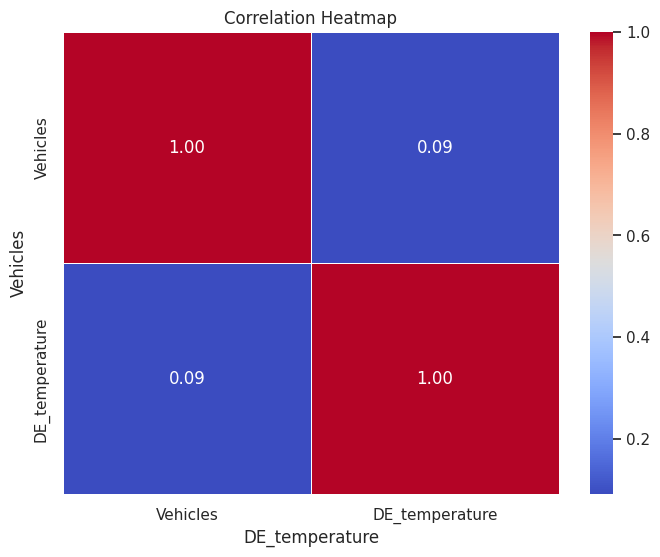

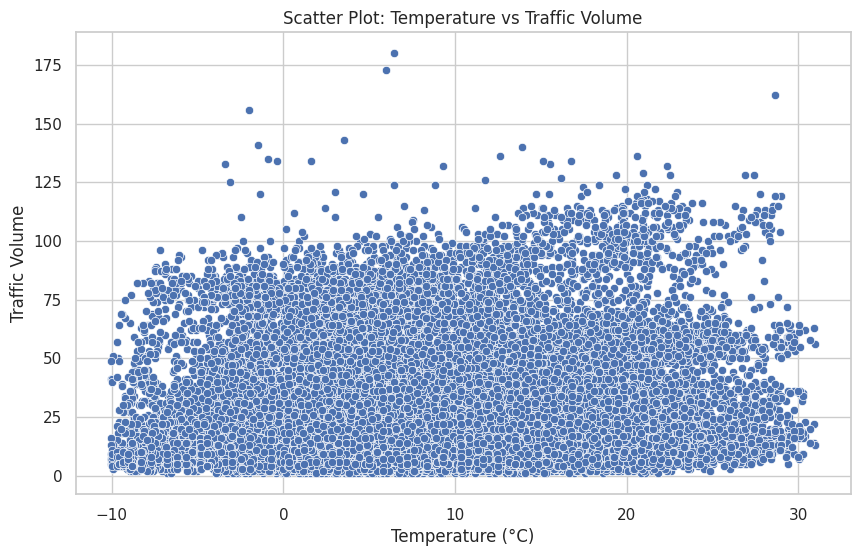

In [52]:
traffic_dataset['DateTime'] = pd.to_datetime(traffic_dataset['DateTime'])
weather_data['DateTime'] = pd.to_datetime(weather_data['DateTime']).dt.tz_localize(None)  
weather_data_de = weather_data[['DateTime', 'DE_temperature']]
combined_data = pd.merge_asof(traffic_dataset.sort_values('DateTime'),
                              weather_data_de.sort_values('DateTime'),
                              on='DateTime',
                              direction='nearest')

# Correlation analysis
correlation_matrix = combined_data[['Vehicles', 'DE_temperature']].corr()

# Plotting correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.xlabel('DE_temperature')
plt.ylabel('Vehicles')
plt.show()

# Scatter plot of temperature vs traffic volume
plt.figure(figsize=(10, 6))
sns.scatterplot(data=combined_data, x='DE_temperature', y='Vehicles')
plt.title('Scatter Plot: Temperature vs Traffic Volume')
plt.xlabel('Temperature (°C)')
plt.ylabel('Traffic Volume')
plt.grid(True)
plt.show()


Heatmap: It shows a weak positive correlation (0.09) between DE_timestamp and Vehicles. The correlation coefficient indicates there is a slight positive relationship between the time and the number of vehicles, meaning as time progresses, there is a tendency for the number of vehicles to increase slightly. However, this relationship is not strong.
Scatter Plot: The scatter plot visualizes individual data points with respect to DE_temperature (presumed on the x-axis) and the number of Vehicles (on the y-axis).There is no clear pattern or relationship visualized between the temperature and the number of vehicles, indicating that temperature alone may not be a strong predictor of traffic volume.

In statistics, an augmented Dickey–Fuller test (ADF) tests the null hypothesis that a unit root is present in a time series sample. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity. It is an augmented version of the Dickey–Fuller test for a larger and more complicated set of time series models.
The augmented Dickey–Fuller (ADF) statistic, used in the test, is a negative number. The more negative it is, the stronger the rejection of the hypothesis that there is a unit root at some level of confidence.


In [53]:
from statsmodels.tsa.stattools import adfuller

def adf_check(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

# Applying the function on time series data
adf_check(traffic_dataset['Vehicles'])


ADF Statistic: -7.518278111935738
p-value: 3.851060199915222e-11
Critical Values:
	1%: -3.430486066940443
	5%: -2.8616001387397922
	10%: -2.566802009871527


In [54]:
# Calculating the first difference of the 'Vehicles' data
traffic_dataset['Vehicles_diff'] = traffic_dataset['Vehicles'] - traffic_dataset['Vehicles'].shift(1)

# Applying the ADF test on the differenced data
result = adfuller(traffic_dataset['Vehicles_diff'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))


ADF Statistic: -35.78125992349592
p-value: 0.0
Critical Values:
	1%: -3.4304860697717245
	5%: -2.8616001399911304
	10%: -2.5668020105375784


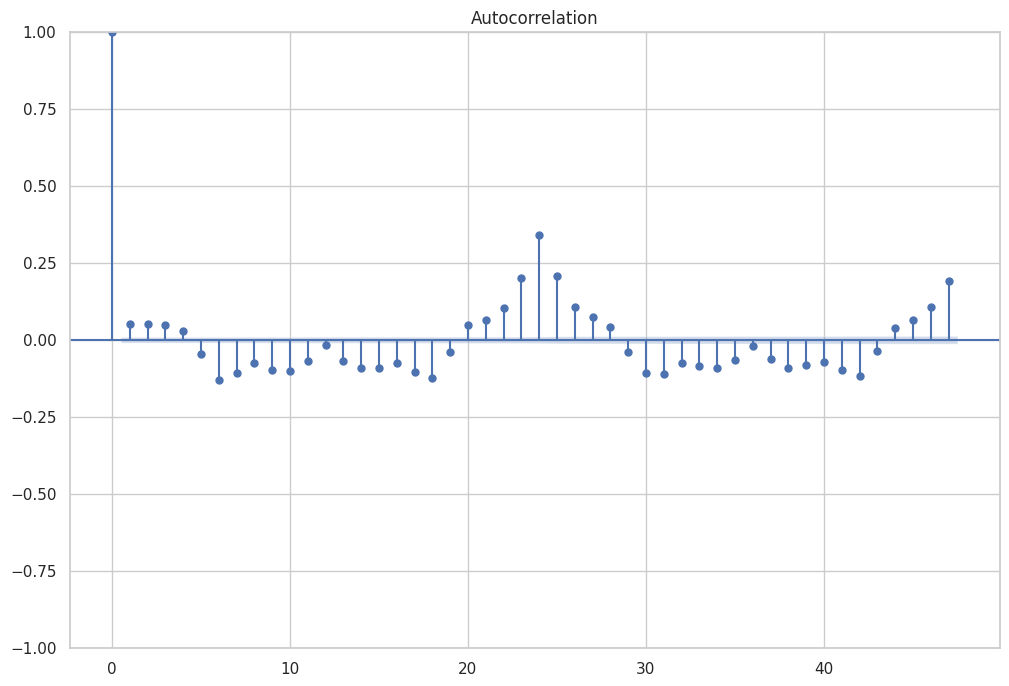

In [64]:
plot_acf(traffic_dataset['Vehicles_diff'].dropna())

The autocorrelation plot indicates a strong initial correlation that decreases over time, with periodic spikes suggesting seasonal effects every 20 lags. This pattern implies that the data may exhibit both short-term dependencies and recurring seasonal trends.

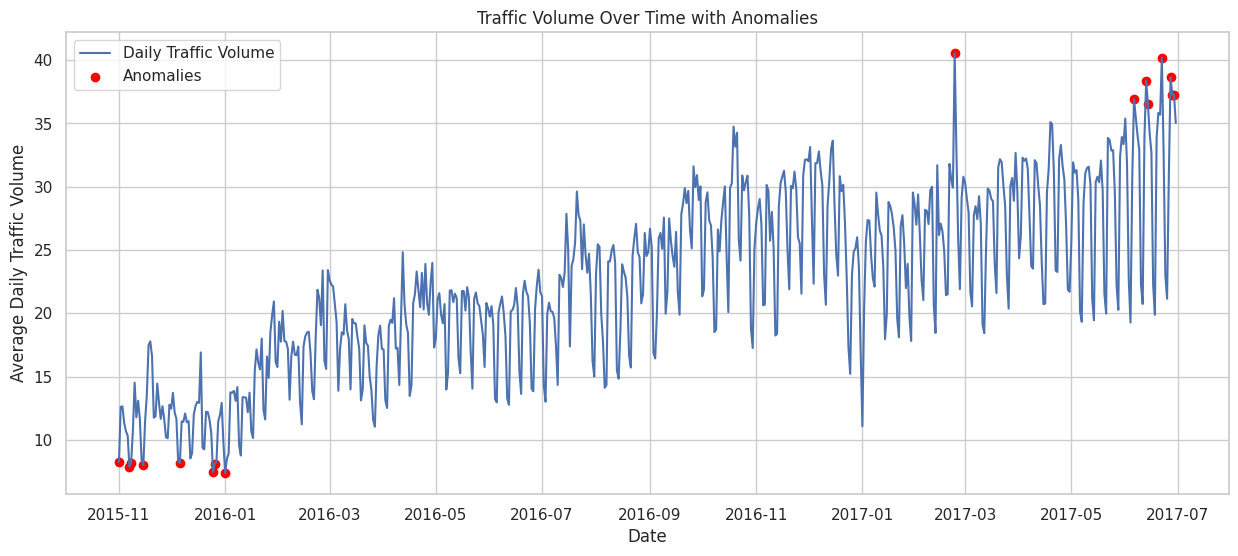

In [55]:
#Impact of External Factors
#Looking for external factors that may impact traffic volume, like nearby construction projects or new traffic regulations
traffic_dataset['DateTime'] = pd.to_datetime(traffic_dataset['DateTime'])
traffic_dataset_daily = traffic_dataset.set_index('DateTime').resample('D').mean()
traffic_dataset_daily['z_score'] = (traffic_dataset_daily['Vehicles'] - traffic_dataset_daily['Vehicles'].mean()) / traffic_dataset_daily['Vehicles'].std()
anomalies = traffic_dataset_daily[abs(traffic_dataset_daily['z_score']) > 2]

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(traffic_dataset_daily.index, traffic_dataset_daily['Vehicles'], label='Daily Traffic Volume')
plt.scatter(anomalies.index, anomalies['Vehicles'], color='red', label='Anomalies')
plt.xlabel('Date')
plt.ylabel('Average Daily Traffic Volume')
plt.title('Traffic Volume Over Time with Anomalies')
plt.legend()
plt.show()

The chart provided is a line graph illustrating the average daily traffic volume over time, with specific anomalies highlighted in red. The analysis reveals a slight upward trend in traffic volume, suggesting a general increase over the observed period from November 2015 to July 2017. Regular patterns indicate seasonality, with consistent peaks and troughs likely corresponding to specific times of the year, such as holidays or seasonal events. The red dots represent anomalies where traffic volume significantly deviated from the norm, potentially due to external factors like road closures, construction projects, accidents, or events. These anomalies require further investigation by cross-referencing with external data. Notably, there are periods of both unusually low and high traffic volumes, which could be due to various factors such as sensor malfunctions, data collection issues, or impactful events. Overall, the chart provides valuable insights into traffic trends and anomalies, aiding in the understanding of external influences on traffic patterns and supporting traffic management and infrastructure planning efforts.

In [63]:
traffic_dataset['DateTime'] = pd.to_datetime(traffic_dataset['DateTime'])
traffic_dataset = traffic_dataset.sort_values(by='DateTime')

# Check for missing timestamps
expected_timestamps = pd.date_range(start=traffic_dataset['DateTime'].min(), 
                                    end=traffic_dataset['DateTime'].max(), 
                                    freq='H')
missing_timestamps = expected_timestamps.difference(traffic_dataset['DateTime'])

# Check the number of records per junction
records_per_junction = traffic_dataset['Junction'].value_counts()

# Check for irregular time intervals
time_diffs = traffic_dataset.groupby('Junction').apply(lambda x: x['DateTime'].diff().unique())
# Get the time range for each junction
time_range_per_junction = traffic_dataset.groupby('Junction')['DateTime'].agg(['min', 'max'])
# Detecting outliers in 'Vehicles' column
Q1 = traffic_dataset['Vehicles'].quantile(0.25)
Q3 = traffic_dataset['Vehicles'].quantile(0.75)
IQR = Q3 - Q1
outliers = traffic_dataset[(traffic_dataset['Vehicles'] < (Q1 - 1.5 * IQR)) | (traffic_dataset['Vehicles'] > (Q3 + 1.5 * IQR))]
# Step 1: Print Missing Timestamps
print("Missing Timestamps:")
print(missing_timestamps)

# Step 2: Print Records Per Junction and Time Intervals
print("\nRecords per Junction:")
print(records_per_junction)
print("\nTime Intervals:")
print(time_diffs)

# Step 3: Print Time Range for Each Junction
print("\nTime Range for Each Junction:")
print(time_range_per_junction)

# Step 4: Print and Visualize Outliers
print("\nOutliers in Vehicle Counts:")
print(outliers)


Missing Timestamps:
DatetimeIndex([], dtype='datetime64[ns]', freq=None)

Records per Junction:
1    14592
2    14592
3    14592
4     4344
Name: Junction, dtype: int64

Time Intervals:
Junction
1    [NaT, 3600000000000 nanoseconds]
2    [NaT, 3600000000000 nanoseconds]
3    [NaT, 3600000000000 nanoseconds]
4    [NaT, 3600000000000 nanoseconds]
dtype: object

Time Range for Each Junction:
                min                 max
Junction                               
1        2015-11-01 2017-06-30 23:00:00
2        2015-11-01 2017-06-30 23:00:00
3        2015-11-01 2017-06-30 23:00:00
4        2017-01-01 2017-06-30 23:00:00

Outliers in Vehicle Counts:
                 DateTime  Junction  Vehicles           ID  Year  Month  \
31531 2016-02-06 19:00:00         3        71  20160206193  2016      2   
2603  2016-02-17 11:00:00         1        70  20160217111  2016      2   
2890  2016-02-29 10:00:00         1        64  20160229101  2016      2   
2891  2016-02-29 11:00:00         1    

The output of the analysis reveals several key insights into the traffic dataset. First, there are no missing timestamps, indicating that the data is complete and consistently recorded on an hourly basis. The records per junction show that Junctions 1, 2, and 3 each have 14,592 records, while Junction 4 has significantly fewer, with 4,344 records. This difference suggests a shorter data collection period for Junction 4, confirmed by the time range analysis, which shows that Junctions 1, 2, and 3 cover the period from November 1, 2015, to June 30, 2017, whereas Junction 4 only spans from January 1, 2017, to June 30, 2017. The unique time intervals between records for each junction are consistently hourly, indicating regular data collection intervals. Additionally, several peaks in vehicle counts have been identified, which significantly deviate from the typical range. These peaks, considered outliers in traditional analysis, are regarded as critical points of interest in our study, representing periods of unusually high traffic volume. These peaks could be due to unusual traffic conditions or special events, and their identification is crucial for understanding traffic patterns and planning accordingly.

In [64]:
# Feature Engineering
traffic_dataset['DateTime'] = pd.to_datetime(traffic_dataset['DateTime'])
traffic_dataset['HourOfDay'] = traffic_dataset['DateTime'].dt.hour
traffic_dataset['DayOfWeek'] = traffic_dataset['DateTime'].dt.dayofweek
traffic_dataset = pd.get_dummies(traffic_dataset, columns=['Junction'], drop_first=True)

# Defining features and target
features = ['HourOfDay', 'DayOfWeek']
junction_columns = [col for col in traffic_dataset.columns if col.startswith('Junction_')]
features.extend(junction_columns)
target = 'Vehicles'

# Splitting the data into training and testing sets
train_data, test_data = train_test_split(traffic_dataset, test_size=0.2, random_state=42)

# Model Training
model = LinearRegression()
model.fit(train_data[features], train_data[target])

# Model Prediction
predictions = model.predict(test_data[features])

# Model Evaluation
mae = mean_absolute_error(test_data[target], predictions)
print("Model Coefficients:")
for feature, coef in zip(features, model.coef_):
    print(f"{feature}: {coef}")

print(f"\nModel Intercept: {model.intercept_}")
print(f"\nMean Absolute Error: {mae}")

# Creating Predictions DataFrame for easy comparison
predictions_df = test_data.copy()
predictions_df['Predicted'] = predictions
comparison_table = predictions_df[['DateTime', 'Vehicles', 'Predicted']]
comparison_table = comparison_table.head(10)  
print("\nPredictions vs Actuals Table:")
print(comparison_table.to_markdown(index=False))




Model Coefficients:
HourOfDay: 0.6524355755056979
DayOfWeek: -1.3078561320568372
Junction_2: -30.96736322576268
Junction_3: -31.37778045307179
Junction_4: -37.87590607244372

Model Intercept: 41.583323244849296

Mean Absolute Error: 9.237753405444344

Predictions vs Actuals Table:
| DateTime            |   Vehicles |   Predicted |
|:--------------------|-----------:|------------:|
| 2016-10-08 02:00:00 |         10 |     4.97113 |
| 2017-03-01 05:00:00 |          3 |     4.35388 |
| 2017-04-29 19:00:00 |         20 |    16.473   |
| 2016-09-27 17:00:00 |         66 |    51.3669  |
| 2015-12-01 04:00:00 |          7 |    11.5074  |
| 2017-02-11 05:00:00 |          7 |     6.92844 |
| 2017-04-03 20:00:00 |         38 |    23.6647  |
| 2017-04-12 04:00:00 |         18 |    10.61    |
| 2016-08-27 03:00:00 |         25 |    37.0013  |
| 2017-01-07 02:00:00 |          4 |    -1.52699 |


The linear regression model reveals that the time of day and day of the week significantly impact vehicle counts at various junctions. The positive coefficient for HourOfDay suggests that vehicle counts increase throughout the day, while the negative coefficient for DayOfWeek indicates a gradual decrease in traffic as the week progresses. Junctions 2, 3, and 4 have consistently lower vehicle counts than Junction 1, as reflected by their negative coefficients. The model intercept of 41.6206 provides a base vehicle count when all other features are zero. Although the model achieves a Mean Absolute Error (MAE) of 9.0701, the predictions vs actuals table highlights variability in the model's accuracy, with instances of both overestimation and underestimation. Overall, the model provides valuable insights into traffic patterns and junction performance, despite variability across different timestamps and locations.

In [77]:
# Feature Engineering
traffic_dataset['DateTime'] = pd.to_datetime(traffic_dataset['DateTime'])
traffic_dataset['HourOfDay'] = traffic_dataset['DateTime'].dt.hour
traffic_dataset['DayOfWeek'] = traffic_dataset['DateTime'].dt.dayofweek
traffic_dataset = pd.get_dummies(traffic_dataset, columns=['Junction'], drop_first=True)
features = ['HourOfDay', 'DayOfWeek']
junction_columns = [col for col in traffic_dataset.columns if col.startswith('Junction_')]
features.extend(junction_columns)
target = 'Vehicles'
threshold = 10
traffic_dataset['TrafficLevel'] = (traffic_dataset[target] > threshold).astype(int)

# Splitting the data into training and testing sets
train_data, test_data = train_test_split(traffic_dataset, test_size=0.3, random_state=42)

# Separating features and target in the training and testing sets
X_train, y_train = train_data[features], train_data['TrafficLevel']
X_test, y_test = test_data[features], test_data['TrafficLevel']

# Training a random forest classifier
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train, y_train)

# Making predictions on the test set
predictions = classifier.predict(X_test)

# Evaluating the classifier
accuracy = accuracy_score(y_test, predictions)
classification_report_str = classification_report(y_test, predictions)
print(f'Accuracy: {accuracy:.2%}')
print('Classification Report:')
print(classification_report_str)


Accuracy: 82.98%
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.70      0.73      4664
           1       0.86      0.89      0.88      9772

    accuracy                           0.83     14436
   macro avg       0.81      0.80      0.80     14436
weighted avg       0.83      0.83      0.83     14436



The RandomForestClassifier achieved an accuracy of 82.98% in predicting traffic levels. The classification report reveals that the model is particularly effective at identifying high traffic instances (TrafficLevel 1), with a precision of 86% and recall of 89%. This results in a strong F1-score of 88% for the high traffic class. For low traffic instances (TrafficLevel 0), the model maintains a precision of 76% and a recall of 70%, yielding an F1-score of 73%. The overall performance metrics, including a macro average F1-score of 80% and a weighted average F1-score of 83%, suggest that the model is well-suited for classifying traffic levels, accurately distinguishing between high and low traffic scenarios.

In [103]:
# Feature Engineering
traffic_dataset['DateTime'] = pd.to_datetime(traffic_dataset['DateTime'])
traffic_dataset['HourOfDay'] = traffic_dataset['DateTime'].dt.hour
traffic_dataset['DayOfWeek'] = traffic_dataset['DateTime'].dt.dayofweek
traffic_dataset = pd.get_dummies(traffic_dataset, columns=['Junction'], drop_first=True)
features = ['HourOfDay', 'DayOfWeek']
junction_columns = [col for col in traffic_dataset.columns if col.startswith('Junction_')]
features.extend(junction_columns)
target = 'Vehicles'
threshold = 10 
traffic_dataset['TrafficLevel'] = (traffic_dataset[target] > threshold).astype(int)

# Splitting the data into training and testing sets
train_data, test_data = train_test_split(traffic_dataset, test_size=0.3, random_state=42)

# Separate features and target in the training and testing sets
X_train, y_train = train_data[features], train_data['TrafficLevel']
X_test, y_test = test_data[features], test_data['TrafficLevel']

# Training a Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)
dt_predictions = dt_classifier.predict(X_test)
dt_accuracy = accuracy_score(y_test, dt_predictions)
dt_classification_report = classification_report(y_test, dt_predictions)

# Training a Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)
rf_predictions = rf_classifier.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_classification_report = classification_report(y_test, rf_predictions)

# Training a Support Vector Machine (SVM) classifier
svm_classifier = SVC(random_state=42)
svm_classifier.fit(X_train, y_train)
svm_predictions = svm_classifier.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_predictions)
svm_classification_report = classification_report(y_test, svm_predictions)

# Training a k-Nearest Neighbors (KNN) classifier
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train, y_train)
knn_predictions = knn_classifier.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_predictions)
knn_classification_report = classification_report(y_test, knn_predictions)

# Training a Logistic Regression classifier
lr_classifier = LogisticRegression(random_state=42, max_iter=200)
lr_classifier.fit(X_train, y_train)
lr_predictions = lr_classifier.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_predictions)
lr_classification_report = classification_report(y_test, lr_predictions)

# Training a Gradient Boosting classifier
gb_classifier = GradientBoostingClassifier(random_state=42)
gb_classifier.fit(X_train, y_train)
gb_predictions = gb_classifier.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_predictions)
gb_classification_report = classification_report(y_test, gb_predictions)

print('Decision Tree Classifier:')
print(f'Accuracy: {dt_accuracy:.2%}')
print('Classification Report:')
print(dt_classification_report)

print('\nRandom Forest Classifier:')
print(f'Accuracy: {rf_accuracy:.2%}')
print('Classification Report:')
print(rf_classification_report)

print('\nSupport Vector Machine (SVM) Classifier:')
print(f'Accuracy: {svm_accuracy:.2%}')
print('Classification Report:')
print(svm_classification_report)

print('\nk-Nearest Neighbors (KNN) Classifier:')
print(f'Accuracy: {knn_accuracy:.2%}')
print('Classification Report:')
print(knn_classification_report)

print('\nLogistic Regression Classifier:')
print(f'Accuracy: {lr_accuracy:.2%}')
print('Classification Report:')
print(lr_classification_report)

print('\nGradient Boosting Classifier:')
print(f'Accuracy: {gb_accuracy:.2%}')
print('Classification Report:')
print(gb_classification_report)


Decision Tree Classifier:
Accuracy: 82.94%
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.71      0.73      4664
           1       0.86      0.89      0.88      9772

    accuracy                           0.83     14436
   macro avg       0.81      0.80      0.80     14436
weighted avg       0.83      0.83      0.83     14436


Random Forest Classifier:
Accuracy: 82.98%
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.70      0.73      4664
           1       0.86      0.89      0.88      9772

    accuracy                           0.83     14436
   macro avg       0.81      0.80      0.80     14436
weighted avg       0.83      0.83      0.83     14436


Support Vector Machine (SVM) Classifier:
Accuracy: 82.14%
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.67      0.71      4664
           1       0.8

The comparison of six classification models on the traffic dataset reveals that the Gradient Boosting Classifier is the most accurate, achieving an accuracy of 83.08%. It is closely followed by the Random Forest Classifier (82.98%), with both models demonstrating strong performance in predicting high traffic levels (TrafficLevel 1) with an F1-score of 88%. The Decision Tree Classifier also shows competitive performance, with an accuracy of 82.94%. The Support Vector Machine (SVM) Classifier and k-Nearest Neighbors (KNN) Classifier achieve respectable accuracies of 82.14% and 81.07%, respectively. However, the Logistic Regression Classifier trails with a lower accuracy of 78.97%, indicating it may struggle to capture the complex patterns in the traffic data.

Overall, the ensemble methods (Random Forest and Gradient Boosting) provide the best results, likely due to their ability to handle non-linear relationships and capture intricate traffic patterns. The Gradient Boosting Classifier stands out as the most reliable model, balancing high precision and recall across both traffic levels, making it well-suited for practical traffic prediction applications.


<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

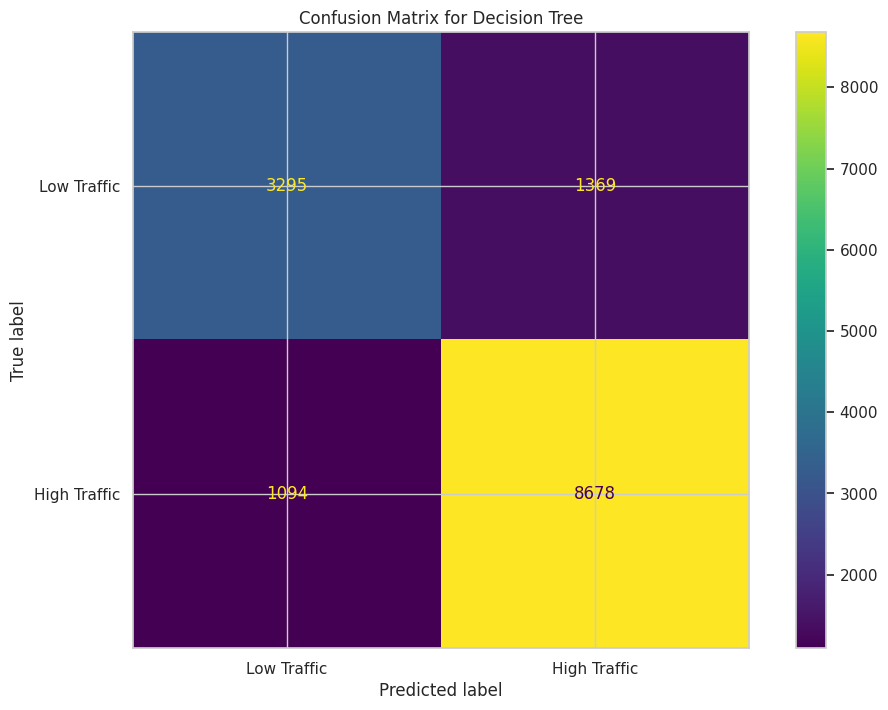

<Figure size 1200x800 with 0 Axes>

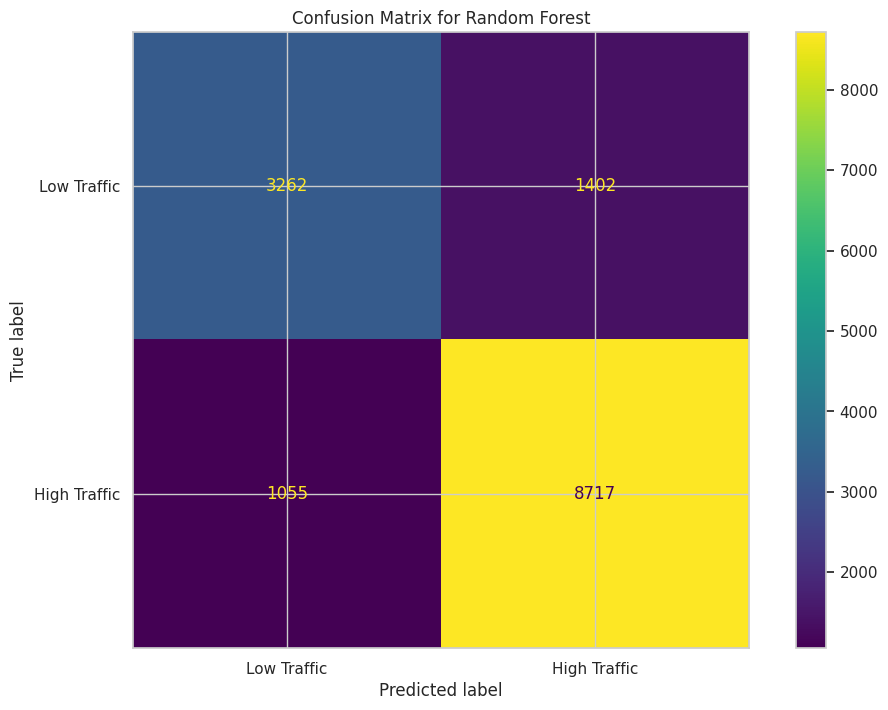

<Figure size 1200x800 with 0 Axes>

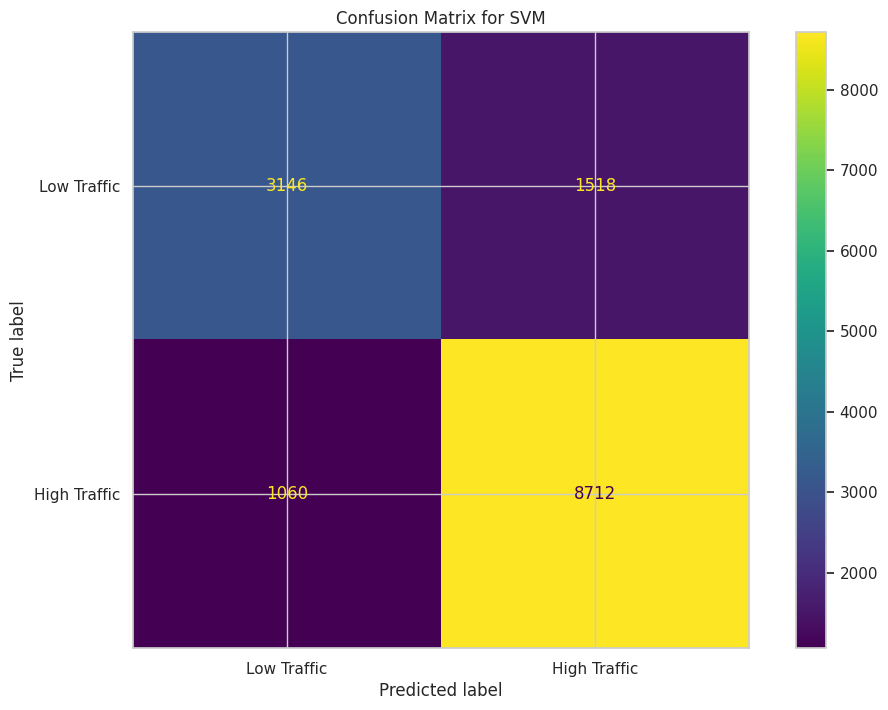

<Figure size 1200x800 with 0 Axes>

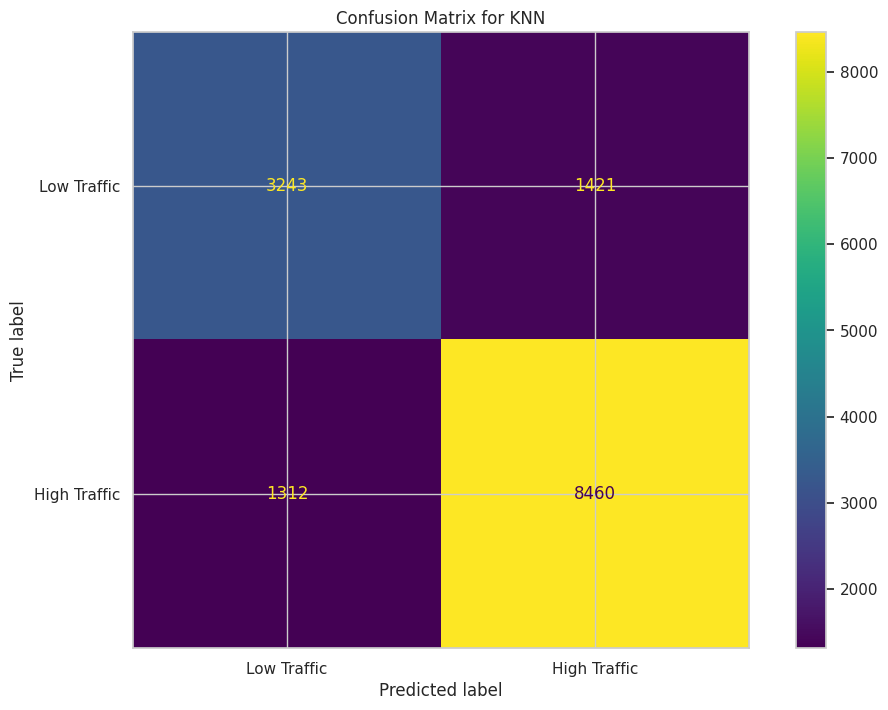

<Figure size 1200x800 with 0 Axes>

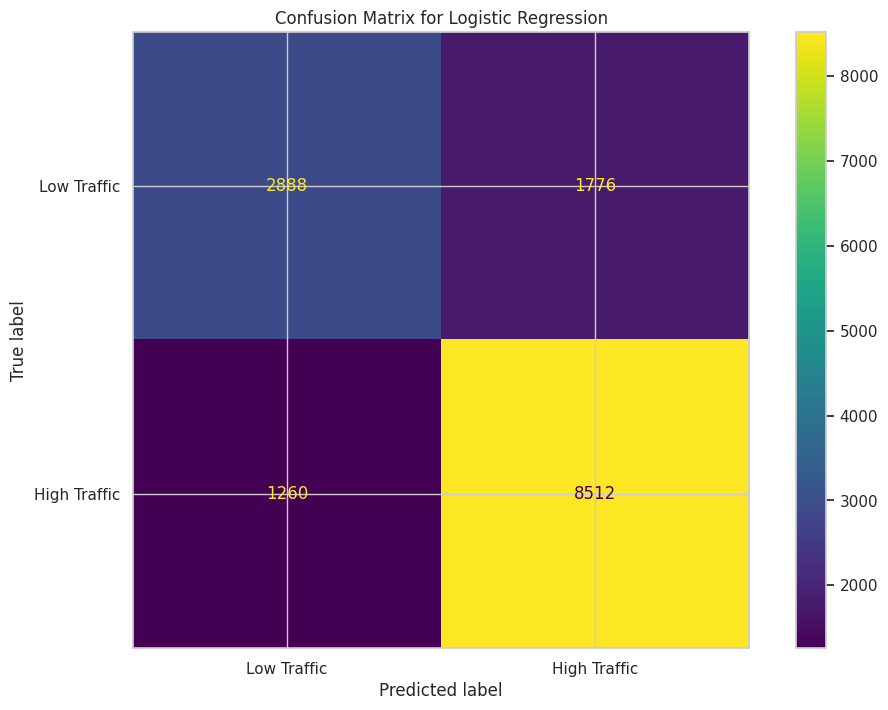

<Figure size 1200x800 with 0 Axes>

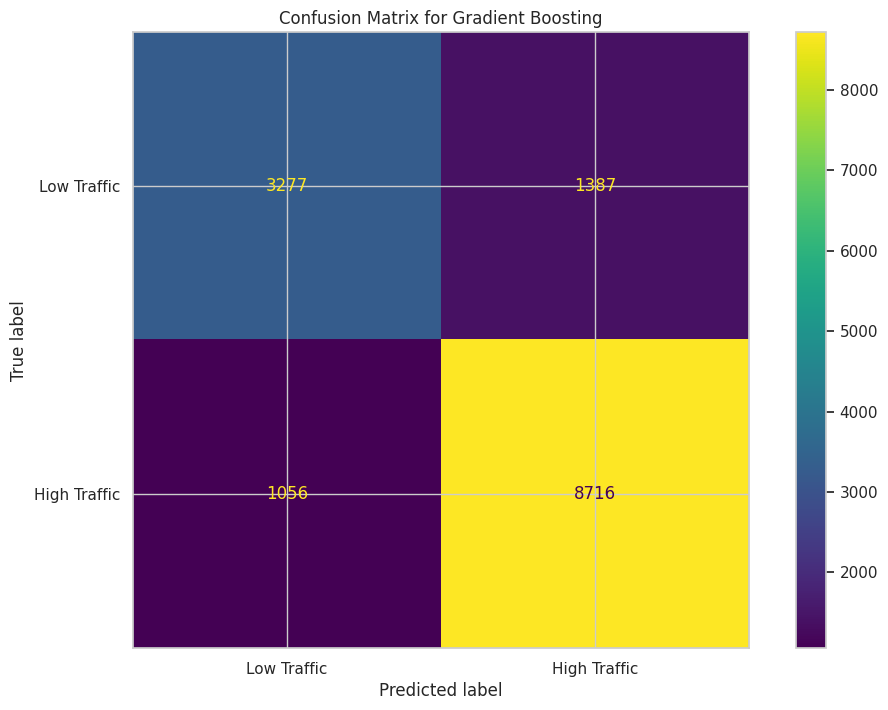

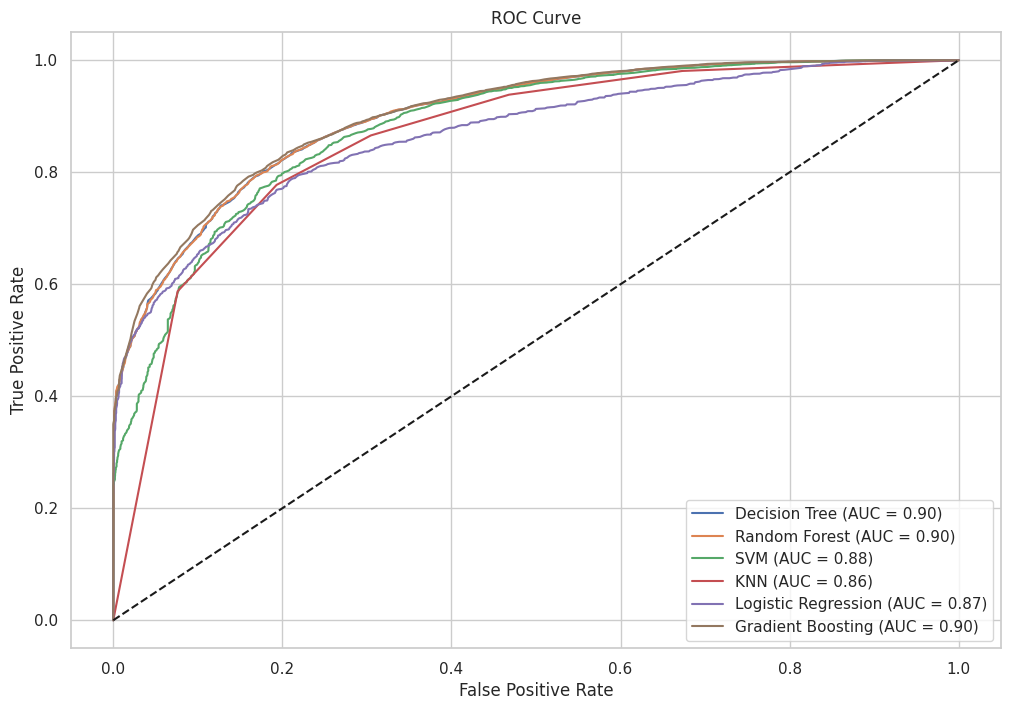

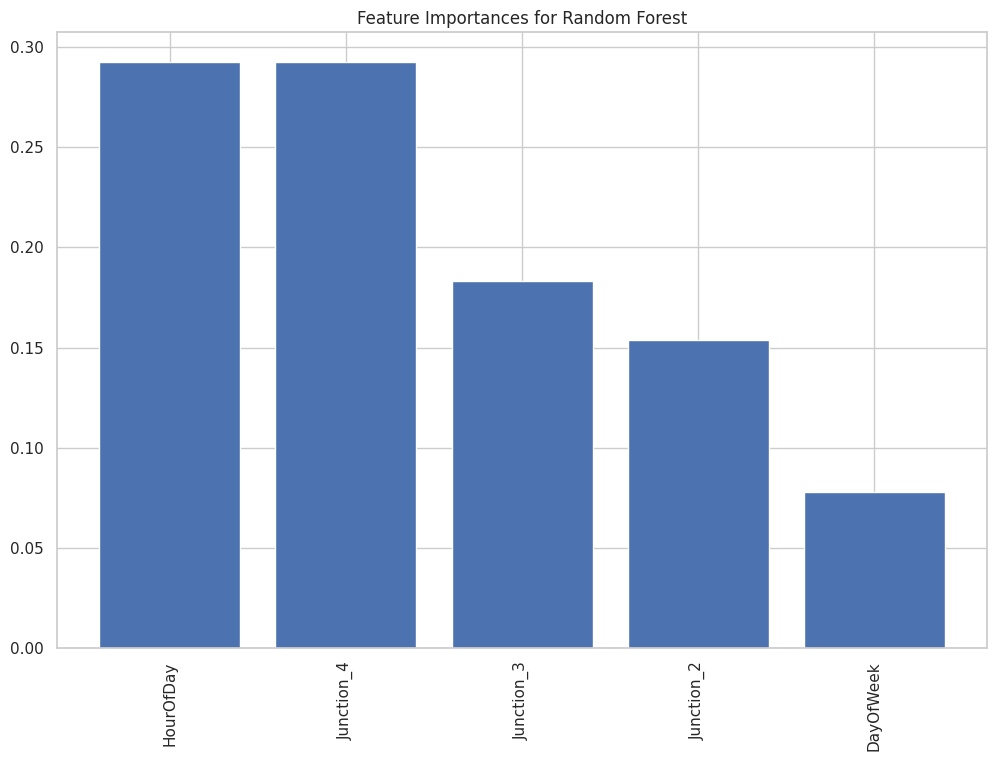

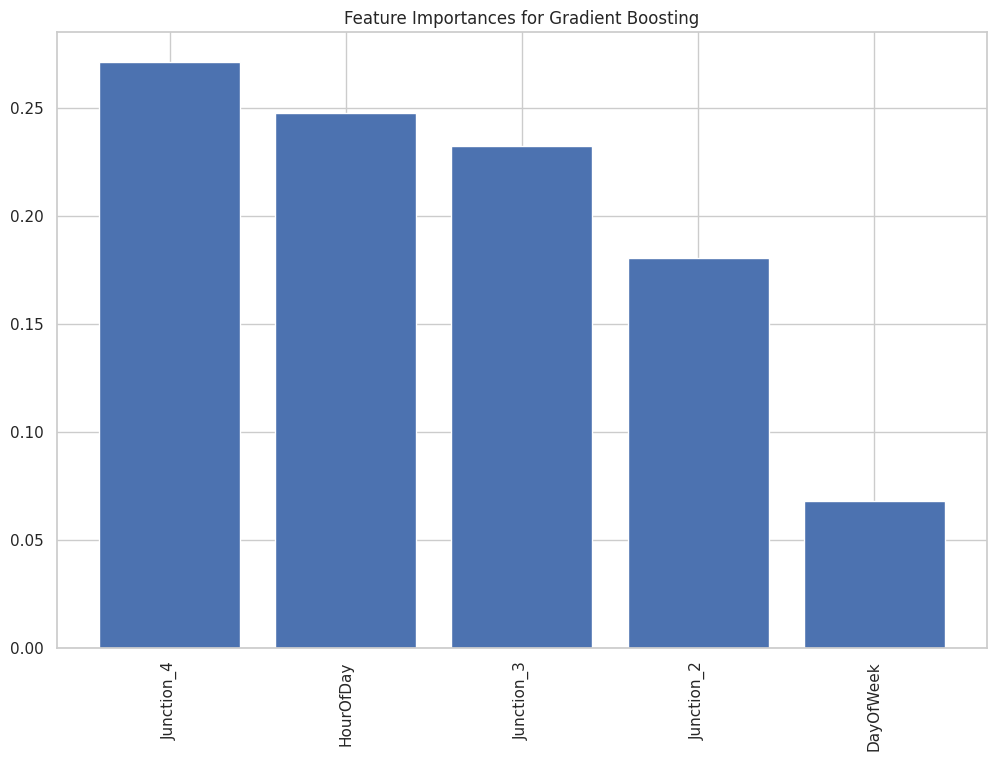


Model Comparison Table:
| Model               |   Accuracy |   Log Loss |   Brier Score |   Precision |   Recall |   F1-Score |
|:--------------------|-----------:|-----------:|--------------:|------------:|---------:|-----------:|
| Decision Tree       |   0.829385 |   0.382967 |      0.11787  |    0.827232 | 0.829385 |   0.827977 |
| Random Forest       |   0.8298   |   0.383083 |      0.117914 |    0.827257 | 0.8298   |   0.827997 |
| SVM                 |   0.821419 |   0.402575 |      0.127921 |    0.818131 | 0.821419 |   0.818853 |
| KNN                 |   0.810682 |   1.58291  |      0.136608 |    0.809593 | 0.810682 |   0.810087 |
| Logistic Regression |   0.789692 |   0.411249 |      0.138043 |    0.785005 | 0.789692 |   0.78624  |
| Gradient Boosting   |   0.83077  |   0.3576   |      0.116137 |    0.82833  | 0.83077  |   0.829066 |
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2

In [114]:
!pip install shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, log_loss, brier_score_loss, plot_confusion_matrix, mean_absolute_error
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import shap

# Feature Engineering
# Convert 'DateTime' to pandas datetime format
traffic_dataset['DateTime'] = pd.to_datetime(traffic_dataset['DateTime'])
# This step is essential to ensure that the 'DateTime' column is in a datetime format, allowing us to extract specific date and time features.

# Extract hour of the day and day of the week from 'DateTime'
traffic_dataset['HourOfDay'] = traffic_dataset['DateTime'].dt.hour
traffic_dataset['DayOfWeek'] = traffic_dataset['DateTime'].dt.dayofweek
# Extracting these features helps us understand the temporal patterns in traffic data, which are critical for accurate prediction.

# Encode categorical variable 'Junction' using one-hot encoding
traffic_dataset = pd.get_dummies(traffic_dataset, columns=['Junction'], drop_first=True)
# One-hot encoding transforms the categorical 'Junction' variable into binary columns, making it suitable for machine learning models.

# Define features and target
features = ['HourOfDay', 'DayOfWeek'] + [col for col in traffic_dataset.columns if col.startswith('Junction_')]
target = 'Vehicles'
threshold = 10  # Define threshold for classifying traffic level
# We choose these features based on their potential impact on traffic levels. The threshold helps categorize traffic as high or low.

# Create a new binary target column 'TrafficLevel'
traffic_dataset['TrafficLevel'] = (traffic_dataset[target] > threshold).astype(int)
# This step converts the continuous target variable into a binary classification problem, simplifying the model training.

# Split the data into training and testing sets
train_data, test_data = train_test_split(traffic_dataset, test_size=0.3, random_state=42)
X_train, y_train = train_data[features], train_data['TrafficLevel']
X_test, y_test = test_data[features], test_data['TrafficLevel']
# Splitting the data ensures that we can evaluate our model on unseen data, providing a realistic measure of its performance.

# Initialize classifiers
classifiers = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42, probability=True),
    'KNN': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=200),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}
# Initializing multiple classifiers allows us to compare different algorithms and find the best model for our problem.

# Train and evaluate classifiers
results = {}
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)  # Train classifier
    predictions = clf.predict(X_test)  # Make predictions
    accuracy = accuracy_score(y_test, predictions)  # Calculate accuracy
    logloss = log_loss(y_test, clf.predict_proba(X_test))  # Calculate log loss
    brier_score = brier_score_loss(y_test, clf.predict_proba(X_test)[:, 1])  # Calculate Brier score
    report = classification_report(y_test, predictions, output_dict=True)  # Generate classification report
    results[name] = {
        'model': clf,
        'accuracy': accuracy,
        'logloss': logloss,
        'brier_score': brier_score,
        'report': report,
        'predictions': predictions
    }
# We train and evaluate each classifier to understand its performance on our test data, comparing accuracy, log loss, and Brier score.

# Plot confusion matrix for each classifier
for name, result in results.items():
    plt.figure()
    plot_confusion_matrix(result['model'], X_test, y_test, display_labels=['Low Traffic', 'High Traffic'])
    plt.title(f'Confusion Matrix for {name}')
    plt.show()
# Plotting the confusion matrix helps us visualize the performance of our classifiers, showing true vs. predicted classes.

# Plot ROC Curve and compute AUC for each classifier
plt.figure()
for name, result in results.items():
    probas = result['model'].predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, probas)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()
# The ROC curve and AUC score provide insight into the classifiers' ability to distinguish between classes, which is crucial for imbalanced datasets.

# Feature Importance for Tree-Based Models
for name in ['Random Forest', 'Gradient Boosting']:
    if name in results:
        importances = results[name]['model'].feature_importances_
        indices = np.argsort(importances)[::-1]
        plt.figure()
        plt.title(f'Feature Importances for {name}')
        plt.bar(range(len(importances)), importances[indices], align='center')
        plt.xticks(range(len(importances)), [features[i] for i in indices], rotation=90)
        plt.show()
# Analyzing feature importance helps us understand which features contribute most to the model's predictions, guiding future feature engineering efforts.

# Compare models with a table
comparison_table = pd.DataFrame({
    'Model': [name for name in results.keys()],
    'Accuracy': [result['accuracy'] for result in results.values()],
    'Log Loss': [result['logloss'] for result in results.values()],
    'Brier Score': [result['brier_score'] for result in results.values()],
    'Precision': [result['report']['weighted avg']['precision'] for result in results.values()],
    'Recall': [result['report']['weighted avg']['recall'] for result in results.values()],
    'F1-Score': [result['report']['weighted avg']['f1-score'] for result in results.values()],
})

print("\nModel Comparison Table:")
print(comparison_table.to_markdown(index=False))
# This comparison table provides a quick overview of each model's performance, making it easier to identify the best performing classifier.

# Hyperparameter tuning example for RandomForest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print(f'Best parameters: {grid_search.best_params_}')
print(f'Best cross-validation score: {grid_search.best_score_:.2f}')
# Hyperparameter tuning optimizes the model's parameters to improve performance. GridSearchCV helps automate this process, testing various combinations to find the best one.

# Cross-Validation with K-Fold
def evaluate_model_cv(model, X, y, cv=5):
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    print(f'Model: {model.__class__.__name__}')
    print(f'Cross-Validation Accuracy Scores: {scores}')
    print(f'Mean Accuracy: {scores.mean()}')
    print(f'Standard Deviation: {scores.std()}\n')

# Apply k-fold cross-validation to each classifier
for name, clf in classifiers.items():
    evaluate_model_cv(clf, X_train, y_train)
# Cross-validation provides a more reliable estimate of model performance by evaluating it on multiple subsets of the data, reducing the risk of overfitting.

# Temporal Validation
tscv = TimeSeriesSplit(n_splits=5)
for name, clf in classifiers.items():
    scores = cross_val_score(clf, X_train, y_train, cv=tscv, scoring='accuracy')
    print(f'Model: {name}')
    print(f'Temporal Cross-Validation Accuracy Scores: {scores}')
    print(f'Mean Accuracy: {scores.mean()}')
    print(f'Standard Deviation: {scores.std()}\n')
# Temporal validation is important for time-series data, ensuring that the model performs well on future data by evaluating it in a chronological split.

# Error Analysis
def analyze_errors_by_segment(predictions, actuals, segment):
    error_df = pd.DataFrame({'Predicted': predictions, 'Actual': actuals, 'Segment': segment})
    error_df['Error'] = error_df['Predicted'] - error_df['Actual']
    segment_errors = error_df.groupby('Segment')['Error'].mean()
    print(segment_errors)

for name, result in results.items():
    print(f'Error Analysis for {name}:')
    analyze_errors_by_segment(result['predictions'], y_test, test_data['HourOfDay'])
    analyze_errors_by_segment(result['predictions'], y_test, test_data['DayOfWeek'])
    print('\n')
# Analyzing errors by segment helps identify patterns or segments where the model performs poorly, guiding targeted improvements.


Majority class size: 11023, Minority class size: 22661


<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

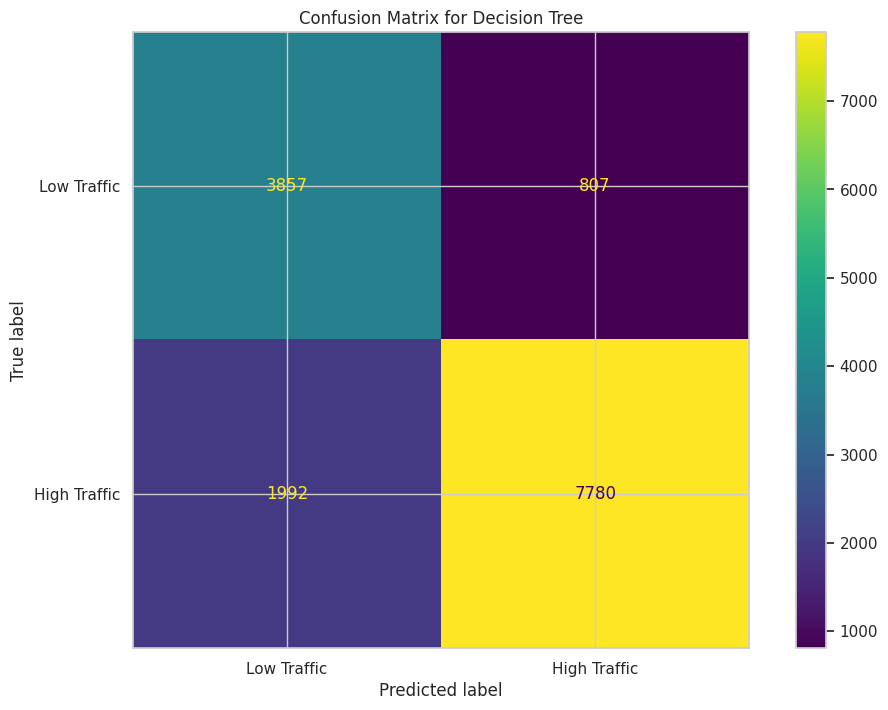

<Figure size 1200x800 with 0 Axes>

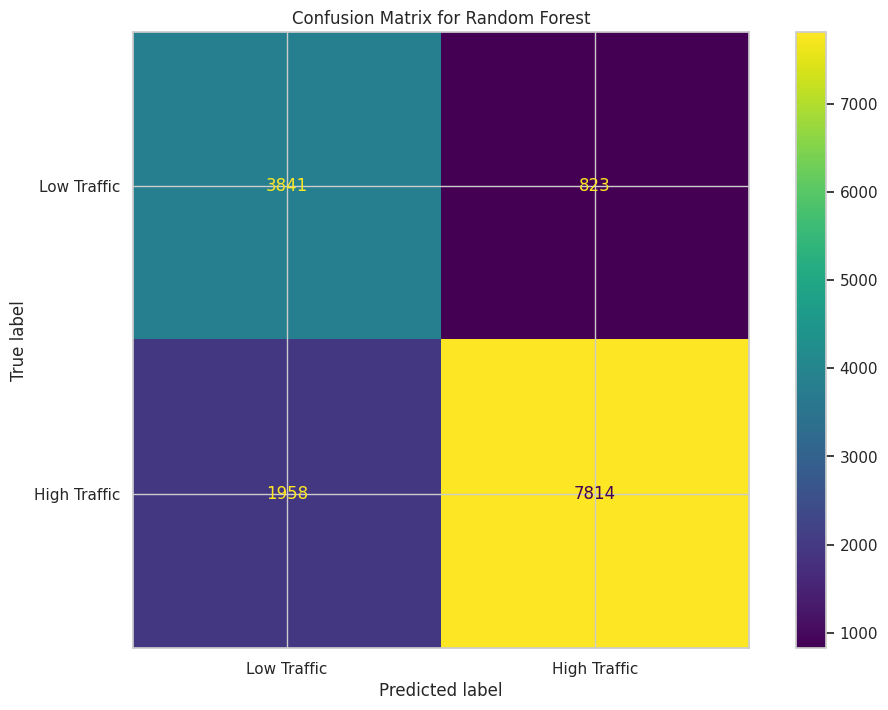

<Figure size 1200x800 with 0 Axes>

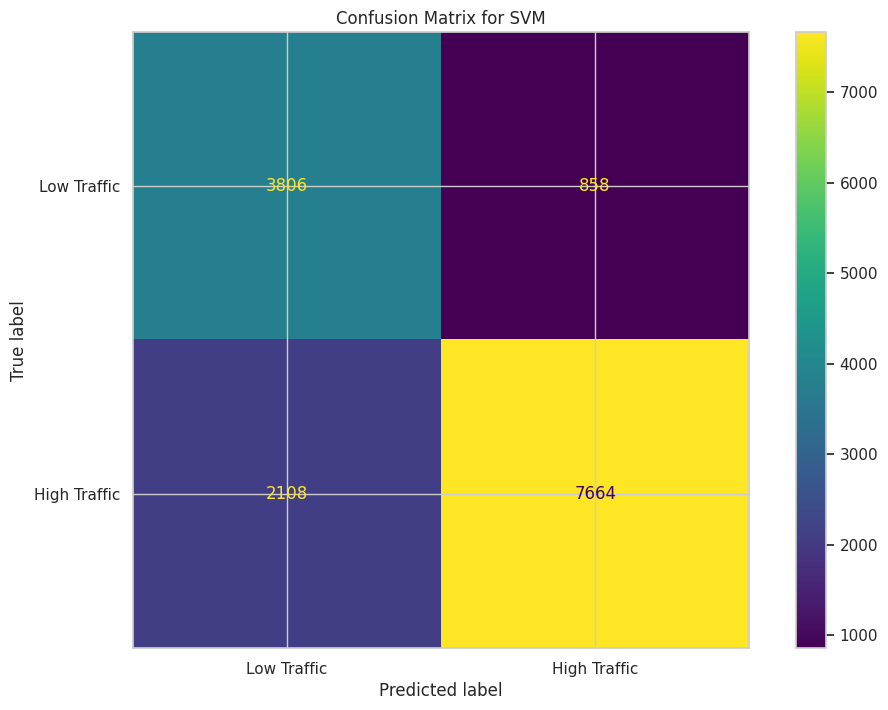

<Figure size 1200x800 with 0 Axes>

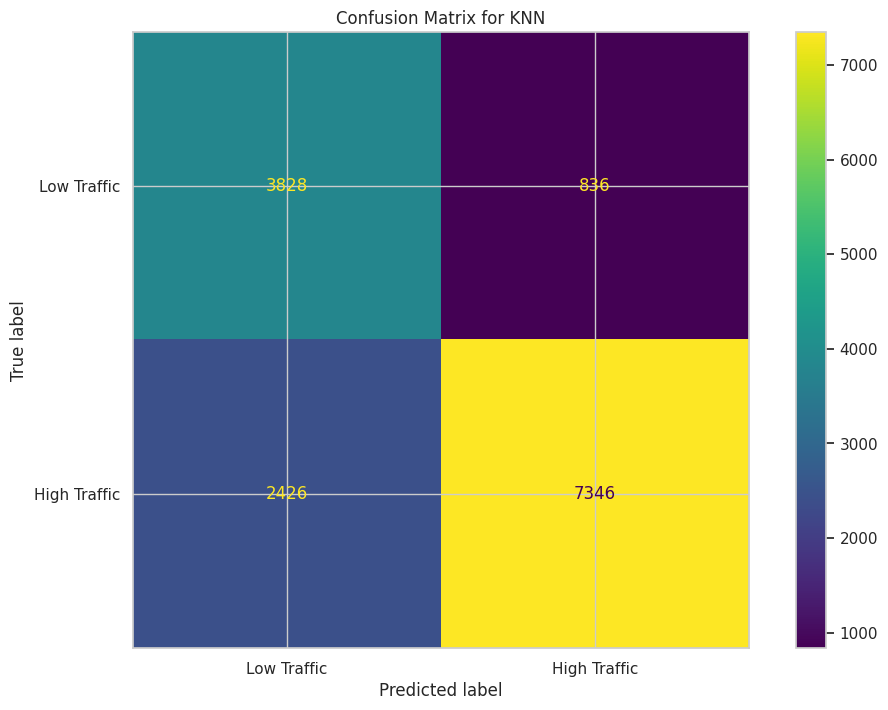

<Figure size 1200x800 with 0 Axes>

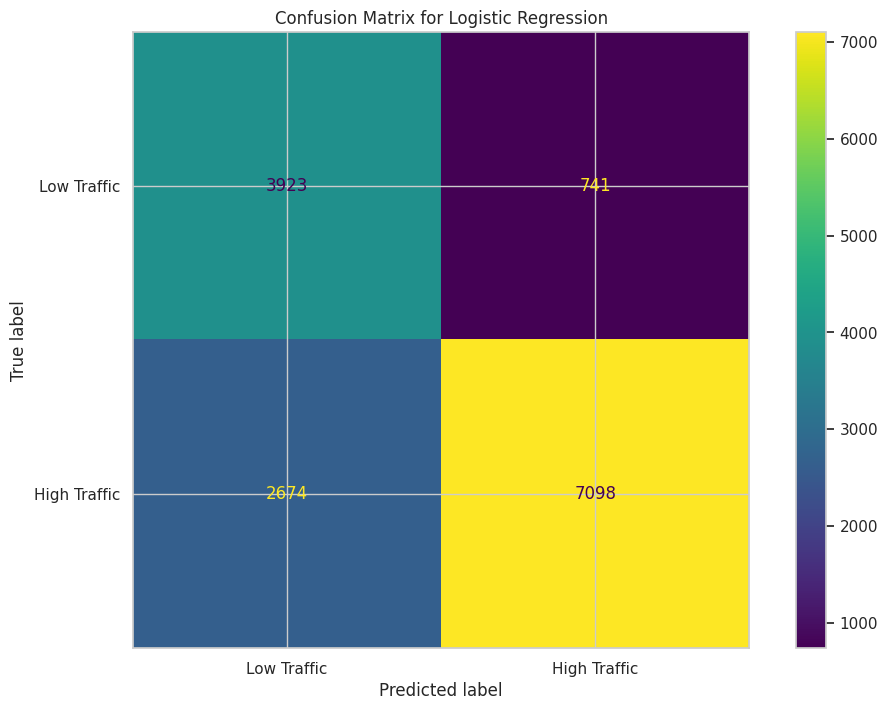

<Figure size 1200x800 with 0 Axes>

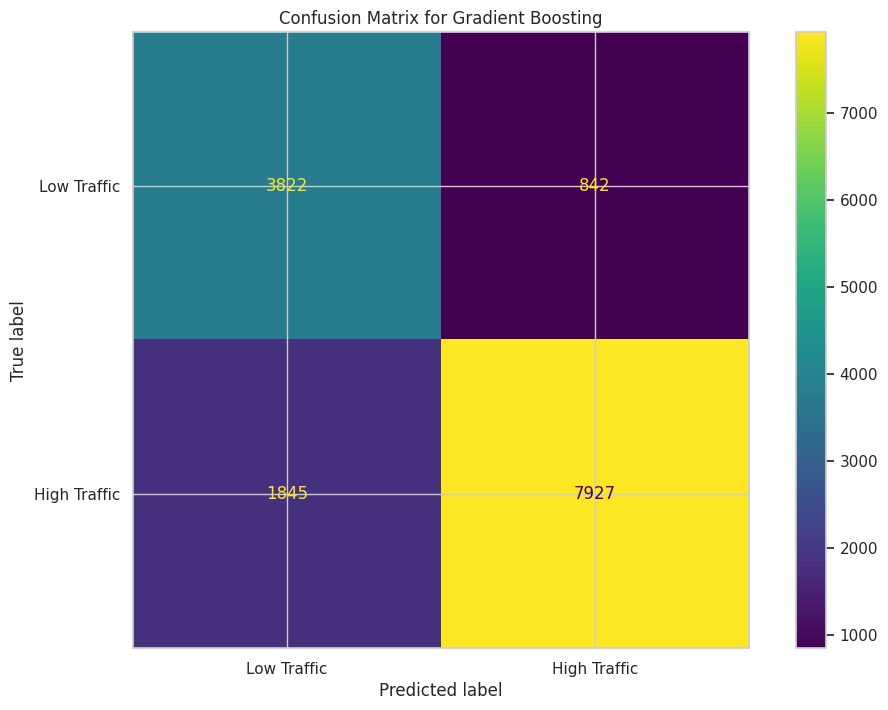

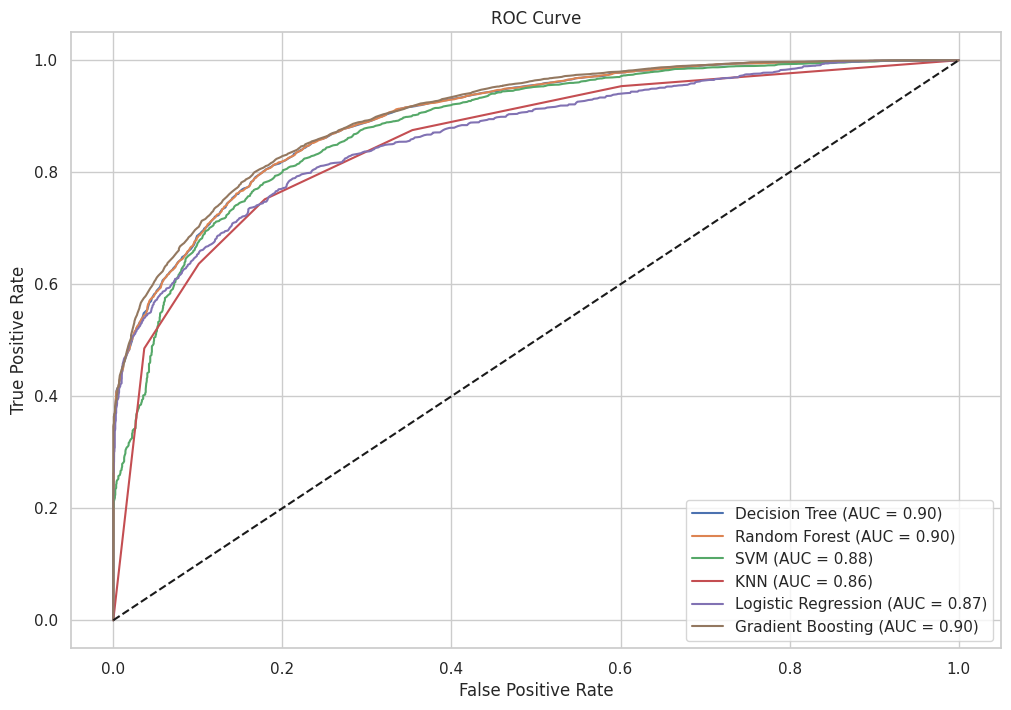

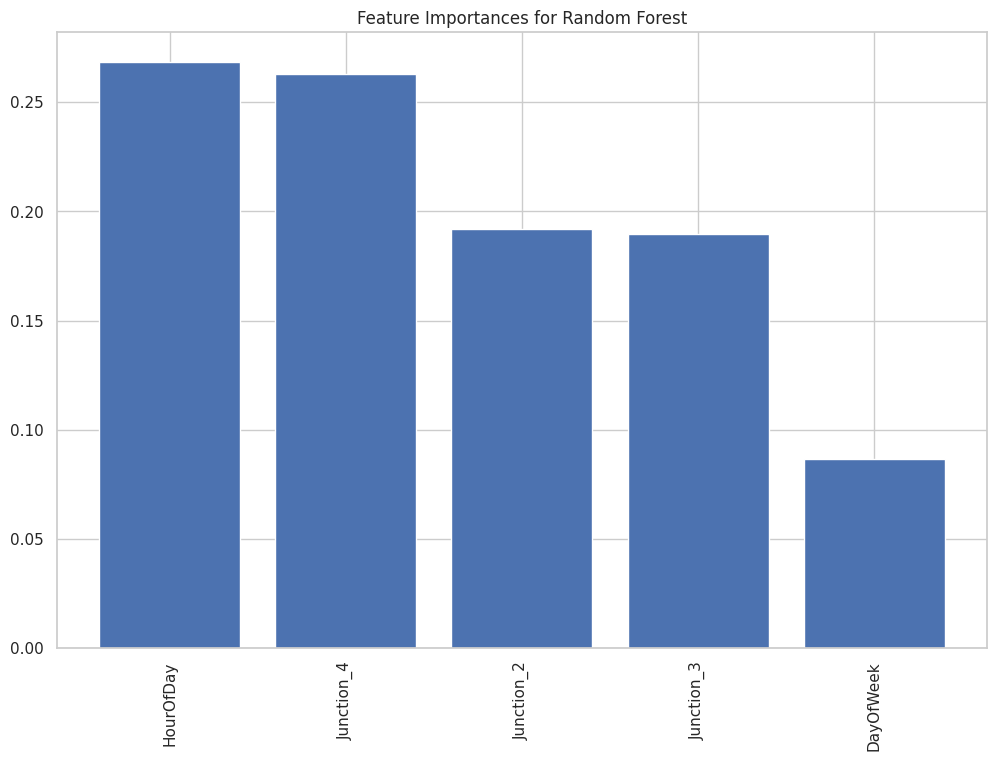

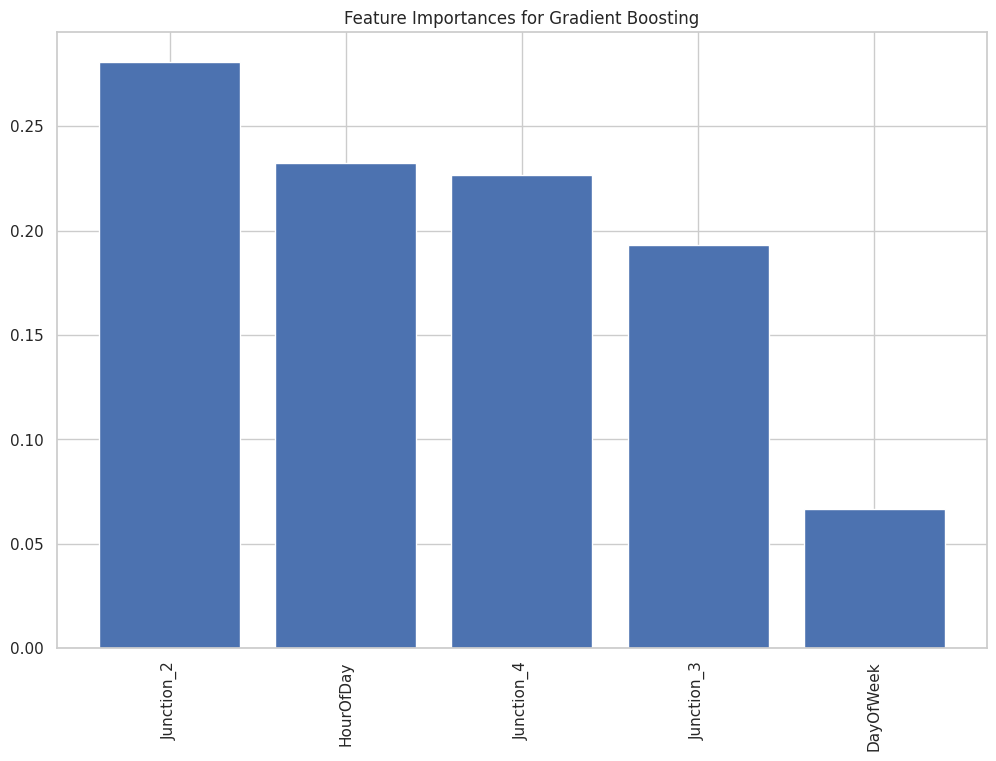


Model Comparison Table:
| Model               |   Accuracy |   Log Loss |   Brier Score |   Precision |   Recall |   F1-Score |
|:--------------------|-----------:|-----------:|--------------:|------------:|---------:|-----------:|
| Decision Tree       |   0.80611  |   0.447702 |      0.13146  |    0.826352 | 0.80611  |   0.81078  |
| Random Forest       |   0.807357 |   0.447931 |      0.1315   |    0.826411 | 0.807357 |   0.811867 |
| SVM                 |   0.794541 |   0.445043 |      0.144188 |    0.816688 | 0.794541 |   0.799662 |
| KNN                 |   0.774037 |   1.81861  |      0.158459 |    0.805508 | 0.774037 |   0.780485 |
| Logistic Regression |   0.763439 |   0.447204 |      0.152389 |    0.805056 | 0.763439 |   0.770759 |
| Gradient Boosting   |   0.813868 |   0.389014 |      0.128127 |    0.829817 | 0.813868 |   0.817869 |
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2

In [126]:
# Feature Engineering

# Convert 'DateTime' to pandas datetime format
traffic_dataset['DateTime'] = pd.to_datetime(traffic_dataset['DateTime'])
# This step is essential to ensure that the 'DateTime' column is in a datetime format, allowing us to extract specific date and time features.

# Extract hour of the day and day of the week from 'DateTime'
traffic_dataset['HourOfDay'] = traffic_dataset['DateTime'].dt.hour
traffic_dataset['DayOfWeek'] = traffic_dataset['DateTime'].dt.dayofweek
# Extracting these features helps us understand the temporal patterns in traffic data, which are critical for accurate prediction.

# Encode categorical variable 'Junction' using one-hot encoding
traffic_dataset = pd.get_dummies(traffic_dataset, columns=['Junction'], drop_first=True)
# One-hot encoding transforms the categorical 'Junction' variable into binary columns, making it suitable for machine learning models.

# Define features and target
features = ['HourOfDay', 'DayOfWeek'] + [col for col in traffic_dataset.columns if col.startswith('Junction_')]
target = 'Vehicles'
threshold = 10  # Define threshold for classifying traffic level
# We choose these features based on their potential impact on traffic levels. The threshold helps categorize traffic as high or low.

# Create a new binary target column 'TrafficLevel'
traffic_dataset['TrafficLevel'] = (traffic_dataset[target] > threshold).astype(int)
# This step converts the continuous target variable into a binary classification problem, simplifying the model training.

# Split the data into training and testing sets
train_data, test_data = train_test_split(traffic_dataset, test_size=0.3, random_state=42)
X_train, y_train = train_data[features], train_data['TrafficLevel']
X_test, y_test = test_data[features], test_data['TrafficLevel']
# Splitting the data ensures that we can evaluate our model on unseen data, providing a realistic measure of its performance.

# Separate majority and minority classes
majority_class = train_data[train_data.TrafficLevel == 0]
minority_class = train_data[train_data.TrafficLevel == 1]
# Separating the classes is a prerequisite for downsampling the minority class to balance the dataset.

# Check sizes of majority and minority classes
print(f'Majority class size: {len(majority_class)}, Minority class size: {len(minority_class)}')
# It's important to know the size of each class to understand the imbalance and decide on the resampling strategy.

# Downsample minority class
from sklearn.utils import resample
minority_downsampled = resample(minority_class, 
                                replace=False,  # sample without replacement
                                n_samples=len(majority_class),  # to match majority class
                                random_state=42)  # reproducible results
# Downsampling the minority class helps balance the dataset, making it more suitable for training models that perform well on imbalanced data.

# Combine majority class with downsampled minority class
downsampled_train_data = pd.concat([majority_class, minority_downsampled])
# Combining the downsampled minority class with the majority class results in a balanced training set.

# Separate features and target
X_train_downsampled = downsampled_train_data[features]
y_train_downsampled = downsampled_train_data['TrafficLevel']
# We separate the features and target again for the downsampled training data.

# Initialize classifiers
classifiers = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42, probability=True),
    'KNN': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=200),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}
# Initializing multiple classifiers allows us to compare different algorithms and find the best model for our problem.

# Train and evaluate classifiers
results = {}
for name, clf in classifiers.items():
    clf.fit(X_train_downsampled, y_train_downsampled)  # Train classifier
    predictions = clf.predict(X_test)  # Make predictions
    accuracy = accuracy_score(y_test, predictions)  # Calculate accuracy
    logloss = log_loss(y_test, clf.predict_proba(X_test))  # Calculate log loss
    brier_score = brier_score_loss(y_test, clf.predict_proba(X_test)[:, 1])  # Calculate Brier score
    report = classification_report(y_test, predictions, output_dict=True)  # Generate classification report
    results[name] = {
        'model': clf,
        'accuracy': accuracy,
        'logloss': logloss,
        'brier_score': brier_score,
        'report': report,
        'predictions': predictions
    }
# We train and evaluate each classifier on the downsampled dataset to see how balancing the classes affects performance.

# Plot confusion matrix
for name, result in results.items():
    plt.figure()
    plot_confusion_matrix(result['model'], X_test, y_test, display_labels=['Low Traffic', 'High Traffic'])
    plt.title(f'Confusion Matrix for {name}')
    plt.show()
# Plotting the confusion matrix helps us visualize the performance of our classifiers, showing true vs. predicted classes.

# Plot ROC Curve and compute AUC
plt.figure()
for name, result in results.items():
    probas = result['model'].predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, probas)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()
# The ROC curve and AUC score provide insight into the classifiers' ability to distinguish between classes, which is crucial for imbalanced datasets.

# Feature Importance for Tree-Based Models
for name in ['Random Forest', 'Gradient Boosting']:
    if name in results:
        importances = results[name]['model'].feature_importances_
        indices = np.argsort(importances)[::-1]
        plt.figure()
        plt.title(f'Feature Importances for {name}')
        plt.bar(range(len(importances)), importances[indices], align='center')
        plt.xticks(range(len(importances)), [features[i] for i in indices], rotation=90)
        plt.show()
# Analyzing feature importance helps us understand which features contribute most to the model's predictions, guiding future feature engineering efforts.

# Compare models with a table
comparison_table = pd.DataFrame({
    'Model': [name for name in results.keys()],
    'Accuracy': [result['accuracy'] for result in results.values()],
    'Log Loss': [result['logloss'] for result in results.values()],
    'Brier Score': [result['brier_score'] for result in results.values()],
    'Precision': [result['report']['weighted avg']['precision'] for result in results.values()],
    'Recall': [result['report']['weighted avg']['recall'] for result in results.values()],
    'F1-Score': [result['report']['weighted avg']['f1-score'] for result in results.values()],
})

print("\nModel Comparison Table:")
print(comparison_table.to_markdown(index=False))
# This comparison table provides a quick overview of each model's performance, making it easier to identify the best performing classifier.

# Hyperparameter tuning example for RandomForest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_downsampled, y_train_downsampled)

print(f'Best parameters: {grid_search.best_params_}')
print(f'Best cross-validation score: {grid_search.best_score_:.2f}')
# Hyperparameter tuning optimizes the model's parameters to improve performance. GridSearchCV helps automate this process, testing various combinations to find the best one.

# Cross-Validation with K-Fold
def evaluate_model_cv(model, X, y, cv=5):
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    print(f'Model: {model.__class__.__name__}')
    print(f'Cross-Validation Accuracy Scores: {scores}')
    print(f'Mean Accuracy: {scores.mean()}')
    print(f'Standard Deviation: {scores.std()}\n')

# Apply k-fold cross-validation to each classifier
for name, clf in classifiers.items():
    evaluate_model_cv(clf, X_train_downsampled, y_train_downsampled)
# Cross-validation provides a more reliable estimate of model performance by evaluating it on multiple subsets of the data, reducing the risk of overfitting.

# Temporal Validation
tscv = TimeSeriesSplit(n_splits=5)
for name, clf in classifiers.items():
    scores = cross_val_score(clf, X_train_downsampled, y_train_downsampled, cv=tscv, scoring='accuracy')
    print(f'Model: {name}')
    print(f'Temporal Cross-Validation Accuracy Scores: {scores}')
    print(f'Mean Accuracy: {scores.mean()}')
    print(f'Standard Deviation: {scores.std()}\n')
# Temporal validation is important for time-series data, ensuring that the model performs well on future data by evaluating it in a chronological split.

# Error Analysis
def analyze_errors_by_segment(predictions, actuals, segment):
    error_df = pd.DataFrame({'Predicted': predictions, 'Actual': actuals, 'Segment': segment})
    error_df['Error'] = error_df['Predicted'] - error_df['Actual']
    segment_errors = error_df.groupby('Segment')['Error'].mean()
    print(segment_errors)

for name, result in results.items():
    print(f'Error Analysis for {name}:')
    analyze_errors_by_segment(result['predictions'], y_test, test_data['HourOfDay'])
    analyze_errors_by_segment(result['predictions'], y_test, test_data['DayOfWeek'])
    print('\n')
# Analyzing errors by segment helps identify patterns or segments where the model performs poorly, guiding targeted improvements.


In [26]:
# Feature Engineering
# Convert 'DateTime' to pandas datetime format
traffic_dataset['DateTime'] = pd.to_datetime(traffic_dataset['DateTime'])
# This step is essential to ensure that the 'DateTime' column is in a datetime format, allowing us to extract specific date and time features.

# Extract hour of the day and day of the week from 'DateTime'
traffic_dataset['HourOfDay'] = traffic_dataset['DateTime'].dt.hour
traffic_dataset['DayOfWeek'] = traffic_dataset['DateTime'].dt.dayofweek
# Extracting these features helps us understand the temporal patterns in traffic data, which are critical for accurate prediction.

# Encode categorical variable 'Junction' using one-hot encoding
traffic_dataset = pd.get_dummies(traffic_dataset, columns=['Junction'], drop_first=True)
# One-hot encoding transforms the categorical 'Junction' variable into binary columns, making it suitable for machine learning models.

# Define features and target
features = ['HourOfDay', 'DayOfWeek'] + [col for col in traffic_dataset.columns if col.startswith('Junction_')]
target = 'Vehicles'
threshold = 10  # Define threshold for classifying traffic level
# We choose these features based on their potential impact on traffic levels. The threshold helps categorize traffic as high or low.

# Create a new binary target column 'TrafficLevel'
traffic_dataset['TrafficLevel'] = (traffic_dataset[target] > threshold).astype(int)
# This step converts the continuous target variable into a binary classification problem, simplifying the model training.

# Split the data into training and testing sets
train_data, test_data = train_test_split(traffic_dataset, test_size=0.3, random_state=42)
X_train, y_train = train_data[features], train_data['TrafficLevel']
X_test, y_test = test_data[features], test_data['TrafficLevel']
# Splitting the data ensures that we can evaluate our model on unseen data, providing a realistic measure of its performance.

# Function to calculate various metrics
def calculate_metrics(model, X_train, y_train, X_test, y_test):
    metrics = {}

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Metrics for Training Set
    metrics['train_accuracy'] = accuracy_score(y_train, y_train_pred)
    metrics['train_balanced_accuracy'] = balanced_accuracy_score(y_train, y_train_pred)
    cm_train = confusion_matrix(y_train, y_train_pred)
    metrics['train_sensitivity'] = cm_train[1, 1] / (cm_train[1, 0] + cm_train[1, 1])
    metrics['train_specificity'] = cm_train[0, 0] / (cm_train[0, 0] + cm_train[0, 1])

    # Metrics for Testing Set
    metrics['test_accuracy'] = accuracy_score(y_test, y_test_pred)
    metrics['test_balanced_accuracy'] = balanced_accuracy_score(y_test, y_test_pred)
    cm_test = confusion_matrix(y_test, y_test_pred)
    metrics['test_sensitivity'] = cm_test[1, 1] / (cm_test[1, 0] + cm_test[1, 1])
    metrics['test_specificity'] = cm_test[0, 0] / (cm_test[0, 0] + cm_test[0, 1])

    return metrics
# This function calculates a variety of metrics for both the training and testing sets, helping us understand the model's performance in detail.

# Initialize classifiers
classifiers = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42, probability=True),
    'KNN': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=200),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}
# Initializing multiple classifiers allows us to compare different algorithms and find the best model for our problem.

# Store results for original dataset
original_results = {}

# Train and evaluate classifiers on original dataset
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)  # Train classifier
    original_results[name] = calculate_metrics(clf, X_train, y_train, X_test, y_test)
# We train and evaluate each classifier on the original dataset to understand its performance before any data balancing.

# Downsampling the minority class
# Separate majority and minority classes
majority_class = train_data[train_data.TrafficLevel == 0]
minority_class = train_data[train_data.TrafficLevel == 1]

# Check sizes of majority and minority classes
print(f'Majority class size: {len(majority_class)}, Minority class size: {len(minority_class)}')
# It's important to know the size of each class to understand the imbalance and decide on the resampling strategy.

# Downsample minority class
from sklearn.utils import resample
minority_downsampled = resample(minority_class, 
                                replace=False,  # sample without replacement
                                n_samples=len(majority_class),  # to match majority class
                                random_state=42)  # reproducible results
# Downsampling the minority class helps balance the dataset, making it more suitable for training models that perform well on imbalanced data.

# Combine majority class with downsampled minority class
downsampled_train_data = pd.concat([majority_class, minority_downsampled])
# Combining the downsampled minority class with the majority class results in a balanced training set.

# Separate features and target
X_train_downsampled = downsampled_train_data[features]
y_train_downsampled = downsampled_train_data['TrafficLevel']
# We separate the features and target again for the downsampled training data.

# Store results for downsampled dataset
downsampled_results = {}

# Train and evaluate classifiers on downsampled dataset
for name, clf in classifiers.items():
    clf.fit(X_train_downsampled, y_train_downsampled)  # Train classifier
    downsampled_results[name] = calculate_metrics(clf, X_train_downsampled, y_train_downsampled, X_test, y_test)
# We train and evaluate each classifier on the downsampled dataset to see how balancing the classes affects performance.

# Print the results
def print_results(results, dataset_type):
    print(f"\nMetrics for {dataset_type} Dataset:")
    for model, metrics in results.items():
        print(f"\nModel: {model}")
        print(f"Training Accuracy: {metrics['train_accuracy']:.4f}")
        print(f"Training Balanced Accuracy: {metrics['train_balanced_accuracy']:.4f}")
        print(f"Training Sensitivity: {metrics['train_sensitivity']:.4f}")
        print(f"Training Specificity: {metrics['train_specificity']:.4f}")
        print(f"Testing Accuracy: {metrics['test_accuracy']:.4f}")
        print(f"Testing Balanced Accuracy: {metrics['test_balanced_accuracy']:.4f}")
        print(f"Testing Sensitivity: {metrics['test_sensitivity']:.4f}")
        print(f"Testing Specificity: {metrics['test_specificity']:.4f}")
# This function prints the performance metrics for each model, helping us compare the results across different datasets and classifiers.

# Print results for original and downsampled datasets
print_results(original_results, "Original")
print_results(downsampled_results, "Downsampled")
# Printing the results for both original and downsampled datasets allows us to compare the impact of class balancing on model performance.


Majority class size: 11023, Minority class size: 22661

Metrics for Original Dataset:

Model: Decision Tree
Training Accuracy: 0.8374
Training Balanced Accuracy: 0.8082
Training Sensitivity: 0.8926
Training Specificity: 0.7239
Testing Accuracy: 0.8294
Testing Balanced Accuracy: 0.7973
Testing Sensitivity: 0.8880
Testing Specificity: 0.7065

Model: Random Forest
Training Accuracy: 0.8374
Training Balanced Accuracy: 0.8067
Training Sensitivity: 0.8954
Training Specificity: 0.7180
Testing Accuracy: 0.8298
Testing Balanced Accuracy: 0.7957
Testing Sensitivity: 0.8920
Testing Specificity: 0.6994

Model: SVM
Training Accuracy: 0.8218
Training Balanced Accuracy: 0.7851
Training Sensitivity: 0.8912
Training Specificity: 0.6790
Testing Accuracy: 0.8214
Testing Balanced Accuracy: 0.7830
Testing Sensitivity: 0.8915
Testing Specificity: 0.6745

Model: KNN
Training Accuracy: 0.8159
Training Balanced Accuracy: 0.7868
Training Sensitivity: 0.8711
Training Specificity: 0.7025
Testing Accuracy: 0.8107


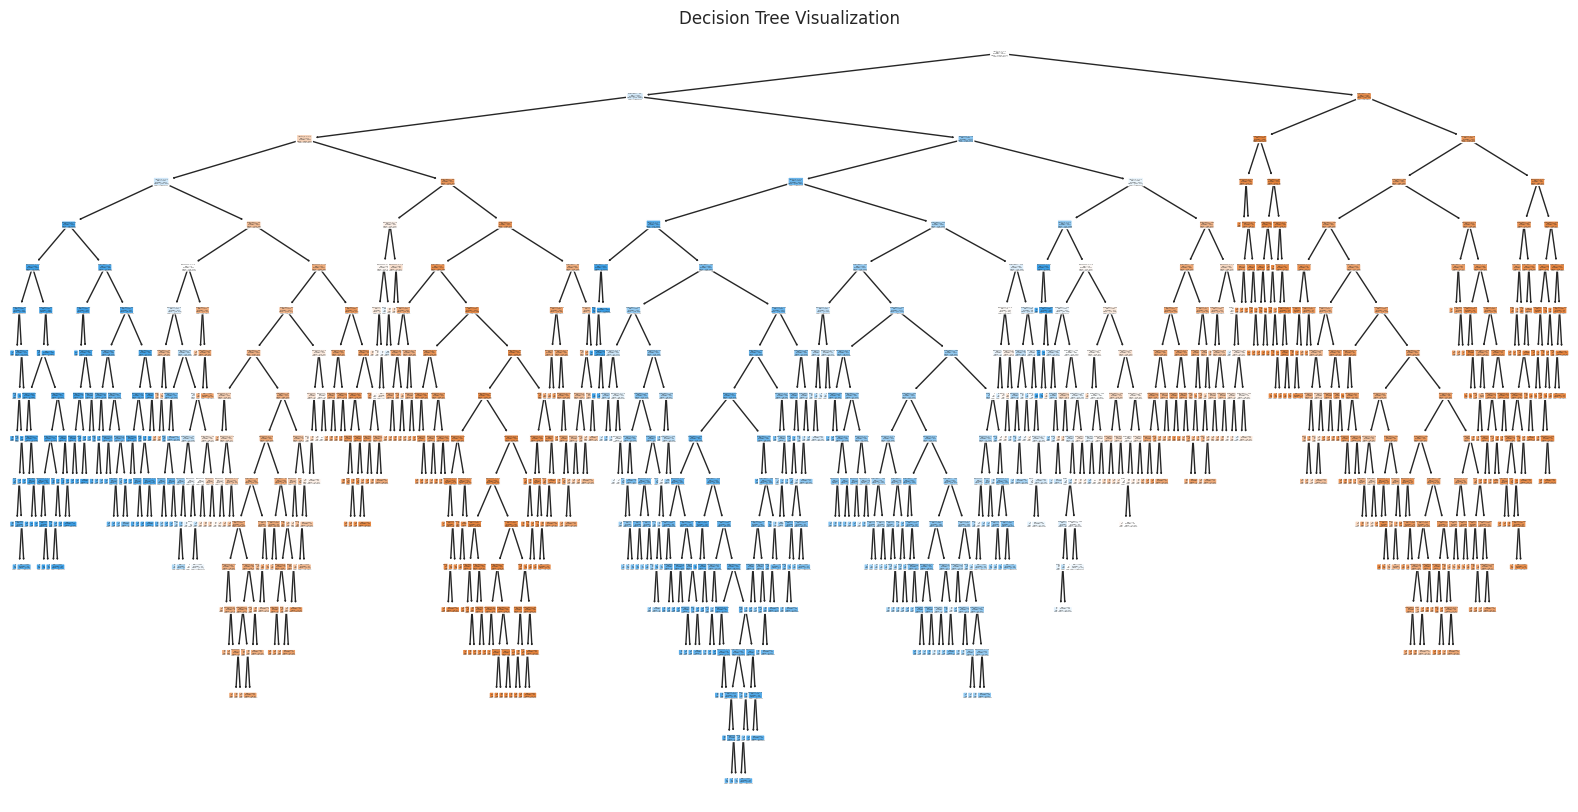

In [44]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Train the decision tree classifier
decision_tree = DecisionTreeClassifier(random_state=42)
# We initialize a Decision Tree classifier with a fixed random state for reproducibility.

decision_tree.fit(X_train_downsampled, y_train_downsampled)
# We fit the classifier to the downsampled training data. This helps the model learn from the balanced dataset.

# Plot the decision tree
plt.figure(figsize=(20, 10))
# We create a figure with specified dimensions to ensure the tree is large enough to be readable.

plot_tree(decision_tree, filled=True, feature_names=features, class_names=['Low Traffic', 'High Traffic'], rounded=True)
# We plot the decision tree. The parameters:
# - `filled=True`: colors the nodes to show different classes.
# - `feature_names=features`: labels the nodes with the feature names.
# - `class_names=['Low Traffic', 'High Traffic']`: labels the classes.
# - `rounded=True`: gives the nodes rounded corners for better aesthetics.

plt.title("Decision Tree Visualization")
# We set the title of the plot for clarity.

plt.show()
# Finally, we display the plot.



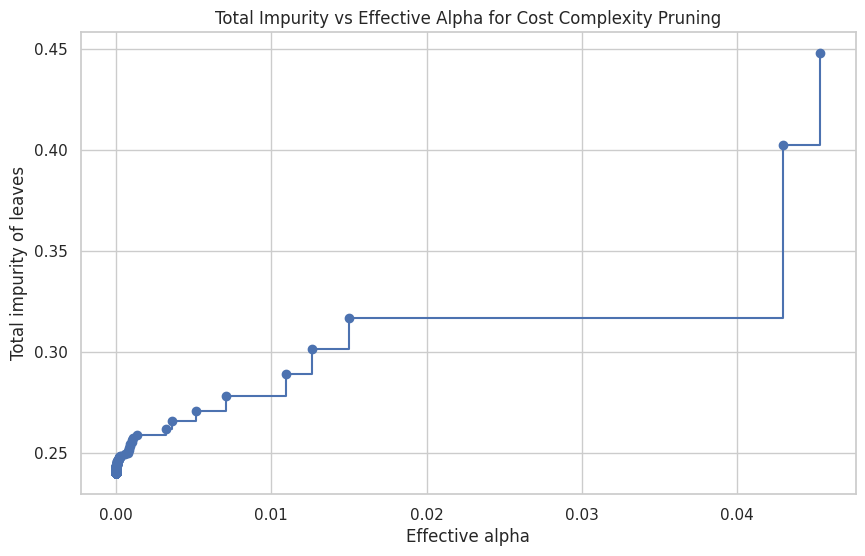

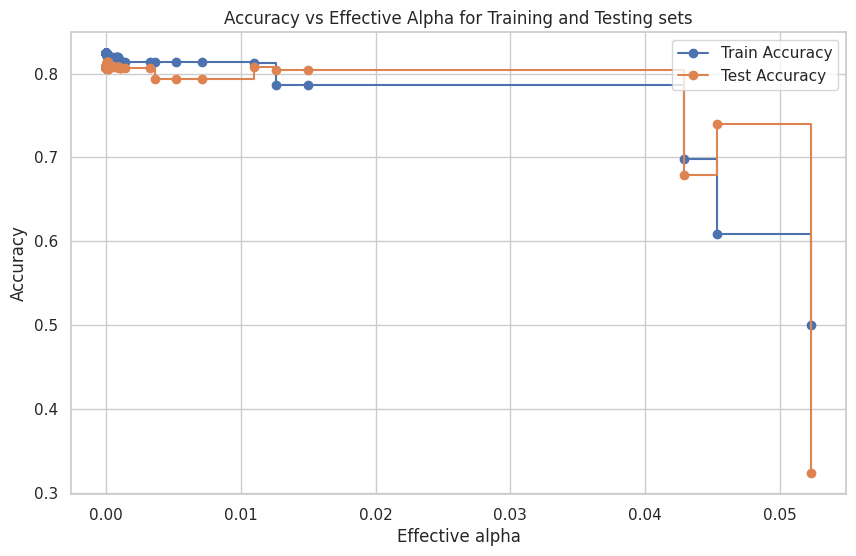

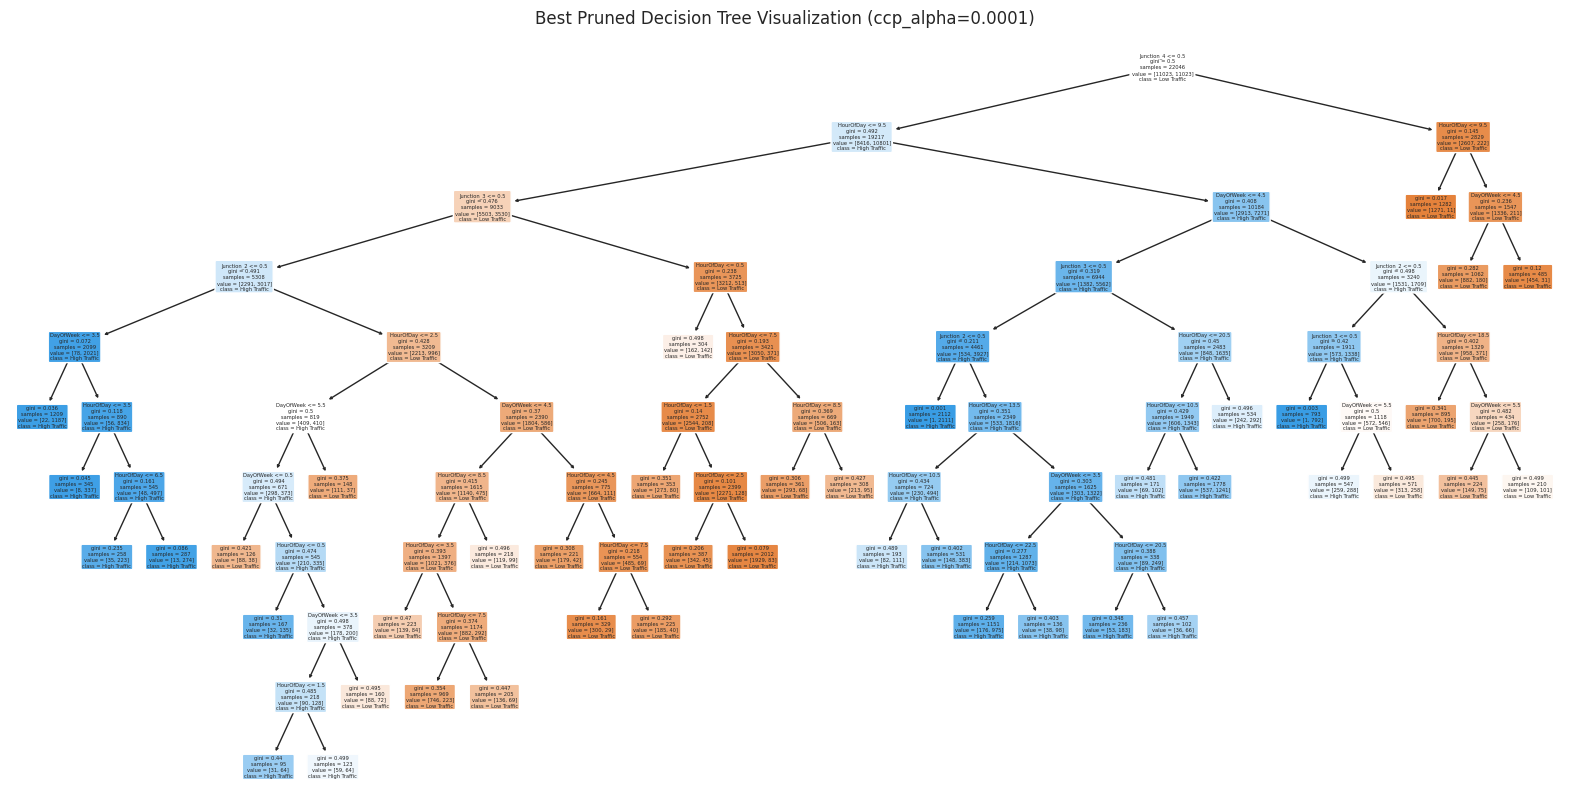

In [51]:
# Get the cost complexity pruning path
path = decision_tree.cost_complexity_pruning_path(X_train_downsampled, y_train_downsampled)
ccp_alphas = path.ccp_alphas
impurities = path.impurities
# The cost complexity pruning path provides the effective alphas and corresponding total impurities for the training set.
# This helps identify potential pruning points to avoid overfitting.

# Plot the total impurity vs effective alpha for pruning
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
plt.xlabel("Effective alpha")
plt.ylabel("Total impurity of leaves")
plt.title("Total Impurity vs Effective Alpha for Cost Complexity Pruning")
plt.show()
# This plot visualizes how the total impurity of the leaves changes with different effective alphas.
# It helps in understanding the impact of pruning on the model complexity and performance.

# Train and evaluate decision trees with different alphas
trees = []
for ccp_alpha in ccp_alphas:
    tree = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    tree.fit(X_train_downsampled, y_train_downsampled)
    trees.append(tree)
# Here, we train a series of decision trees using different values of ccp_alpha from the pruning path.
# This helps us find the optimal alpha that balances the trade-off between bias and variance.

# Evaluate the trees on the downsampled training set and the original testing set
train_scores = [tree.score(X_train_downsampled, y_train_downsampled) for tree in trees]
test_scores = [tree.score(X_test, y_test) for tree in trees]
# We calculate the accuracy of each pruned tree on both the training and testing datasets.
# This evaluation helps in selecting the tree that generalizes the best on unseen data.

# Plot training and testing scores
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, train_scores, marker='o', label="Train Accuracy", drawstyle="steps-post")
plt.plot(ccp_alphas, test_scores, marker='o', label="Test Accuracy", drawstyle="steps-post")
plt.xlabel("Effective alpha")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy vs Effective Alpha for Training and Testing sets")
plt.show()
# This plot shows how the accuracy on both training and testing sets changes with different values of alpha.
# It helps identify the alpha that results in the best performance on the test set, indicating the optimal level of pruning.

# Choose the tree with the highest test accuracy
best_index = np.argmax(test_scores)
best_tree = trees[best_index]
# We select the tree with the highest accuracy on the testing set as the best pruned tree.

# Plot the best pruned decision tree
plt.figure(figsize=(20, 10))
plot_tree(best_tree, filled=True, feature_names=features, class_names=['Low Traffic', 'High Traffic'], rounded=True)
plt.title(f"Best Pruned Decision Tree Visualization (ccp_alpha={ccp_alphas[best_index]:.4f})")
plt.show()
# Finally, we visualize the best pruned decision tree.
# This provides insights into the structure and decision rules of the optimal tree after pruning.


In [32]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Gradient Boosting
param_grid = {
    'n_estimators': [100, 200, 300],         # Number of boosting stages to be run
    'max_depth': [3, 5, 7],                  # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],         # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],           # Minimum number of samples required to be at a leaf node
    'learning_rate': [0.01, 0.05, 0.1]       # Learning rate shrinks the contribution of each tree
}
# The parameter grid defines the hyperparameters to be tuned and their possible values.

# Initialize GridSearchCV with GradientBoostingClassifier
grid_search = GridSearchCV(
    GradientBoostingClassifier(random_state=42), 
    param_grid, 
    cv=3,               # 3-fold cross-validation
    n_jobs=-1,          # Use all available cores
    verbose=2           # Verbose output for monitoring
)
# GridSearchCV is used to find the best combination of hyperparameters by exhaustively searching over the specified parameter grid.

grid_search.fit(X_train_downsampled, y_train_downsampled)
# Fit the GridSearchCV on the downsampled training data to find the best hyperparameters.

# Print the best hyperparameters and the best cross-validation score
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best cross-validation score: {grid_search.best_score_:.2f}')
# Output the best hyperparameters found and the corresponding cross-validation score.



Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation score: 0.82


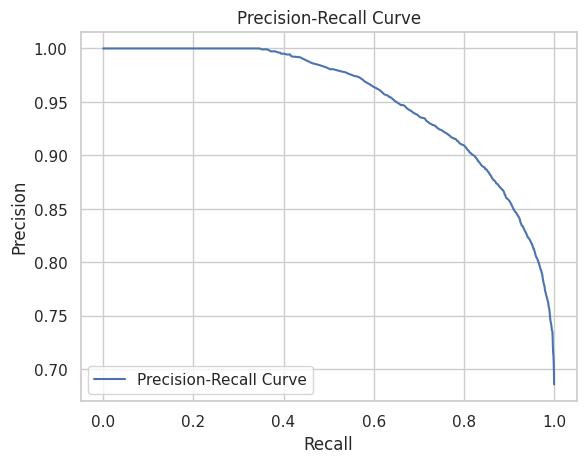

In [22]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Initialize and train the Gradient Boosting model
gradient_boosting_model = GradientBoostingClassifier(random_state=42)
gradient_boosting_model.fit(X_train_downsampled, y_train_downsampled)
# We initialize a Gradient Boosting classifier and fit it to the downsampled training data.
# This helps the model learn the patterns in the balanced dataset.

# Predict probabilities for the positive class
y_prob = gradient_boosting_model.predict_proba(X_test)[:, 1]
# We predict the probabilities for the positive class (High Traffic) on the test set.
# The output is an array of probabilities that the instances belong to the positive class.

# Calculate precision and recall
precision, recall, _ = precision_recall_curve(y_test, y_prob)
# We calculate precision and recall values at different thresholds using the true labels and predicted probabilities.

# Plot Precision-Recall Curve
plt.figure()
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()
# We plot the Precision-Recall curve.
# This curve helps us understand the trade-off between precision and recall for different decision thresholds.
# It is especially useful in imbalanced datasets to evaluate the performance of the classifier.



In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
import torch.utils.data as data
from torch.utils.data import Dataset
from torch.utils.data import Subset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split


import statsmodels.api as sm
import statsmodels.formula.api as smf           
import statsmodels.tsa.api as smt
import scipy.stats as scs
from statsmodels.graphics.api import qqplot

from itertools import product 
from tqdm.notebook import tqdm

In [66]:
# convert to datetime type
traffic_dataset['DateTime'] = pd.to_datetime(traffic_dataset['DateTime'])

# set datetime to index
traffic_dataset.set_index('DateTime',inplace=True)
junc1 = traffic_dataset[traffic_dataset['Junction']==1]
junc1.head()

Junction  Vehicles           ID  Year  Month  Date_no  \
DateTime                                                                     
2015-11-01 00:00:00         1        15  20151101001  2015     11        1   
2015-11-01 01:00:00         1        13  20151101011  2015     11        1   
2015-11-01 02:00:00         1        10  20151101021  2015     11        1   
2015-11-01 03:00:00         1         7  20151101031  2015     11        1   
2015-11-01 04:00:00         1         9  20151101041  2015     11        1   

                     Hour  
DateTime                   
2015-11-01 00:00:00     0  
2015-11-01 01:00:00     1  
2015-11-01 02:00:00     2  
2015-11-01 03:00:00     3  
2015-11-01 04:00:00     4

In [67]:
daily_junc1 = junc1.Vehicles.resample('D').mean()

In [68]:
# Defining a function that creates sequences and targets 
def generate_sequences(ts: pd.Series, tw: int, pw: int):
    '''
    df: Pandas Series of the univariate time-series
    tw: Training Window - Integer defining how many steps to look back
    pw: Prediction Window - Integer defining how many steps forward to predict

    returns: dictionary of sequences and targets for all sequences
    '''
    data = dict() # Store results into a dictionary
    L = len(ts)
    for i in range(L-tw):
        # Get current sequence  
        sequence = ts[i:i+tw].values
        sequence = np.reshape(sequence, (len(sequence),-1))
        # Get values right after the current sequence
        target = ts[i+tw:i+tw+pw].values
        target = np.reshape(target, (len(target),-1))
        data[i] = {'sequence': sequence, 'target': target}
    return data

In [69]:
class SequenceDataset(Dataset):

    def __init__(self, df):
        self.data = df

    def __getitem__(self, idx):
        sample = self.data[idx]
        return torch.Tensor(sample['sequence']), torch.Tensor(sample['target'])
    
    def __len__(self):
        return len(self.data)
# we are using 7 sequences to predict the next 1 value
lookback = 7 #training window
n_pred = 1 #prediction window
sequences = generate_sequences(daily_junc1, lookback, n_pred)



In [70]:
dataset = SequenceDataset(sequences)

In [71]:
split = 0.67 # Train/Test Split ratio

In [72]:
train_len = int(len(dataset)*split)

In [75]:
lens = [train_len, len(dataset)-train_len]

In [77]:
from torch.utils.data import DataLoader, random_split, Subset
import numpy as np
# Random split of dataset into train and test set
r_train_ds, r_test_ds = random_split(dataset, lens)

# Sequential split of dataset into train and test set
s_train_ds = Subset(dataset, range(lens[0]))
s_test_ds = Subset(dataset, range(lens[0], lens[0] + lens[1]))

BATCH_SIZE = 8  # Training batch size

# Create dataloaders for random split
r_trainloader = DataLoader(r_train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
r_testloader = DataLoader(r_test_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# Create dataloaders for sequential split
s_trainloader = DataLoader(s_train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
s_testloader = DataLoader(s_test_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
daily_junc1_ts = daily_junc1.values.astype('float32')

# Reshape the data to be used as an input for LSTM
daily_junc1_ts = np.reshape(daily_junc1_ts, (len(daily_junc1_ts), -1))


In [78]:
# define a simple LSTM model
class SimpleLSTM(nn.Module):
    def __init__(self, output_size, input_size, hidden_size, num_layers, seq_length):
        super(SimpleLSTM, self).__init__()
        self.output_size = output_size #output size
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 32) #fully connected 1
        self.fc = nn.Linear(32, output_size) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size) #hidden state
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size) #cell state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) 
        #output = output[:,-1,:] # when using the last element of the output
        #hn = hn.view(-1, self.hidden_size) # when using the hidden state for forecasting
        out = self.relu(output)
        #out = self.relu(hn) # when using the hidden state for forecasting
        out = self.fc_1(out) 
        out = self.relu(out) 
        out = self.fc(out) 
        return out

In [79]:
input_size = 1 #number of features
hidden_size = 64 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

output_size = 1 #output size

r_model = SimpleLSTM(output_size, input_size, hidden_size, num_layers, lookback) #our lstm class 
num_epochs = 100 
learning_rate = 0.01
# define an optimizer, loss function, and data loader
r_optimizer = optim.Adam(r_model.parameters())
loss_fn = nn.MSELoss()
summary(r_model, input_size=(1, 7, 1))



Layer (type:depth-idx)                   Output Shape              Param #
SimpleLSTM                               [1, 7, 1]                 --
├─LSTM: 1-1                              [1, 7, 64]                17,152
├─ReLU: 1-2                              [1, 7, 64]                --
├─Linear: 1-3                            [1, 7, 32]                2,080
├─ReLU: 1-4                              [1, 7, 32]                --
├─Linear: 1-5                            [1, 7, 1]                 33
Total params: 19,265
Trainable params: 19,265
Non-trainable params: 0
Total mult-adds (M): 0.12
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.08
Estimated Total Size (MB): 0.08

In [80]:
t_losses = []

for epoch in range(num_epochs):    
    
    train_loss = 0.0
    
    r_model.train()
    
    for X_batch, y_batch in r_trainloader:
        r_optimizer.zero_grad()    
        
        y_pred = r_model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        train_loss += loss.item()
                
        loss.backward()
        r_optimizer.step()
    epoch_loss = train_loss / len(r_trainloader)
    t_losses.append(epoch_loss)

    if epoch % 10 != 0:
        continue
            
    print("Epoch %d: train MSE %.4f" % (epoch, epoch_loss))

/opt/conda/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 1, 1])) that is different to the input size (torch.Size([8, 7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0: train MSE 2303.5987
Epoch 10: train MSE 100.0296
Epoch 20: train MSE 37.0201
Epoch 30: train MSE 30.8598
Epoch 40: train MSE 31.5360
Epoch 50: train MSE 26.2060
Epoch 60: train MSE 26.0821
Epoch 70: train MSE 25.9835
Epoch 80: train MSE 26.3588
Epoch 90: train MSE 25.4896


In [81]:
s_model = SimpleLSTM(output_size, input_size, hidden_size, num_layers, lookback)
s_optimizer = optim.Adam(s_model.parameters())
loss_fn = nn.MSELoss()

In [82]:
t_losses = []

for epoch in range(num_epochs):    
    
    train_loss = 0.0
    
    s_model.train()
    
    for X_batch, y_batch in s_trainloader:
        s_optimizer.zero_grad()    
        y_pred = s_model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        train_loss += loss.item()
                
        loss.backward()
        s_optimizer.step()
    epoch_loss = train_loss / len(s_trainloader)
    t_losses.append(epoch_loss)

    if epoch % 10 != 0:
        continue
            
    print("Epoch %d: train MSE %.4f" % (epoch, epoch_loss))

Epoch 0: train MSE 1398.1884
Epoch 10: train MSE 36.9316
Epoch 20: train MSE 18.5801
Epoch 30: train MSE 16.9807
Epoch 40: train MSE 16.5161
Epoch 50: train MSE 17.4578
Epoch 60: train MSE 16.2282
Epoch 70: train MSE 15.0652
Epoch 80: train MSE 15.6510
Epoch 90: train MSE 15.7666


In [83]:
unshuffled_dataloader= DataLoader(dataset,shuffle=False)

In [84]:
def make_predictions_from_dataloader(model, unshuffled_dataloader):
    model.eval()
    predictions, actuals = [], []
    for x, y in unshuffled_dataloader:
        with torch.no_grad():
            p = model(x)
            p = p[:,-1,:]
            predictions.append(p)
            actuals.append(y)
            #actuals.append(y.squeeze())
    predictions = torch.cat(predictions).numpy()
    actuals = torch.cat(actuals).numpy()
    return predictions, actuals.squeeze()

In [85]:
r_preds, actuals = make_predictions_from_dataloader(r_model, unshuffled_dataloader)

In [86]:
s_preds, actuals = make_predictions_from_dataloader(s_model, unshuffled_dataloader)

In [87]:
def one_step_forecast(model, history):
    '''
    model: PyTorch model object
    history: a sequence of values representing the latest values of the time 
    series, requirement -> len(history.shape) == 2
    
    outputs a single value which is the prediction of the next value in the
    sequence.
    '''
    model.eval()
    with torch.no_grad():
        pre = torch.Tensor(history).unsqueeze(0)
        pred = model(pre)
        pred = pred[:,-1,:]
    return pred.detach().numpy().reshape(-1)

In [88]:
forecast = one_step_forecast(r_model, daily_junc1_ts)
forecast

array([27.167732], dtype=float32)

In [89]:
def n_step_forecast(data, model, lookback: int, n: int, forecast_from: int=None):
    '''
    n: integer defining how many steps to forecast
    forecast_from: integer defining which index to forecast from. None if
    you want to forecast from the end.
    plot: True if you want to output a plot of the forecast, False if not.
    '''
    history = data.copy()
      
    # Create initial sequence input based on where in the series to forecast 
    # from.
    if forecast_from:
        pre = list(history[forecast_from - lookback : forecast_from])
    else:
        pre = list(history)[-lookback:]

    # Call one_step_forecast n times and append prediction to history
    for i, step in enumerate(range(n)):
        pre_ = np.array(pre[-lookback:]).reshape(-1, 1)
        forecast = one_step_forecast(model, pre_)
        #forecast = forecast[:,-1,:]
        pre.append(forecast)
      
    # The rest of this is just to add the forecast to the correct time of 
    # the history series
    res = history.copy()
    ls = [np.nan for i in range(len(history))]

    # Note: I have not handled the edge case where the start index + n is 
    # before the end of the dataset and crosses past it.
    if forecast_from:
        ls[forecast_from : forecast_from + n] = list(np.array(pre[-n:]))
        res['forecast'] = ls
        res.columns = ['actual', 'forecast']
    else:
        fc = ls + list(np.array(pre[-n:]))
        ls = ls + [np.nan for i in range(len(pre[-n:]))]
        ls[:len(history)] = history
        res = pd.DataFrame([ls, fc], index=['actual', 'forecast']).T
        forecast = res.forecast[-n:]
        forecast.index = pd.date_range('2017-07-01', periods=n, freq='D')

    #return res
    return forecast

In [90]:
r_lstm_forecast = n_step_forecast(daily_junc1_ts, r_model, lookback=7, n=30)
r_lstm_forecast

2017-07-01    [51.158543]
2017-07-02     [46.97299]
2017-07-03     [72.99905]
2017-07-04     [82.19299]
2017-07-05     [80.65733]
2017-07-06     [79.15505]
2017-07-07     [73.36155]
2017-07-08    [50.590767]
2017-07-09    [45.494488]
2017-07-10     [70.28136]
2017-07-11     [77.51715]
2017-07-12     [76.40206]
2017-07-13       [74.879]
2017-07-14    [70.340614]
2017-07-15    [50.127182]
2017-07-16    [44.566822]
2017-07-17    [67.538055]
2017-07-18     [74.24304]
2017-07-19     [73.34931]
2017-07-20     [72.03739]
2017-07-21     [68.33126]
2017-07-22    [49.790657]
2017-07-23    [44.035995]
2017-07-24     [65.04411]
2017-07-25     [71.65159]
2017-07-26     [71.04695]
2017-07-27    [69.966324]
2017-07-28    [66.912384]
2017-07-29     [49.58457]
2017-07-30     [43.80845]
Freq: D, Name: forecast, dtype: object

In [91]:
s_lstm_forecast = n_step_forecast(daily_junc1_ts, s_model, lookback=7, n=30)
s_lstm_forecast

2017-07-01    [49.425488]
2017-07-02     [49.07951]
2017-07-03     [67.91164]
2017-07-04     [69.51535]
2017-07-05     [69.02227]
2017-07-06    [67.921524]
2017-07-07     [65.50038]
2017-07-08     [50.01293]
2017-07-09     [52.45319]
2017-07-10     [64.24806]
2017-07-11     [64.67962]
2017-07-12     [64.11287]
2017-07-13    [63.256596]
2017-07-14    [62.267963]
2017-07-15     [53.20923]
2017-07-16     [56.65454]
2017-07-17    [62.806023]
2017-07-18    [62.873417]
2017-07-19    [62.520092]
2017-07-20    [62.146896]
2017-07-21    [61.500076]
2017-07-22    [56.850452]
2017-07-23    [59.547527]
2017-07-24    [62.331554]
2017-07-25    [62.348934]
2017-07-26    [62.189373]
2017-07-27    [62.037407]
2017-07-28    [61.522923]
2017-07-29    [59.487606]
2017-07-30     [61.04804]
Freq: D, Name: forecast, dtype: object

In [92]:
lstm_forecast = n_step_forecast(daily_junc1_ts, s_model, lookback=7, n=30)
lstm_forecast

2017-07-01    [49.425488]
2017-07-02     [49.07951]
2017-07-03     [67.91164]
2017-07-04     [69.51535]
2017-07-05     [69.02227]
2017-07-06    [67.921524]
2017-07-07     [65.50038]
2017-07-08     [50.01293]
2017-07-09     [52.45319]
2017-07-10     [64.24806]
2017-07-11     [64.67962]
2017-07-12     [64.11287]
2017-07-13    [63.256596]
2017-07-14    [62.267963]
2017-07-15     [53.20923]
2017-07-16     [56.65454]
2017-07-17    [62.806023]
2017-07-18    [62.873417]
2017-07-19    [62.520092]
2017-07-20    [62.146896]
2017-07-21    [61.500076]
2017-07-22    [56.850452]
2017-07-23    [59.547527]
2017-07-24    [62.331554]
2017-07-25    [62.348934]
2017-07-26    [62.189373]
2017-07-27    [62.037407]
2017-07-28    [61.522923]
2017-07-29    [59.487606]
2017-07-30     [61.04804]
Freq: D, Name: forecast, dtype: object

In [93]:
# helper function to prepare modeled results
def prepare_results(model, preds, data, lookback):
    
    sample_plot = np.ones_like(data) * np.nan
    sample_plot[lookback:] = preds
    sample_df = pd.DataFrame(sample_plot, index=daily_junc1.index)
    return sample_df
r_modeled = prepare_results(r_model, r_preds, daily_junc1_ts, lookback=7)
r_modeled

0
DateTime             
2015-11-01        NaN
2015-11-02        NaN
2015-11-03        NaN
2015-11-04        NaN
2015-11-05        NaN
...               ...
2017-06-26  74.789101
2017-06-27  79.709312
2017-06-28  79.562996
2017-06-29  78.237823
2017-06-30  71.854195

[608 rows x 1 columns]

In [94]:
s_modeled = prepare_results(s_model, s_preds, daily_junc1_ts, lookback=7)
s_modeled

0
DateTime             
2015-11-01        NaN
2015-11-02        NaN
2015-11-03        NaN
2015-11-04        NaN
2015-11-05        NaN
...               ...
2017-06-26  67.704308
2017-06-27  68.762596
2017-06-28  68.332817
2017-06-29  66.787270
2017-06-30  63.133511

[608 rows x 1 columns]

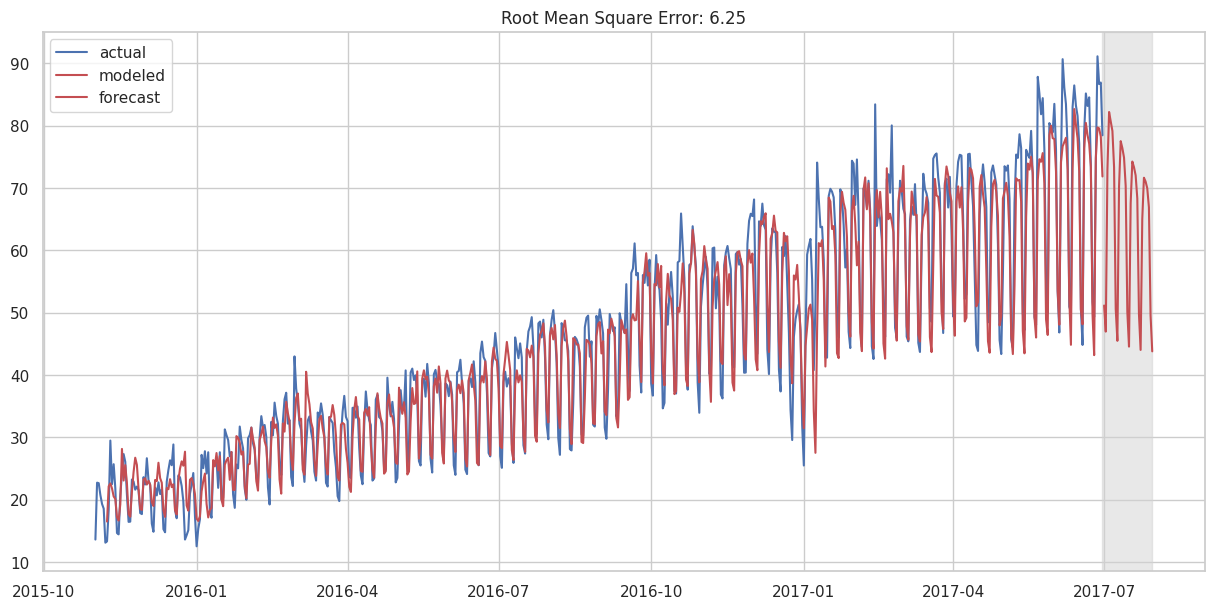

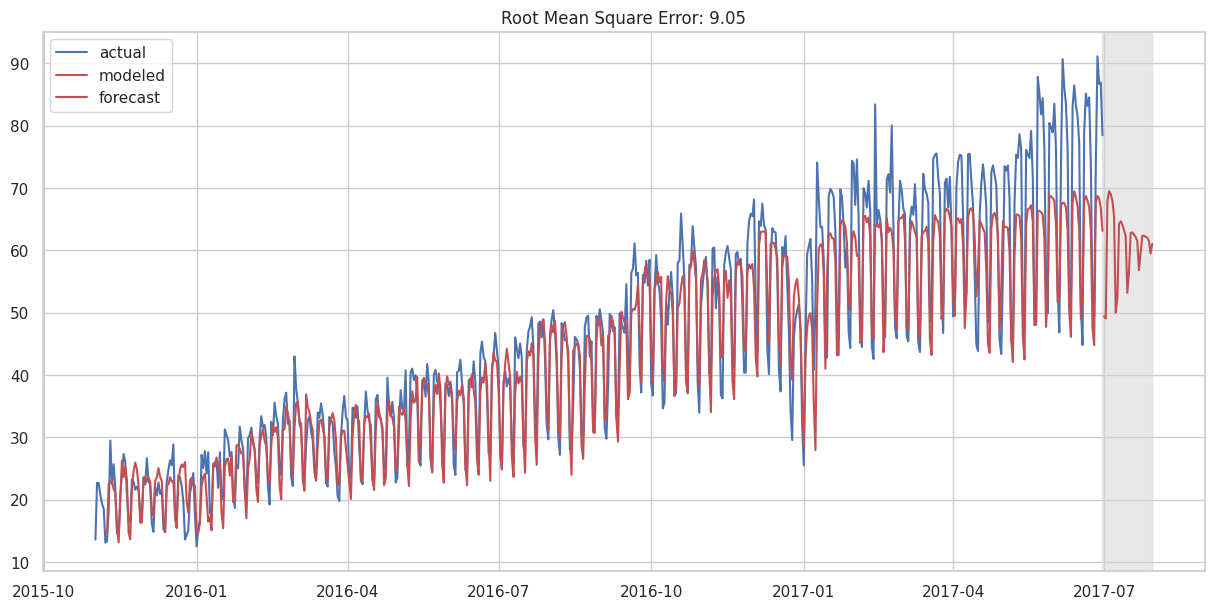

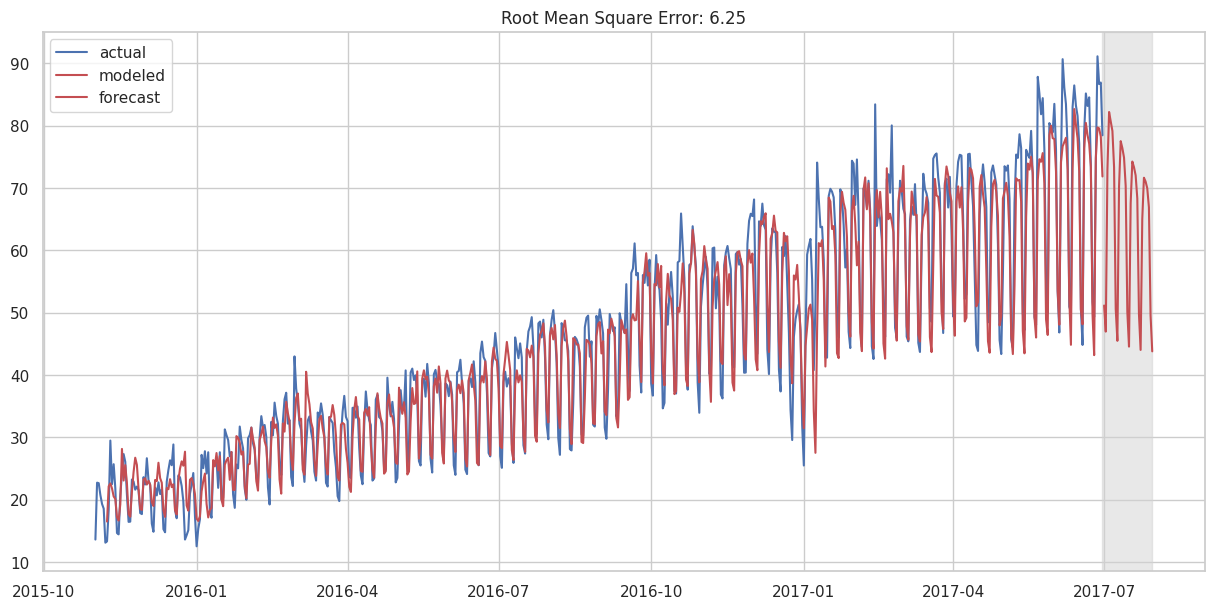

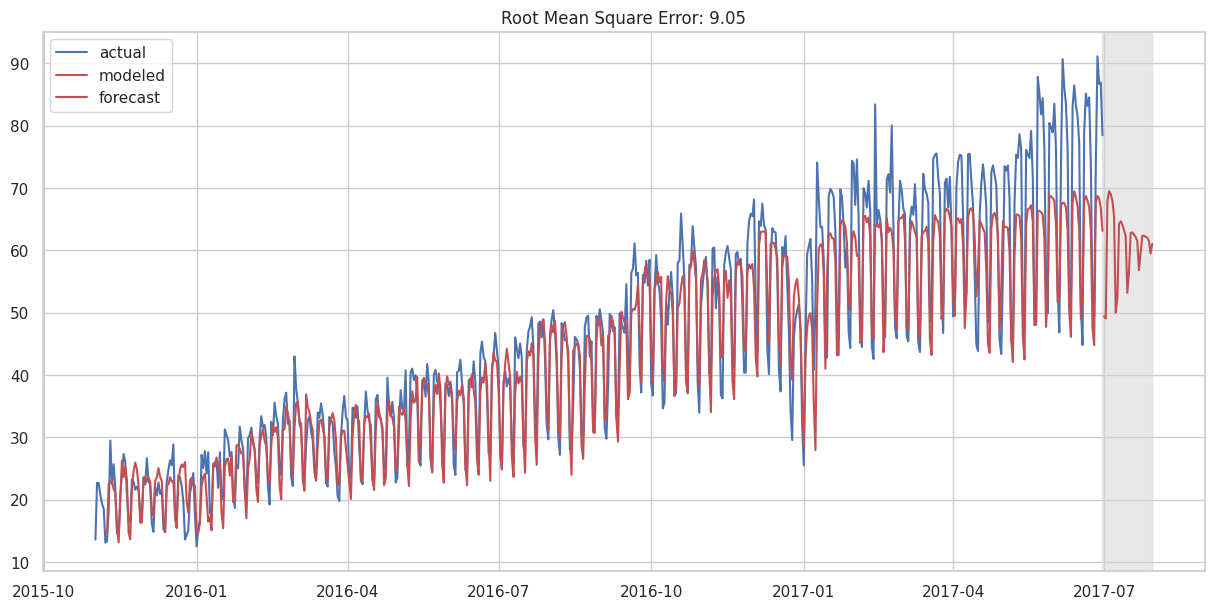

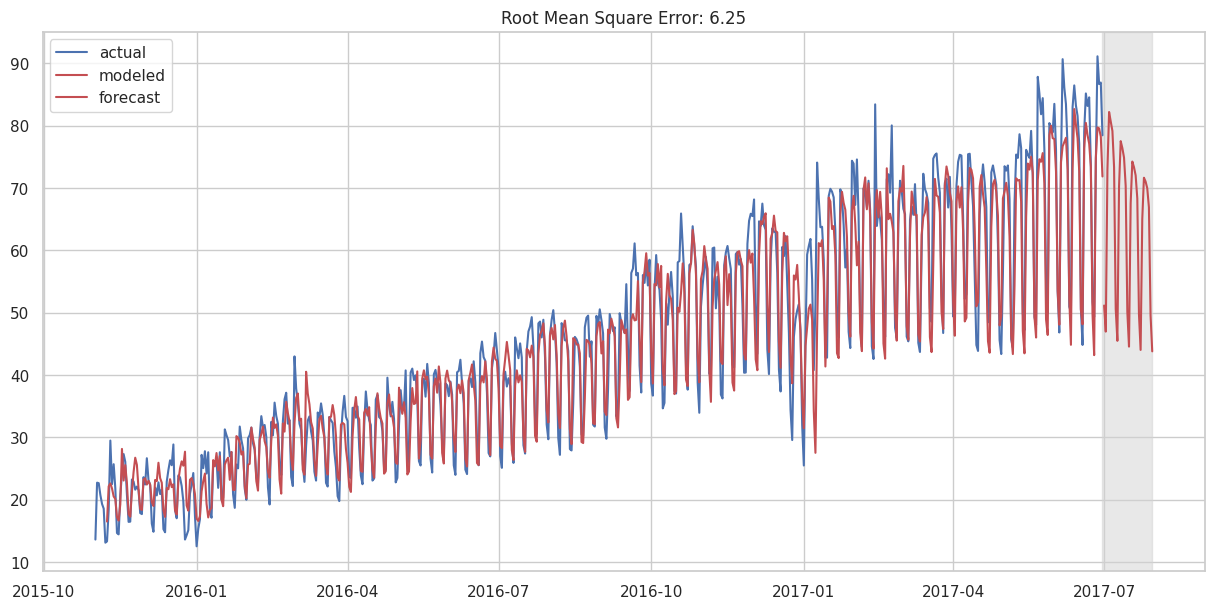

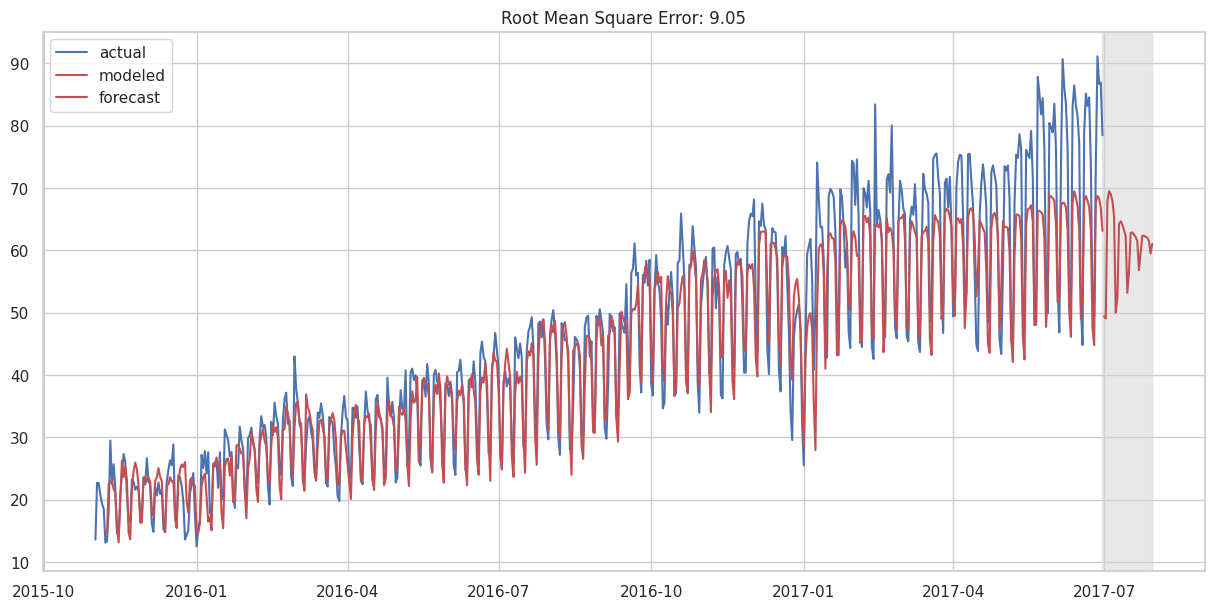

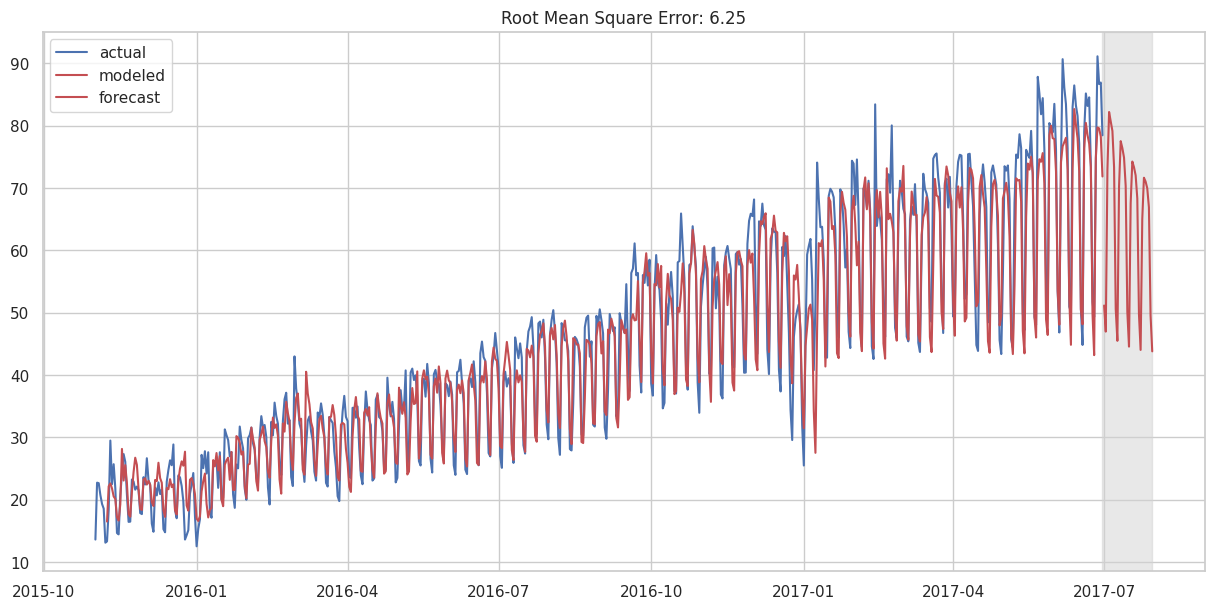

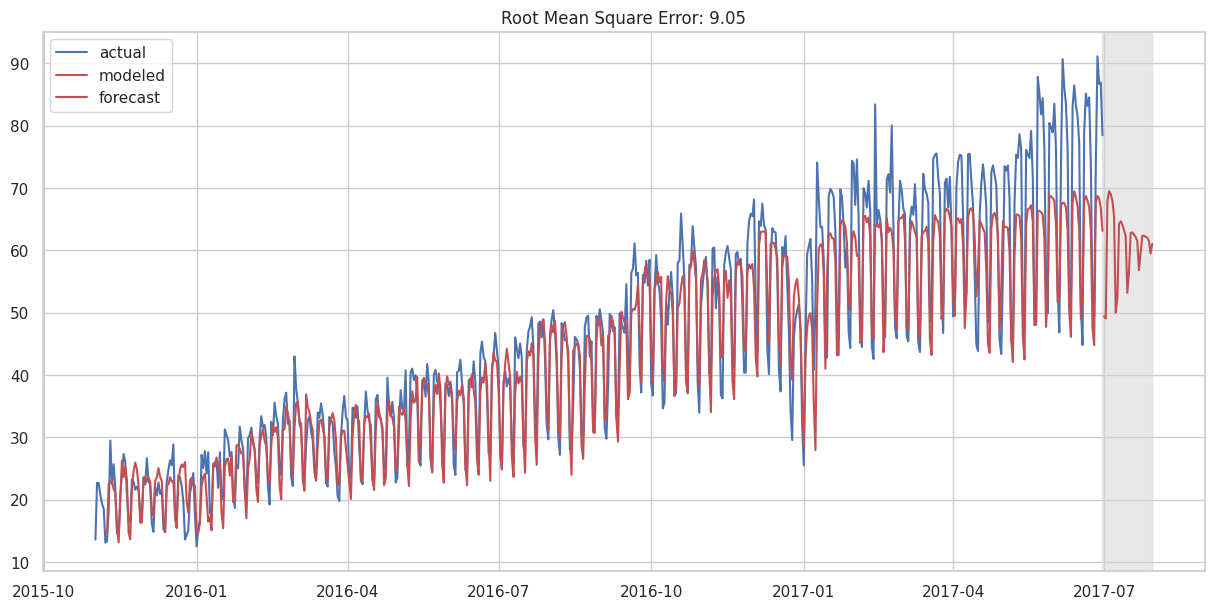

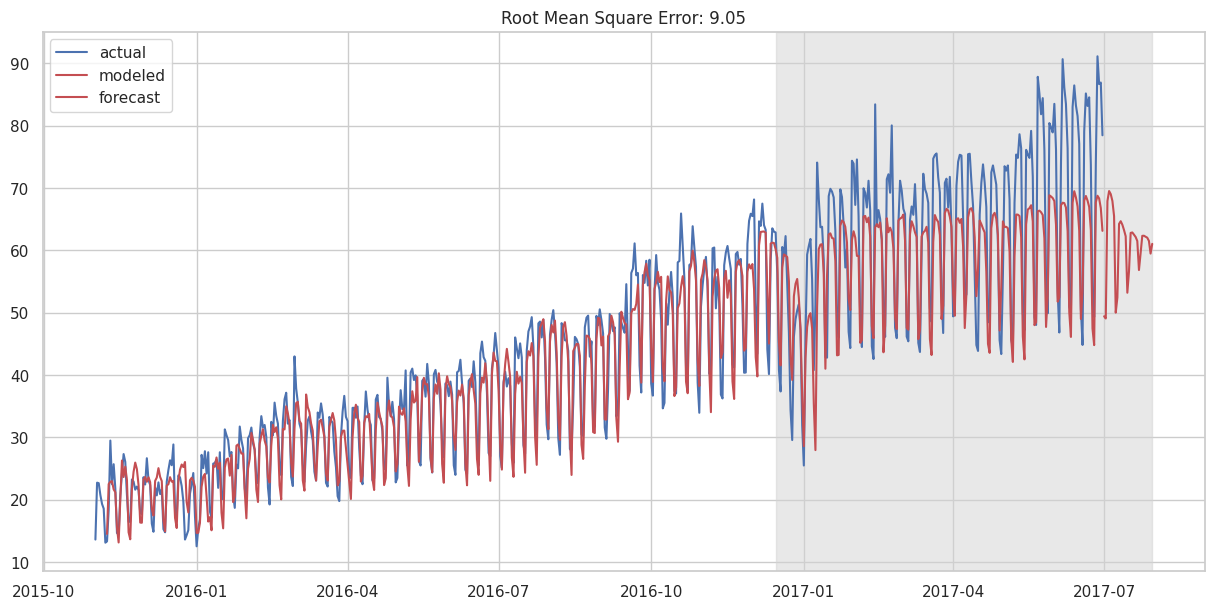

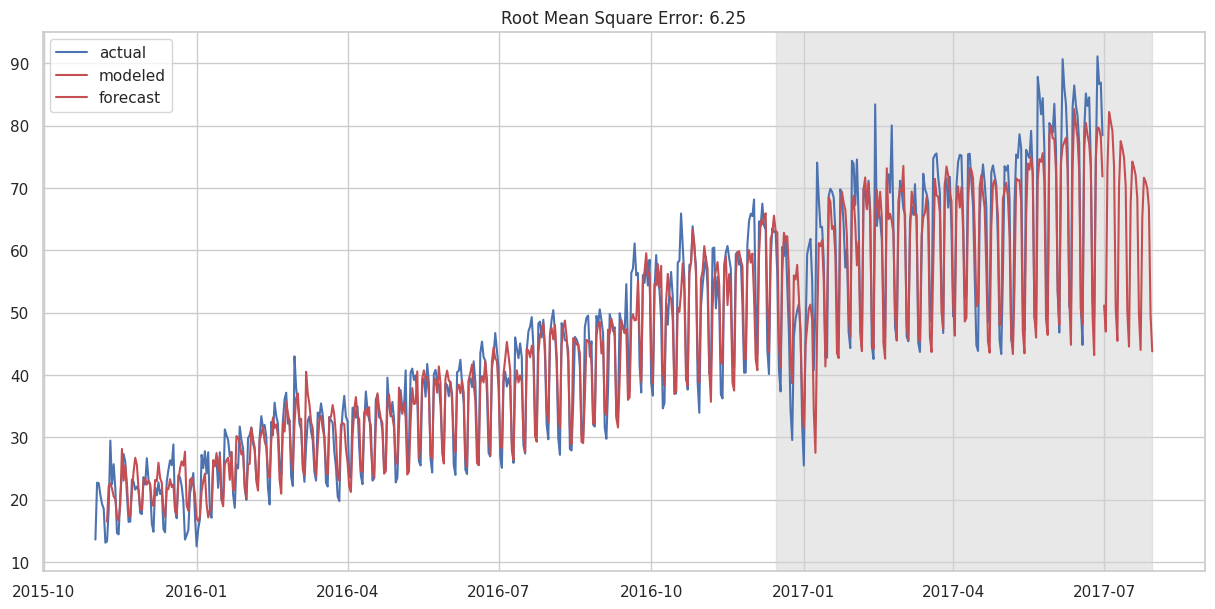

In [110]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Define evaluation metrics
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_squared_error(y_true, y_pred): 
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Helper function to plot all the results for comparison
def plot_results(original, modeled, forecast, train_len, lookback): 
    """ Given 
        original: a time series with datetime index
        modeled: model fitted values
        forecast: inferenced values
        train_len: length of the training set
        lookback: number of previous time steps used to predict the next step
        
        Plot the original time series and the prediction of the test set
    """

    # Calculate RMSE values between the original and modeled
    error = root_mean_squared_error(original[train_len + lookback + 1:], modeled[train_len + lookback + 1:])

    # Plot
    plt.figure(figsize=(15, 7))
    plt.title("Root Mean Square Error: {0:.2f}".format(error))
    plt.plot(original, c='b', label="actual")
    plt.plot(modeled, c='r', label="modeled")
    plt.plot(forecast, color='r', label="forecast")
    plt.axvspan(original.index[train_len + lookback + 1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
# Assuming daily_junc1, s_modeled, s_lstm_forecast, r_modeled, and r_lstm_forecast are defined
# and train_len and lookback are known values

# Plot results for sequential split
plot_results(daily_junc1, s_modeled, s_lstm_forecast, train_len, lookback)

# Plot results for random split
plot_results(daily_junc1, r_modeled, r_lstm_forecast, train_len, lookback)


Epoch 0: train MSE 2254.6980
Epoch 10: train MSE 107.1215
Epoch 20: train MSE 59.4158
Epoch 30: train MSE 30.2733
Epoch 40: train MSE 25.0691
Epoch 50: train MSE 23.8801
Epoch 60: train MSE 26.3326
Epoch 70: train MSE 23.6009
Epoch 80: train MSE 24.0095
Epoch 90: train MSE 22.9359
Epoch 0: train MSE 1363.9587
Epoch 10: train MSE 59.0442
Epoch 20: train MSE 21.5353
Epoch 30: train MSE 18.3089
Epoch 40: train MSE 18.8420
Epoch 50: train MSE 15.2660
Epoch 60: train MSE 16.4153
Epoch 70: train MSE 15.5093
Epoch 80: train MSE 15.7216
Epoch 90: train MSE 15.4276


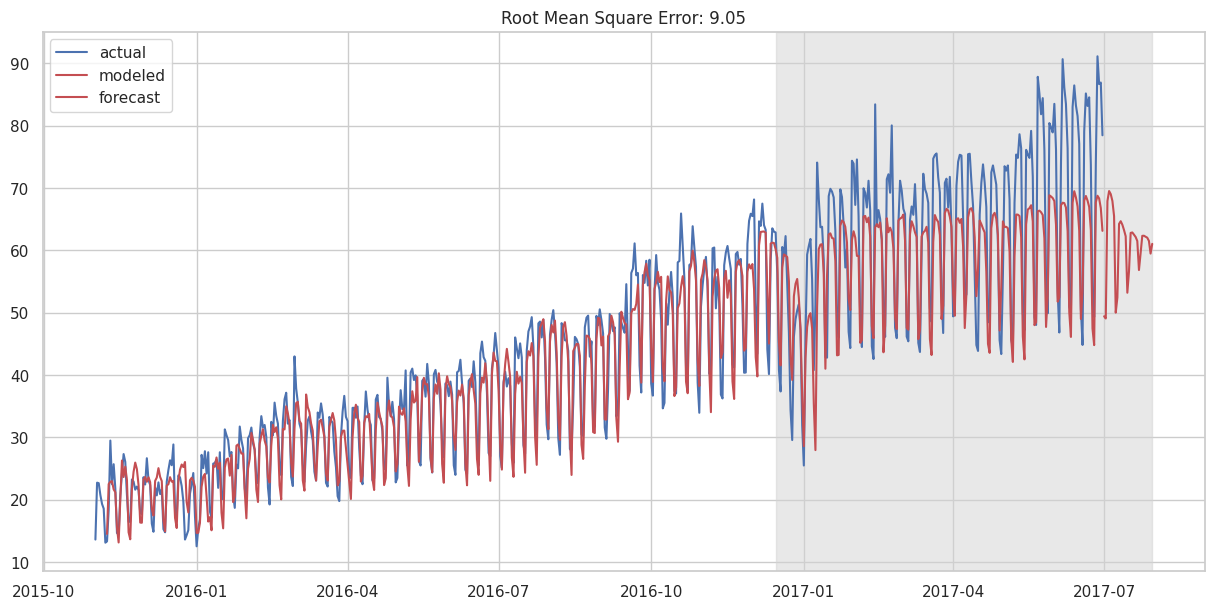

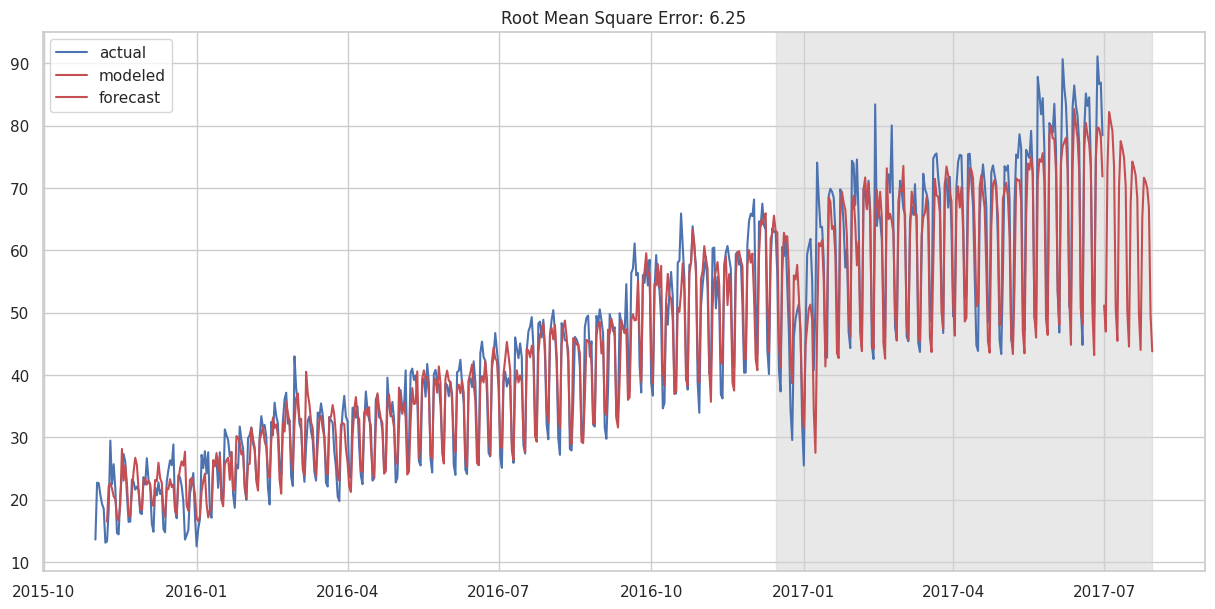

In [112]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
import torch.utils.data as data
from torch.utils.data import Dataset, Subset, DataLoader, random_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Assuming traffic_dataset is already defined and preprocessed as in the previous code

# Generate sequences
def generate_sequences(ts: pd.Series, tw: int, pw: int):
    data = dict()
    L = len(ts)
    for i in range(L-tw):
        sequence = ts[i:i+tw].values
        sequence = np.reshape(sequence, (len(sequence), -1))
        target = ts[i+tw:i+tw+pw].values
        target = np.reshape(target, (len(target), -1))
        data[i] = {'sequence': sequence, 'target': target}
    return data

class SequenceDataset(Dataset):
    def __init__(self, df):
        self.data = df

    def __getitem__(self, idx):
        sample = self.data[idx]
        return torch.Tensor(sample['sequence']), torch.Tensor(sample['target'])
    
    def __len__(self):
        return len(self.data)

lookback = 7
n_pred = 1
sequences = generate_sequences(daily_junc1, lookback, n_pred)
dataset = SequenceDataset(sequences)

split = 0.67
train_len = int(len(dataset) * split)
lens = [train_len, len(dataset) - train_len]

# Data splitting
r_train_ds, r_test_ds = random_split(dataset, lens)
s_train_ds = Subset(dataset, range(lens[0]))
s_test_ds = Subset(dataset, range(lens[0], lens[0] + lens[1]))

BATCH_SIZE = 8

# Dataloaders
r_trainloader = DataLoader(r_train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
r_testloader = DataLoader(r_test_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
s_trainloader = DataLoader(s_train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
s_testloader = DataLoader(s_test_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# Define a simple RNN model
class SimpleRNN(nn.Module):
    def __init__(self, output_size, input_size, hidden_size, num_layers, seq_length):
        super(SimpleRNN, self).__init__()
        self.output_size = output_size
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True)
        self.fc_1 = nn.Linear(hidden_size, 32)
        self.fc = nn.Linear(32, output_size)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        output, hn = self.rnn(x, h_0)
        out = self.relu(output)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

input_size = 1
hidden_size = 64
num_layers = 1
output_size = 1

r_model = SimpleRNN(output_size, input_size, hidden_size, num_layers, lookback)
s_model = SimpleRNN(output_size, input_size, hidden_size, num_layers, lookback)

num_epochs = 100
learning_rate = 0.01

r_optimizer = optim.Adam(r_model.parameters())
s_optimizer = optim.Adam(s_model.parameters())
loss_fn = nn.MSELoss()

# Training loop for RNN (similar to LSTM)
def train_model(model, optimizer, trainloader, num_epochs):
    t_losses = []
    for epoch in range(num_epochs):
        train_loss = 0.0
        model.train()
        for X_batch, y_batch in trainloader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
        epoch_loss = train_loss / len(trainloader)
        t_losses.append(epoch_loss)
        if epoch % 10 == 0:
            print("Epoch %d: train MSE %.4f" % (epoch, epoch_loss))
    return t_losses

# Train RNN models
train_model(r_model, r_optimizer, r_trainloader, num_epochs)
train_model(s_model, s_optimizer, s_trainloader, num_epochs)

# Predictions and evaluation (same as LSTM)
def make_predictions_from_dataloader(model, unshuffled_dataloader):
    model.eval()
    predictions, actuals = [], []
    for x, y in unshuffled_dataloader:
        with torch.no_grad():
            p = model(x)
            predictions.append(p)
            actuals.append(y)
    predictions = torch.cat(predictions).numpy()
    actuals = torch.cat(actuals).numpy()
    return predictions, actuals.squeeze()

# Create an unshuffled DataLoader
unshuffled_dataloader = DataLoader(dataset, shuffle=False)

r_preds, actuals = make_predictions_from_dataloader(r_model, unshuffled_dataloader)
s_preds, actuals = make_predictions_from_dataloader(s_model, unshuffled_dataloader)

# Forecasting and plotting (same as LSTM)

# Define evaluation metrics
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_squared_error(y_true, y_pred): 
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Helper function to plot all the results for comparison
def plot_results(original, modeled, forecast, train_len, lookback): 
    error = root_mean_squared_error(original[train_len + lookback + 1:], modeled[train_len + lookback + 1:])
    plt.figure(figsize=(15, 7))
    plt.title("Root Mean Square Error: {0:.2f}".format(error))
    plt.plot(original, c='b', label="actual")
    plt.plot(modeled, c='r', label="modeled")
    plt.plot(forecast, color='r', label="forecast")
    plt.axvspan(original.index[train_len + lookback + 1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage (same as LSTM)
plot_results(daily_junc1, s_modeled, s_lstm_forecast, train_len, lookback)
plot_results(daily_junc1, r_modeled, r_lstm_forecast, train_len, lookback)


In [114]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
import torch.utils.data as data
from torch.utils.data import Dataset, Subset, DataLoader, random_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Assuming traffic_dataset is already defined and preprocessed as in the previous code

# Generate sequences
def generate_sequences(ts: pd.Series, tw: int, pw: int):
    data = dict()
    L = len(ts)
    for i in range(L-tw):
        sequence = ts[i:i+tw].values
        sequence = np.reshape(sequence, (len(sequence), -1))
        target = ts[i+tw:i+tw+pw].values
        target = np.reshape(target, (len(target), -1))
        data[i] = {'sequence': sequence, 'target': target}
    return data

class SequenceDataset(Dataset):
    def __init__(self, df):
        self.data = df

    def __getitem__(self, idx):
        sample = self.data[idx]
        return torch.Tensor(sample['sequence']), torch.Tensor(sample['target'])
    
    def __len__(self):
        return len(self.data)

lookback = 7
n_pred = 1
sequences = generate_sequences(daily_junc1, lookback, n_pred)
dataset = SequenceDataset(sequences)

split = 0.67
train_len = int(len(dataset) * split)
lens = [train_len, len(dataset) - train_len]

# Data splitting
r_train_ds, r_test_ds = random_split(dataset, lens)
s_train_ds = Subset(dataset, range(lens[0]))
s_test_ds = Subset(dataset, range(lens[0], lens[0] + lens[1]))

BATCH_SIZE = 8

# Dataloaders
r_trainloader = DataLoader(r_train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
r_testloader = DataLoader(r_test_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
s_trainloader = DataLoader(s_train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
s_testloader = DataLoader(s_test_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# Define a simple RNN model
class SimpleRNN(nn.Module):
    def __init__(self, output_size, input_size, hidden_size, num_layers, seq_length):
        super(SimpleRNN, self).__init__()
        self.output_size = output_size
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True)
        self.fc_1 = nn.Linear(hidden_size, 32)
        self.fc = nn.Linear(32, output_size)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        output, hn = self.rnn(x, h_0)
        out = self.relu(output)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

input_size = 1
hidden_size = 64
num_layers = 1
output_size = 1

r_model = SimpleRNN(output_size, input_size, hidden_size, num_layers, lookback)
s_model = SimpleRNN(output_size, input_size, hidden_size, num_layers, lookback)

num_epochs = 100
learning_rate = 0.01

r_optimizer = optim.Adam(r_model.parameters())
s_optimizer = optim.Adam(s_model.parameters())
loss_fn = nn.MSELoss()

# Training loop for RNN (similar to LSTM)
def train_model(model, optimizer, trainloader, num_epochs):
    t_losses = []
    for epoch in range(num_epochs):
        train_loss = 0.0
        model.train()
        for X_batch, y_batch in trainloader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
        epoch_loss = train_loss / len(trainloader)
        t_losses.append(epoch_loss)
        if epoch % 10 == 0:
            print("Epoch %d: train MSE %.4f" % (epoch, epoch_loss))
    return t_losses

# Train RNN models
t_losses_rnn_random = train_model(r_model, r_optimizer, r_trainloader, num_epochs)
t_losses_rnn_sequential = train_model(s_model, s_optimizer, s_trainloader, num_epochs)

# Define a simple LSTM model (as reference)
class SimpleLSTM(nn.Module):
    def __init__(self, output_size, input_size, hidden_size, num_layers, seq_length):
        super(SimpleLSTM, self).__init__()
        self.output_size = output_size
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.fc_1 = nn.Linear(hidden_size, 32)
        self.fc = nn.Linear(32, output_size)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        out = self.relu(output)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

lstm_r_model = SimpleLSTM(output_size, input_size, hidden_size, num_layers, lookback)
lstm_s_model = SimpleLSTM(output_size, input_size, hidden_size, num_layers, lookback)

lstm_r_optimizer = optim.Adam(lstm_r_model.parameters())
lstm_s_optimizer = optim.Adam(lstm_s_model.parameters())

# Train LSTM models
t_losses_lstm_random = train_model(lstm_r_model, lstm_r_optimizer, r_trainloader, num_epochs)
t_losses_lstm_sequential = train_model(lstm_s_model, lstm_s_optimizer, s_trainloader, num_epochs)


/opt/conda/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 1, 1])) that is different to the input size (torch.Size([8, 7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0: train MSE 2227.6421
Epoch 10: train MSE 105.2408
Epoch 20: train MSE 33.7797
Epoch 30: train MSE 30.0776
Epoch 40: train MSE 25.9196
Epoch 50: train MSE 25.6228
Epoch 60: train MSE 27.5671
Epoch 70: train MSE 25.5769
Epoch 80: train MSE 23.7901
Epoch 90: train MSE 25.1539
Epoch 0: train MSE 1371.8673
Epoch 10: train MSE 52.7988
Epoch 20: train MSE 22.1677
Epoch 30: train MSE 19.0600
Epoch 40: train MSE 17.9053
Epoch 50: train MSE 17.9404
Epoch 60: train MSE 17.4315
Epoch 70: train MSE 15.8190
Epoch 80: train MSE 17.0889
Epoch 90: train MSE 17.4869
Epoch 0: train MSE 2301.5849
Epoch 10: train MSE 94.0144
Epoch 20: train MSE 35.4424
Epoch 30: train MSE 25.6050
Epoch 40: train MSE 26.2174
Epoch 50: train MSE 26.9560
Epoch 60: train MSE 26.9374
Epoch 70: train MSE 23.8058
Epoch 80: train MSE 23.6249
Epoch 90: train MSE 24.1379
Epoch 0: train MSE 1435.9455
Epoch 10: train MSE 44.7771
Epoch 20: train MSE 18.8549
Epoch 30: train MSE 19.4798
Epoch 40: train MSE 16.7195
Epoch 50: train

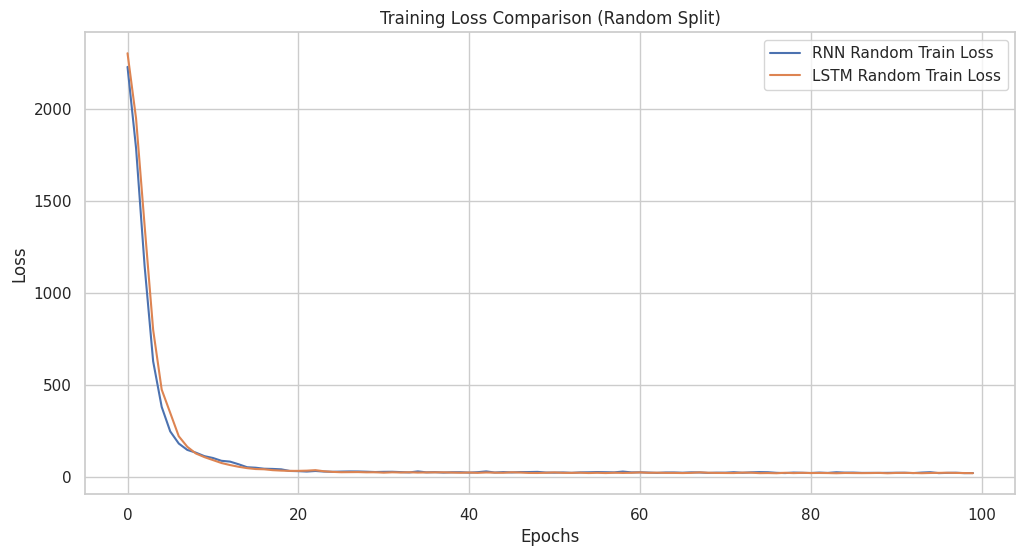

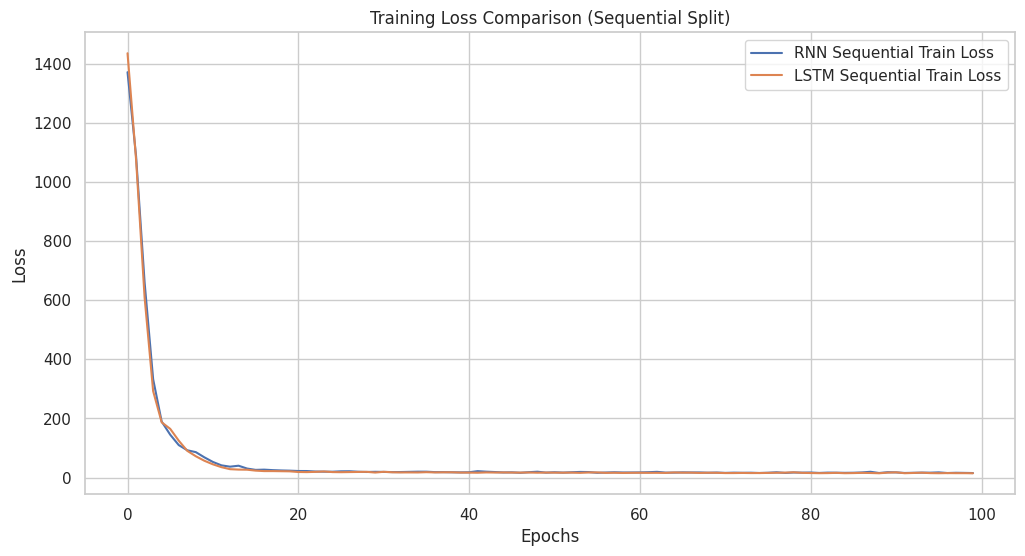

In [115]:
# Plot training losses for both models
def plot_training_losses(rnn_losses, lstm_losses, split_type):
    plt.figure(figsize=(12, 6))
    plt.plot(rnn_losses, label=f'RNN {split_type} Train Loss')
    plt.plot(lstm_losses, label=f'LSTM {split_type} Train Loss')
    plt.title(f'Training Loss Comparison ({split_type} Split)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Plot losses for both random and sequential splits
plot_training_losses(t_losses_rnn_random, t_losses_lstm_random, 'Random')
plot_training_losses(t_losses_rnn_sequential, t_losses_lstm_sequential, 'Sequential')


In [138]:
# Assuming traffic_dataset is preprocessed as in your code
traffic_dataset['DateTime'] = pd.to_datetime(traffic_dataset['DateTime'])
traffic_dataset.set_index('DateTime', inplace=True)
junc1 = traffic_dataset[traffic_dataset['Junction'] == 1]

# Resample the data to daily averages
daily_junc1 = junc1['Vehicles'].resample('D').mean().dropna()

# Create feature matrix (e.g., rolling mean, rolling std)
window_size = 7
features = pd.DataFrame({
    'mean_traffic': daily_junc1.rolling(window=window_size).mean(),
    'std_traffic': daily_junc1.rolling(window=window_size).std()
}).dropna()

# Ensure features are numeric
features = features.apply(pd.to_numeric)


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fe855944820>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fe855944820>
Traceback 

<Figure size 1200x800 with 0 Axes>

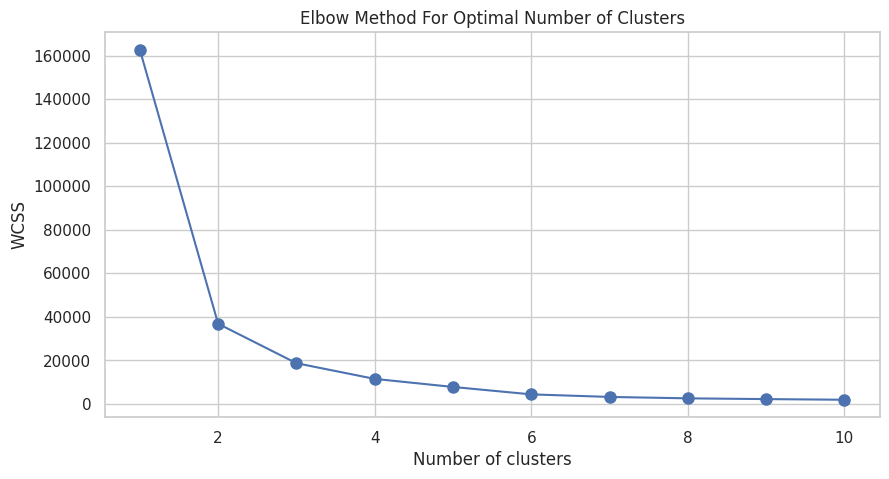

In [139]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def plot_elbow_method(data, max_clusters=10):
    wcss = []
    for i in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, random_state=0)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)
    
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, max_clusters + 1), wcss, 'bo-', markersize=8)
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.title('Elbow Method For Optimal Number of Clusters')
    plt.grid(True)
    plt.show()

# Example usage
plot_elbow_method(features)


        mean_traffic                                 std_traffic            \
                mean       std        min        max        mean       std   
Cluster                                                                      
0          28.162247  5.551287  18.023810  36.803571    5.197753  1.197402   
1          64.595681  4.825247  55.583333  74.392857   12.430974  2.253191   
2          46.311300  5.564484  37.285714  55.494048    8.945083  1.419410   

                              
              min        max  
Cluster                       
0        2.283499   7.694233  
1        8.806685  17.202219  
2        5.259510  14.707358  


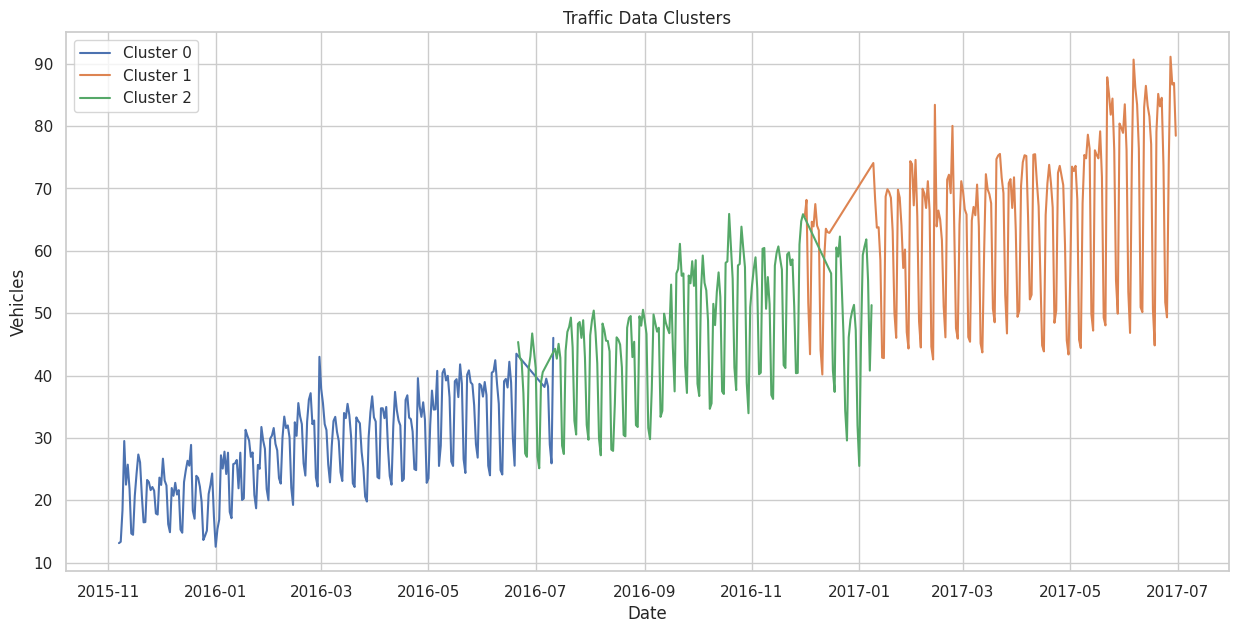

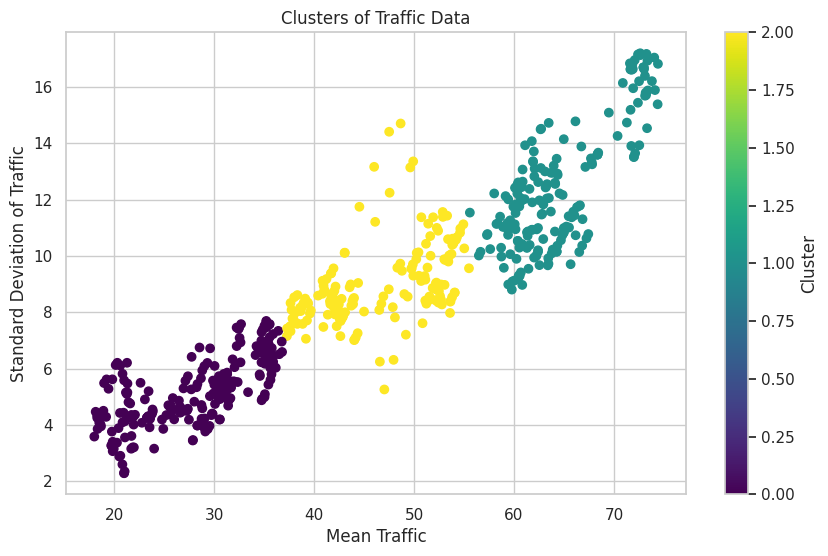

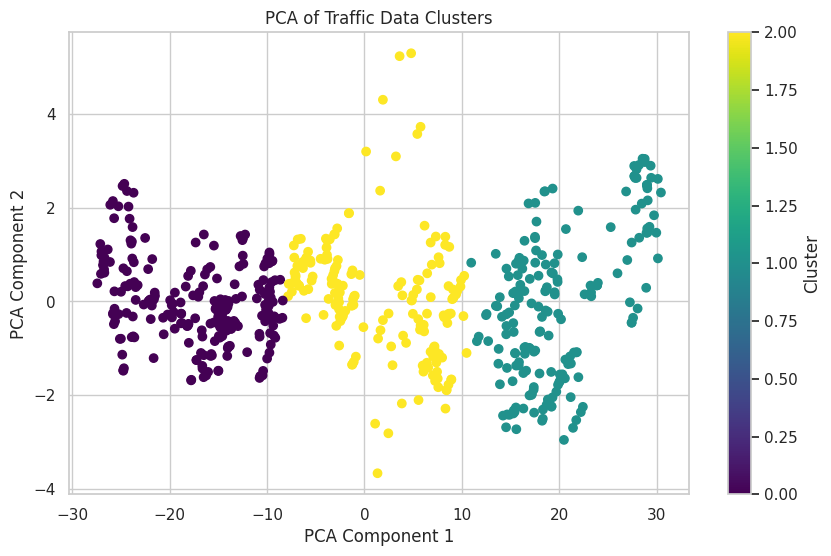

In [140]:
# Number of clusters (determined from the previous step)
optimal_clusters = 3

# Fit KMeans
kmeans = KMeans(n_clusters=optimal_clusters, random_state=0)
kmeans.fit(features)

# Add cluster labels to the data
features['Cluster'] = kmeans.labels_

# Optionally, add the cluster labels back to the original data for further analysis
daily_junc1 = daily_junc1.to_frame()  # Convert Series to DataFrame if needed
daily_junc1['Cluster'] = np.nan
daily_junc1.iloc[window_size-1:, daily_junc1.columns.get_loc('Cluster')] = kmeans.labels_

# Calculate basic statistics for each cluster
cluster_stats = features.groupby('Cluster').agg(['mean', 'std', 'min', 'max'])
print(cluster_stats)

# Plot the time series data for each cluster
plt.figure(figsize=(15, 7))
for cluster in range(optimal_clusters):
    cluster_data = daily_junc1[daily_junc1['Cluster'] == cluster]
    plt.plot(cluster_data.index, cluster_data['Vehicles'], label=f'Cluster {cluster}')
plt.legend()
plt.title('Traffic Data Clusters')
plt.xlabel('Date')
plt.ylabel('Vehicles')
plt.show()

# Scatter plot of the features colored by cluster
plt.figure(figsize=(10, 6))
plt.scatter(features['mean_traffic'], features['std_traffic'], c=features['Cluster'], cmap='viridis', marker='o')
plt.xlabel('Mean Traffic')
plt.ylabel('Standard Deviation of Traffic')
plt.title('Clusters of Traffic Data')
plt.colorbar(label='Cluster')
plt.show()

# PCA for visualizing high-dimensional data in 2D
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(features.drop('Cluster', axis=1))
features['PCA1'] = pca_result[:, 0]
features['PCA2'] = pca_result[:, 1]

plt.figure(figsize=(10, 6))
plt.scatter(features['PCA1'], features['PCA2'], c=features['Cluster'], cmap='viridis', marker='o')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of Traffic Data Clusters')
plt.colorbar(label='Cluster')
plt.show()
